# Paleo-Detector Analysis Pipeline

This notebook provides a complete, end-to-end workflow for the phenomenological analysis of paleo-detectors. It is designed to calculate the expected nuclear recoil track spectra from both external cosmic ray muon signals and various internal/atmospheric backgrounds.

The pipeline is built around the *mineral_utils.py* module, which contains the *Paleodetector* class. This class acts as the physics engine, handling all low-level data processing and calculations. The notebook serves as a high-level interface to configure and orchestrate the analysis.

### Workflow Overview:

**1. Configuration:** All analysis parameters are defined in the configuration cells. This includes selecting the mineral from a library, defining the geological history of the sample (age, exposure time, deposition rate), and setting up the astrophysical scenarios for the cosmic ray flux.

**2. Initialization:** A Paleodetector object is created. This object automatically loads and caches all necessary input data, such as SRIM tables for ion ranges and pre-computed Geant4 results for muon interactions.

**3. Background Calculation:** The notebook calculates the track spectra for the primary background sources:

- Spontaneous Fission: Tracks from the spontaneous fission of Uranium-238 impurities within the mineral.

- Radiogenic Neutrons: Tracks from neutrons produced by (α,n) reactions in the surrounding rock.

- Neutrinos: Tracks from coherent elastic neutrino-nucleus scattering.

**7. Signal Calculation:** For each defined astrophysical scenario, the notebook calculates the track spectrum from cosmic ray muons. This core step includes a sophisticated model for a time-variant cosmic ray flux and the continuous deposition of overburden, which attenuates the signal over the exposure window. The time integration is performed in parallel for efficiency.

**8. Analysis & Plotting:** The final signal and background components are combined to produce the summary plots, showing the total expected number of tracks as a function of track length.


In [1]:
import yaml
import numpy as np
from matplotlib import pyplot as plt

# --- Custom Utility Module ---
from mineral_utils import Paleodetector

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
mineral_name =  "Halite"  # Must match a key in MINERAL_LIBRARY

sample_mass_kg = 0.0001       # Sample mass in kg (e.g., 0.01 for 10g)
total_exposure_kyr = 5600.         # Total age of the sample in millions of years
exposure_window_kyr = 300.  # Duration of CR signal exposure in kyr

# --- Continuous Deposition Model Parameters ---
deposition_rate_m_kyr = np.array([2.5, 30.])
continuous_overburden_density_g_cm3 = 2.16
event_overburden_density_g_cm3 = 1.
event_overburden_depth = 1500.
initial_depth_m =  0.


x_bins = np.linspace(0, 100000, 100)        #Track length bins in nm
x_mids = x_bins[:-1] + np.diff(x_bins) / 2

In [3]:
CONFIG = yaml.safe_load(open('Data/basic_config.yaml', 'r'))
MINERAL_LIBRARY = yaml.safe_load(open('Data/mineral_library.yaml', 'r'))

In [4]:
scenario_config_simple = {
    'name': 'simple',
    'event_fluxes': {
        0.: ('H3a', 'H3a'),
        300.: ('H3a', 'H3a'),
    }
}

scenario_config_SN20 = {
    'name': 'SN20',
    'event_fluxes': {
        0.: ('SN20pc_2kyr', 'SN20pc_2kyr'),            
        10.: ('SN20pc_12kyr', 'SN20pc_12kyr'),
        20.: ('SN20pc_22kyr', 'SN20pc_22kyr'),
        30.: ('SN20pc_32kyr', 'SN20pc_32kyr'),
        40.: ('SN20pc_42kyr', 'SN20pc_42kyr'),
        50.: ('SN20pc_52kyr', 'SN20pc_52kyr'),
        60.: ('SN20pc_62kyr', 'SN20pc_62kyr'),
        70.: ('H3a', 'H3a'),
        300.: ('H3a', 'H3a'),         
    }
}

scenario_config_SN100 = {
    'name': 'SN100',
    'event_fluxes': {
        0.: ('SN100pc_2kyr', 'SN100pc_2kyr'),            
        10.: ('SN100pc_12kyr', 'SN100pc_12kyr'),
        20.: ('SN100pc_22kyr', 'SN100pc_22kyr'),
        30.: ('SN100pc_32kyr', 'SN100pc_32kyr'),
        40.: ('SN100pc_42kyr', 'SN100pc_42kyr'),
        50.: ('H3a', 'H3a'),
        300.: ('H3a', 'H3a'),   
    }
}

In [5]:
# --- Setup & Verification ---
mineral_config = MINERAL_LIBRARY.get(mineral_name)
if not mineral_config:
    raise ValueError(f"Mineral '{mineral_name}' not found in MINERAL_LIBRARY.")

mineral = Paleodetector(mineral_config)

Initialized Paleodetector: Halite


## Calculation of Track Spectra

With the Paleodetector object initialized and all necessary data loaded, we can now proceed with the core physics calculations. The following cells will compute the differential track rate (dR/dx) for each relevant physical process and then integrate these rates over the sample's lifetime to find the total expected number of tracks in each track length bin.

### Calculation Steps:

**1. Backgrounds:** We first calculate the spectra for the steady-state backgrounds that accumulate over the entire geological age of the sample. These include spontaneous fission, radiogenic neutrons, and atmospheric neutrinos.

**2. Muon Signal:** Next, we compute the primary signal from cosmic ray muons. The integrate_muon_signal_spectrum_parallel function is used for this. It performs a numerical integration over the specified exposure_window_kyr, accounting for two key time-dependent effects at each step:

- The evolution of the cosmic ray flux, which is interpolated from the files defined in the scenario_config.

- The increase in shielding due to the continuous deposition_rate_m_kyr.

**3. Final Plot:** Finally, all calculated track components (signals and backgrounds) are summed and plotted to visualize the expected final track spectrum in the detector.

In [6]:
total_fission_tracks = mineral.integrate_fission_spectrum(x_bins, total_exposure_kyr, sample_mass_kg)

Calculating spontaneous fission background...


In [7]:
total_neutron_tracks = mineral.integrate_neutron_spectrum(x_bins, total_exposure_kyr, sample_mass_kg)

Calculating radiogenic neutron background...


/home/cgalelli/Documents/PrimusCode/mineral_utils.py:433: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  total_tracks = [quad(total_tracks_interp, x_bins[i], x_bins[i+1])[0] for i in range(len(x_mids))]


In [8]:
total_mum_tracks_simple = [mineral.integrate_particle_signal_spectrum_parallel(
    x_bins, 
    scenario_config=scenario_config_simple, 
    energy_bins_gev=CONFIG["geant4_energy_bins_gev"], 
    exposure_window_kyr=exposure_window_kyr, 
    sample_mass_kg = sample_mass_kg,
    deposition_rate_m_kyr = deposition,
    overburden_density_g_cm3 = continuous_overburden_density_g_cm3,
    steps=300,
    species='mu-'
) for deposition in deposition_rate_m_kyr]
total_mup_tracks_simple = [mineral.integrate_particle_signal_spectrum_parallel(
    x_bins, 
    scenario_config=scenario_config_simple, 
    energy_bins_gev=CONFIG["geant4_energy_bins_gev"], 
    exposure_window_kyr=exposure_window_kyr, 
    sample_mass_kg = sample_mass_kg,
    deposition_rate_m_kyr = deposition,
    overburden_density_g_cm3 = continuous_overburden_density_g_cm3,
    steps=300,
    species='mu+'
) for deposition in deposition_rate_m_kyr]

Integrating the signal in a 0.01 mm slice of Halite with mass 0.1 g, corresponding to 46.2962962962963 cm2


  0%|          | 0/301 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_0.0kyr_0.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2.0kyr_10.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_5.0kyr_27.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3.0kyr_16.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4.0kyr_21.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1.0kyr_5.4mwe.npz


  1%|▏         | 4/301 [02:37<2:04:50, 25.22s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_6.0kyr_32.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_10.0kyr_54.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_8.0kyr_43.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_7.0kyr_37.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_9.0kyr_48.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_11.0kyr_59.4mwe.npz


  4%|▍         | 12/301 [05:45<1:25:30, 17.75s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_12.0kyr_64.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_13.0kyr_70.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_14.0kyr_75.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_16.0kyr_86.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_15.0kyr_81.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_17.0kyr_91.8mwe.npz


  6%|▌         | 18/301 [08:01<1:07:30, 14.31s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_18.0kyr_97.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_19.0kyr_102.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_20.0kyr_108.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_21.0kyr_113.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_22.0kyr_118.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_23.0kyr_124.2mwe.npz


  8%|▊         | 24/301 [10:23<1:01:53, 13.40s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_24.0kyr_129.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_26.0kyr_140.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_25.0kyr_135.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_27.0kyr_145.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_28.0kyr_151.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_29.0kyr_156.6mwe.npz


 10%|▉         | 30/301 [12:42<50:39, 11.22s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_30.0kyr_162.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_34.0kyr_183.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_31.0kyr_167.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_32.0kyr_172.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_33.0kyr_178.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_35.0kyr_189.0mwe.npz


 11%|█▏        | 34/301 [14:34<1:16:05, 17.10s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_36.0kyr_194.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_37.0kyr_199.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_38.0kyr_205.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_39.0kyr_210.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_40.0kyr_216.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_41.0kyr_221.4mwe.npz


 14%|█▍        | 42/301 [17:09<47:07, 10.92s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_42.0kyr_226.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_43.0kyr_232.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_44.0kyr_237.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_45.0kyr_243.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_46.0kyr_248.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_47.0kyr_253.8mwe.npz


 16%|█▌        | 48/301 [19:46<48:06, 11.41s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_48.0kyr_259.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_49.0kyr_264.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_50.0kyr_270.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_51.0kyr_275.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_52.0kyr_280.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_53.0kyr_286.2mwe.npz


 18%|█▊        | 54/301 [22:22<47:07, 11.45s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_54.0kyr_291.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_55.0kyr_297.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_56.0kyr_302.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_57.0kyr_307.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_58.0kyr_313.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_59.0kyr_318.6mwe.npz


 20%|█▉        | 60/301 [24:57<45:01, 11.21s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_60.0kyr_324.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_61.0kyr_329.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_62.0kyr_334.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_63.0kyr_340.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_64.0kyr_345.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_65.0kyr_351.0mwe.npz


 22%|██▏       | 66/301 [27:31<49:50, 12.73s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_66.0kyr_356.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_67.0kyr_361.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_68.0kyr_367.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_69.0kyr_372.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_70.0kyr_378.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_71.0kyr_383.4mwe.npz


 24%|██▍       | 72/301 [30:07<42:57, 11.26s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_72.0kyr_388.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_73.0kyr_394.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_74.0kyr_399.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_75.0kyr_405.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_76.0kyr_410.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_77.0kyr_415.8mwe.npz


 26%|██▌       | 78/301 [32:44<49:19, 13.27s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_78.0kyr_421.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_80.0kyr_432.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_79.0kyr_426.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_81.0kyr_437.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_82.0kyr_442.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_83.0kyr_448.2mwe.npz


 28%|██▊       | 84/301 [35:21<48:47, 13.49s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_84.0kyr_453.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_85.0kyr_459.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_86.0kyr_464.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_87.0kyr_469.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_88.0kyr_475.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_89.0kyr_480.6mwe.npz


 30%|██▉       | 90/301 [37:58<41:37, 11.84s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_90.0kyr_486.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_91.0kyr_491.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_92.0kyr_496.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_93.0kyr_502.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_94.0kyr_507.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_95.0kyr_513.0mwe.npz


 32%|███▏      | 96/301 [40:31<40:59, 12.00s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_96.0kyr_518.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_97.0kyr_523.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_98.0kyr_529.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_99.0kyr_534.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_100.0kyr_540.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_101.0kyr_545.4mwe.npz


 34%|███▍      | 102/301 [43:06<35:57, 10.84s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_103.0kyr_556.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_102.0kyr_550.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_104.0kyr_561.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_105.0kyr_567.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_106.0kyr_572.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_107.0kyr_577.8mwe.npz


 36%|███▌      | 108/301 [45:44<50:20, 15.65s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_108.0kyr_583.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_109.0kyr_588.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_110.0kyr_594.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_111.0kyr_599.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_112.0kyr_604.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_113.0kyr_610.2mwe.npz


 38%|███▊      | 114/301 [48:19<43:01, 13.81s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_114.0kyr_615.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_115.0kyr_621.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_116.0kyr_626.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_117.0kyr_631.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_118.0kyr_637.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_119.0kyr_642.6mwe.npz


 40%|███▉      | 120/301 [50:57<38:38, 12.81s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_120.0kyr_648.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_121.0kyr_653.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_122.0kyr_658.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_123.0kyr_664.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_124.0kyr_669.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_125.0kyr_675.0mwe.npz


 41%|████      | 124/301 [53:02<53:11, 18.03s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_127.0kyr_685.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_126.0kyr_680.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_129.0kyr_696.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_130.0kyr_702.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_128.0kyr_691.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_131.0kyr_707.4mwe.npz


 43%|████▎     | 129/301 [55:07<1:02:36, 21.84s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_132.0kyr_712.8mwe.npz


 44%|████▍     | 132/301 [55:15<38:39, 13.72s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_133.0kyr_718.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_134.0kyr_723.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_135.0kyr_729.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_136.0kyr_734.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_137.0kyr_739.8mwe.npz


 46%|████▌     | 137/301 [57:43<48:50, 17.87s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_138.0kyr_745.2mwe.npz


 46%|████▌     | 138/301 [57:52<42:15, 15.56s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_139.0kyr_750.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_140.0kyr_756.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_141.0kyr_761.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_142.0kyr_766.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_143.0kyr_772.2mwe.npz


 48%|████▊     | 143/301 [1:00:19<49:38, 18.85s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_144.0kyr_777.6mwe.npz


 48%|████▊     | 144/301 [1:00:22<36:53, 14.10s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_145.0kyr_783.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_146.0kyr_788.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_147.0kyr_793.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_148.0kyr_799.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_149.0kyr_804.6mwe.npz


 49%|████▉     | 148/301 [1:01:53<42:24, 16.63s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_150.0kyr_810.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_151.0kyr_815.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_152.0kyr_820.8mwe.npz


 50%|████▉     | 149/301 [1:02:23<49:02, 19.36s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_153.0kyr_826.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_154.0kyr_831.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_155.0kyr_837.0mwe.npz


 51%|█████▏    | 155/301 [1:04:40<44:10, 18.15s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_156.0kyr_842.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_157.0kyr_847.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_158.0kyr_853.2mwe.npz


 52%|█████▏    | 156/301 [1:04:59<44:30, 18.42s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_159.0kyr_858.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_160.0kyr_864.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_161.0kyr_869.4mwe.npz


 53%|█████▎    | 161/301 [1:07:07<42:17, 18.12s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_162.0kyr_874.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_163.0kyr_880.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_164.0kyr_885.6mwe.npz


 54%|█████▍    | 162/301 [1:07:25<42:06, 18.18s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_165.0kyr_891.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_166.0kyr_896.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_167.0kyr_901.8mwe.npz


 55%|█████▌    | 167/301 [1:09:36<41:41, 18.67s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_168.0kyr_907.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_169.0kyr_912.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_170.0kyr_918.0mwe.npz


 56%|█████▌    | 168/301 [1:09:55<41:45, 18.84s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_171.0kyr_923.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_172.0kyr_928.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_173.0kyr_934.2mwe.npz


 57%|█████▋    | 173/301 [1:12:05<37:27, 17.56s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_174.0kyr_939.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_175.0kyr_945.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_176.0kyr_950.4mwe.npz


 58%|█████▊    | 174/301 [1:12:21<36:01, 17.02s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_177.0kyr_955.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_178.0kyr_961.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_179.0kyr_966.6mwe.npz


 59%|█████▉    | 179/301 [1:14:17<32:02, 15.75s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_180.0kyr_972.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_181.0kyr_977.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_182.0kyr_982.8mwe.npz


 60%|█████▉    | 180/301 [1:14:41<36:41, 18.19s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_183.0kyr_988.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_184.0kyr_993.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_185.0kyr_999.0mwe.npz


 61%|██████▏   | 185/301 [1:16:52<35:51, 18.54s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_187.0kyr_1009.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_186.0kyr_1004.4mwe.npz


 62%|██████▏   | 186/301 [1:17:15<37:59, 19.82s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_188.0kyr_1015.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_189.0kyr_1020.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_190.0kyr_1026.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_191.0kyr_1031.4mwe.npz


 63%|██████▎   | 191/301 [1:18:55<25:45, 14.05s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_193.0kyr_1042.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_192.0kyr_1036.8mwe.npz


 64%|██████▍   | 192/301 [1:19:15<28:52, 15.89s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_194.0kyr_1047.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_195.0kyr_1053.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_196.0kyr_1058.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_197.0kyr_1063.8mwe.npz


 65%|██████▌   | 197/301 [1:21:24<30:57, 17.86s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_198.0kyr_1069.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_199.0kyr_1074.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_200.0kyr_1080.0mwe.npz


 66%|██████▌   | 198/301 [1:21:49<33:36, 19.58s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_201.0kyr_1085.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_202.0kyr_1090.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_203.0kyr_1096.2mwe.npz


 67%|██████▋   | 201/301 [1:23:18<35:41, 21.42s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_204.0kyr_1101.6mwe.npz


 67%|██████▋   | 202/301 [1:23:31<31:19, 18.99s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_205.0kyr_1107.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_206.0kyr_1112.4mwe.npz


 68%|██████▊   | 204/301 [1:23:50<23:30, 14.54s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_207.0kyr_1117.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_208.0kyr_1123.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_209.0kyr_1128.6mwe.npz


 69%|██████▉   | 208/301 [1:25:32<26:17, 16.96s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_210.0kyr_1134.0mwe.npz


 69%|██████▉   | 209/301 [1:25:43<23:01, 15.02s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_211.0kyr_1139.4mwe.npz


 70%|██████▉   | 210/301 [1:26:05<25:52, 17.06s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_212.0kyr_1144.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_213.0kyr_1150.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_214.0kyr_1155.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_215.0kyr_1161.0mwe.npz


 71%|███████   | 214/301 [1:28:07<28:50, 19.89s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_216.0kyr_1166.4mwe.npz


 71%|███████▏  | 215/301 [1:28:16<23:57, 16.71s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_217.0kyr_1171.8mwe.npz


 72%|███████▏  | 216/301 [1:28:40<26:43, 18.86s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_218.0kyr_1177.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_219.0kyr_1182.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_220.0kyr_1188.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_221.0kyr_1193.4mwe.npz


 73%|███████▎  | 220/301 [1:30:42<27:12, 20.16s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_222.0kyr_1198.8mwe.npz


 73%|███████▎  | 221/301 [1:30:52<23:02, 17.29s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_223.0kyr_1204.2mwe.npz


 74%|███████▍  | 222/301 [1:31:15<24:51, 18.89s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_224.0kyr_1209.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_225.0kyr_1215.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_226.0kyr_1220.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_227.0kyr_1225.8mwe.npz


 75%|███████▌  | 227/301 [1:33:26<20:44, 16.81s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_228.0kyr_1231.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_229.0kyr_1236.6mwe.npz


 76%|███████▌  | 228/301 [1:33:49<22:32, 18.53s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_230.0kyr_1242.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_231.0kyr_1247.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_232.0kyr_1252.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_233.0kyr_1258.2mwe.npz


 77%|███████▋  | 232/301 [1:35:53<23:18, 20.26s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_234.0kyr_1263.6mwe.npz


 77%|███████▋  | 233/301 [1:36:02<19:10, 16.92s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_235.0kyr_1269.0mwe.npz


 78%|███████▊  | 234/301 [1:36:23<20:13, 18.12s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_236.0kyr_1274.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_237.0kyr_1279.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_238.0kyr_1285.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_239.0kyr_1290.6mwe.npz


 79%|███████▉  | 238/301 [1:38:28<20:50, 19.85s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_240.0kyr_1296.0mwe.npz


 79%|███████▉  | 239/301 [1:38:43<18:47, 18.19s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_241.0kyr_1301.4mwe.npz


 80%|███████▉  | 240/301 [1:39:00<18:10, 17.88s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_242.0kyr_1306.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_243.0kyr_1312.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_244.0kyr_1317.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_245.0kyr_1323.0mwe.npz


 81%|████████  | 243/301 [1:41:02<26:06, 27.00s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_246.0kyr_1328.4mwe.npz


 81%|████████▏ | 245/301 [1:41:18<16:59, 18.21s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_247.0kyr_1333.8mwe.npz


 82%|████████▏ | 246/301 [1:41:36<16:43, 18.25s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_249.0kyr_1344.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_248.0kyr_1339.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_250.0kyr_1350.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_251.0kyr_1355.4mwe.npz


 83%|████████▎ | 251/301 [1:43:53<14:59, 17.99s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_252.0kyr_1360.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_253.0kyr_1366.2mwe.npz


 84%|████████▎ | 252/301 [1:44:11<14:46, 18.09s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_254.0kyr_1371.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_255.0kyr_1377.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_256.0kyr_1382.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_257.0kyr_1387.8mwe.npz


 85%|████████▌ | 256/301 [1:46:14<14:16, 19.04s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_258.0kyr_1393.2mwe.npz


 85%|████████▌ | 257/301 [1:46:29<13:13, 18.03s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_259.0kyr_1398.6mwe.npz


 86%|████████▌ | 258/301 [1:46:47<12:56, 18.06s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_260.0kyr_1404.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_261.0kyr_1409.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_262.0kyr_1414.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_263.0kyr_1420.2mwe.npz


 87%|████████▋ | 262/301 [1:48:46<12:17, 18.91s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_264.0kyr_1425.6mwe.npz


 87%|████████▋ | 263/301 [1:49:04<11:43, 18.51s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_265.0kyr_1431.0mwe.npz


 88%|████████▊ | 264/301 [1:49:24<11:41, 18.97s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_267.0kyr_1441.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_266.0kyr_1436.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_268.0kyr_1447.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_269.0kyr_1452.6mwe.npz


 89%|████████▊ | 267/301 [1:51:24<15:26, 27.26s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_270.0kyr_1458.0mwe.npz


 89%|████████▉ | 269/301 [1:51:40<09:48, 18.41s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_271.0kyr_1463.4mwe.npz


 90%|████████▉ | 270/301 [1:52:00<09:46, 18.92s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_272.0kyr_1468.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_273.0kyr_1474.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_274.0kyr_1479.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_275.0kyr_1485.0mwe.npz


 91%|█████████ | 274/301 [1:53:58<08:27, 18.79s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_276.0kyr_1490.4mwe.npz


 91%|█████████▏| 275/301 [1:54:14<07:52, 18.16s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_277.0kyr_1495.8mwe.npz


 92%|█████████▏| 276/301 [1:54:36<08:01, 19.26s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_279.0kyr_1506.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_278.0kyr_1501.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_280.0kyr_1512.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_281.0kyr_1517.4mwe.npz


 93%|█████████▎| 281/301 [1:56:51<06:04, 18.24s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_282.0kyr_1522.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_283.0kyr_1528.2mwe.npz


 94%|█████████▎| 282/301 [1:57:13<06:02, 19.08s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_284.0kyr_1533.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_285.0kyr_1539.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_286.0kyr_1544.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_287.0kyr_1549.8mwe.npz


 95%|█████████▌| 287/301 [1:59:27<04:14, 18.17s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_288.0kyr_1555.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_289.0kyr_1560.6mwe.npz


 96%|█████████▌| 288/301 [1:59:49<04:07, 19.06s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_290.0kyr_1566.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_291.0kyr_1571.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_292.0kyr_1576.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_293.0kyr_1582.2mwe.npz


 97%|█████████▋| 293/301 [2:02:03<02:26, 18.26s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_294.0kyr_1587.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_295.0kyr_1593.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_296.0kyr_1598.4mwe.npz


 98%|█████████▊| 294/301 [2:02:27<02:20, 20.03s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_297.0kyr_1603.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_298.0kyr_1609.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_299.0kyr_1614.6mwe.npz


 99%|█████████▉| 299/301 [2:04:33<00:33, 16.87s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_300.0kyr_1620.0mwe.npz


100%|██████████| 301/301 [2:05:43<00:00, 25.06s/it]


Integrating the signal in a 0.01 mm slice of Halite with mass 0.1 g, corresponding to 46.2962962962963 cm2


  0%|          | 0/301 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1.0kyr_64.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2.0kyr_129.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3.0kyr_194.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4.0kyr_259.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_5.0kyr_324.0mwe.npz


  1%|          | 2/301 [02:28<5:36:26, 67.51s/it] 

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_6.0kyr_388.8mwe.npz


  1%|▏         | 4/301 [02:33<1:59:04, 24.05s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_7.0kyr_453.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_9.0kyr_583.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_10.0kyr_648.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_8.0kyr_518.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_11.0kyr_712.8mwe.npz


  3%|▎         | 8/301 [04:54<2:38:13, 32.40s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_12.0kyr_777.6mwe.npz


  4%|▍         | 12/301 [05:03<1:01:45, 12.82s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_13.0kyr_842.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_14.0kyr_907.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_15.0kyr_972.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_16.0kyr_1036.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_17.0kyr_1101.6mwe.npz


  5%|▍         | 14/301 [07:29<2:38:41, 33.18s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_18.0kyr_1166.4mwe.npz


  6%|▌         | 17/301 [07:37<1:16:51, 16.24s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_19.0kyr_1231.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_20.0kyr_1296.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_21.0kyr_1360.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_23.0kyr_1490.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_22.0kyr_1425.6mwe.npz


  7%|▋         | 20/301 [10:03<2:29:45, 31.98s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_24.0kyr_1555.2mwe.npz


  7%|▋         | 22/301 [10:13<1:35:20, 20.51s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_25.0kyr_1620.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_26.0kyr_1684.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_28.0kyr_1814.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_27.0kyr_1749.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_29.0kyr_1879.2mwe.npz


  9%|▊         | 26/301 [12:39<2:18:49, 30.29s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_30.0kyr_1944.0mwe.npz


  9%|▉         | 28/301 [12:48<1:29:16, 19.62s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_31.0kyr_2008.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_32.0kyr_2073.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_33.0kyr_2138.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_34.0kyr_2203.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_35.0kyr_2268.0mwe.npz


 10%|█         | 31/301 [14:36<2:05:21, 27.86s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_36.0kyr_2332.8mwe.npz


 12%|█▏        | 36/301 [15:26<53:14, 12.05s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_37.0kyr_2397.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_39.0kyr_2527.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_38.0kyr_2462.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_40.0kyr_2592.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_41.0kyr_2656.8mwe.npz


 13%|█▎        | 38/301 [17:52<2:32:39, 34.83s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_42.0kyr_2721.6mwe.npz


 14%|█▎        | 41/301 [18:00<1:10:56, 16.37s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_43.0kyr_2786.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_44.0kyr_2851.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_45.0kyr_2916.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_46.0kyr_2980.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_47.0kyr_3045.6mwe.npz


 15%|█▍        | 44/301 [20:26<2:18:17, 32.29s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_48.0kyr_3110.4mwe.npz


 16%|█▌        | 48/301 [20:35<46:42, 11.08s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_49.0kyr_3175.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_50.0kyr_3240.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_51.0kyr_3304.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_52.0kyr_3369.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_53.0kyr_3434.4mwe.npz


 17%|█▋        | 50/301 [23:03<2:42:03, 38.74s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_54.0kyr_3499.2mwe.npz


 18%|█▊        | 54/301 [23:13<52:57, 12.86s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_55.0kyr_3564.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_57.0kyr_3693.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_58.0kyr_3758.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_59.0kyr_3823.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_56.0kyr_3628.8mwe.npz


 18%|█▊        | 55/301 [24:50<2:22:27, 34.74s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_60.0kyr_3888.0mwe.npz


 19%|█▉        | 57/301 [25:43<1:58:32, 29.15s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_61.0kyr_3952.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_62.0kyr_4017.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_64.0kyr_4147.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_65.0kyr_4212.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_63.0kyr_4082.4mwe.npz


 20%|██        | 61/301 [27:24<1:46:53, 26.72s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_66.0kyr_4276.8mwe.npz


 22%|██▏       | 65/301 [28:19<1:00:16, 15.32s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_67.0kyr_4341.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_68.0kyr_4406.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_69.0kyr_4471.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_70.0kyr_4536.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_71.0kyr_4600.8mwe.npz


 22%|██▏       | 67/301 [29:58<1:53:57, 29.22s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_72.0kyr_4665.6mwe.npz


 24%|██▍       | 72/301 [30:56<48:33, 12.72s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_73.0kyr_4730.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_75.0kyr_4860.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_74.0kyr_4795.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_76.0kyr_4924.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_77.0kyr_4989.6mwe.npz


 24%|██▍       | 73/301 [32:34<2:07:53, 33.66s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_78.0kyr_5054.4mwe.npz


 26%|██▌       | 78/301 [33:32<51:08, 13.76s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_79.0kyr_5119.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_80.0kyr_5184.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_81.0kyr_5248.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_82.0kyr_5313.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_83.0kyr_5378.4mwe.npz


 26%|██▌       | 79/301 [35:10<1:54:28, 30.94s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_84.0kyr_5443.2mwe.npz


 28%|██▊       | 83/301 [36:10<57:40, 15.87s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_85.0kyr_5508.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_86.0kyr_5572.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_87.0kyr_5637.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_88.0kyr_5702.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_89.0kyr_5767.2mwe.npz


 28%|██▊       | 85/301 [37:43<1:45:25, 29.28s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_90.0kyr_5832.0mwe.npz


 30%|██▉       | 90/301 [38:45<48:02, 13.66s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_91.0kyr_5896.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_92.0kyr_5961.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_93.0kyr_6026.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_94.0kyr_6091.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_95.0kyr_6156.0mwe.npz


 30%|███       | 91/301 [40:17<1:42:14, 29.21s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_96.0kyr_6220.8mwe.npz


 32%|███▏      | 95/301 [41:22<55:20, 16.12s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_97.0kyr_6285.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_98.0kyr_6350.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_99.0kyr_6415.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_100.0kyr_6480.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_101.0kyr_6544.8mwe.npz


 32%|███▏      | 97/301 [42:51<1:36:28, 28.38s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_102.0kyr_6609.6mwe.npz


 34%|███▍      | 102/301 [44:00<44:55, 13.55s/it] 

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_103.0kyr_6674.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_105.0kyr_6804.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_104.0kyr_6739.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_106.0kyr_6868.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_107.0kyr_6933.6mwe.npz


 34%|███▍      | 103/301 [45:10<1:30:25, 27.40s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_108.0kyr_6998.4mwe.npz


 36%|███▌      | 107/301 [45:45<37:45, 11.68s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_109.0kyr_7063.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_110.0kyr_7128.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_111.0kyr_7192.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_112.0kyr_7257.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_113.0kyr_7322.4mwe.npz


 36%|███▌      | 109/301 [46:30<52:58, 16.56s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_114.0kyr_7387.2mwe.npz


 38%|███▊      | 114/301 [47:05<22:35,  7.25s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_115.0kyr_7452.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_117.0kyr_7581.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_116.0kyr_7516.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_118.0kyr_7646.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_119.0kyr_7711.2mwe.npz


 38%|███▊      | 115/301 [47:50<51:33, 16.63s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_120.0kyr_7776.0mwe.npz


 40%|███▉      | 120/301 [48:26<21:21,  7.08s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_121.0kyr_7840.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_122.0kyr_7905.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_123.0kyr_7970.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_124.0kyr_8035.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_125.0kyr_8100.0mwe.npz


 40%|████      | 121/301 [49:10<49:07, 16.38s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_126.0kyr_8164.8mwe.npz


 42%|████▏     | 126/301 [49:47<20:26,  7.01s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_127.0kyr_8229.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_128.0kyr_8294.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_129.0kyr_8359.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_131.0kyr_8488.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_130.0kyr_8424.0mwe.npz


 42%|████▏     | 127/301 [50:31<47:11, 16.27s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_132.0kyr_8553.6mwe.npz


 44%|████▍     | 132/301 [51:08<20:12,  7.18s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_133.0kyr_8618.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_134.0kyr_8683.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_136.0kyr_8812.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_135.0kyr_8748.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_137.0kyr_8877.6mwe.npz


 44%|████▍     | 133/301 [51:51<46:50, 16.73s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_138.0kyr_8942.4mwe.npz


 45%|████▌     | 136/301 [52:30<33:19, 12.12s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_139.0kyr_9007.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_140.0kyr_9072.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_141.0kyr_9136.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_142.0kyr_9201.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_143.0kyr_9266.4mwe.npz


 46%|████▌     | 139/301 [53:11<34:46, 12.88s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_144.0kyr_9331.2mwe.npz


 48%|████▊     | 144/301 [53:51<16:06,  6.15s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_145.0kyr_9396.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_147.0kyr_9525.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_146.0kyr_9460.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_148.0kyr_9590.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_149.0kyr_9655.2mwe.npz


 48%|████▊     | 145/301 [54:31<40:41, 15.65s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_150.0kyr_9720.0mwe.npz


 50%|████▉     | 150/301 [55:11<18:10,  7.22s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_152.0kyr_9849.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_151.0kyr_9784.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_154.0kyr_9979.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_153.0kyr_9914.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_155.0kyr_10044.0mwe.npz


 50%|█████     | 151/301 [55:53<35:48, 14.33s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_156.0kyr_10108.8mwe.npz


 52%|█████▏    | 156/301 [56:36<20:08,  8.33s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_157.0kyr_10173.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_160.0kyr_10368.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_158.0kyr_10238.4mwe.npz    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_159.0kyr_10303.2mwe.npz

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_161.0kyr_10432.8mwe.npz


 52%|█████▏    | 157/301 [57:14<34:26, 14.35s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_162.0kyr_10497.6mwe.npz


 54%|█████▍    | 162/301 [57:57<16:03,  6.93s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_163.0kyr_10562.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_164.0kyr_10627.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_165.0kyr_10692.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_166.0kyr_10756.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_167.0kyr_10821.6mwe.npz


 54%|█████▍    | 163/301 [58:35<33:00, 14.35s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_168.0kyr_10886.4mwe.npz


 55%|█████▌    | 167/301 [59:17<18:42,  8.38s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_170.0kyr_11016.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_169.0kyr_10951.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_173.0kyr_11210.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_171.0kyr_11080.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_172.0kyr_11145.6mwe.npz


 56%|█████▌    | 169/301 [59:57<29:29, 13.40s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_174.0kyr_11275.2mwe.npz


 56%|█████▋    | 170/301 [1:00:41<45:24, 20.80s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_175.0kyr_11340.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_176.0kyr_11404.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_177.0kyr_11469.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_178.0kyr_11534.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_179.0kyr_11599.2mwe.npz


 58%|█████▊    | 175/301 [1:01:17<25:34, 12.18s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_180.0kyr_11664.0mwe.npz


 60%|█████▉    | 180/301 [1:02:02<15:39,  7.76s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_181.0kyr_11728.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_182.0kyr_11793.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_184.0kyr_11923.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_183.0kyr_11858.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_185.0kyr_11988.0mwe.npz


 60%|██████    | 181/301 [1:02:37<27:32, 13.77s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_186.0kyr_12052.8mwe.npz


 61%|██████    | 184/301 [1:03:22<23:15, 11.92s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_187.0kyr_12117.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_188.0kyr_12182.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_189.0kyr_12247.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_190.0kyr_12312.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_191.0kyr_12376.8mwe.npz


 62%|██████▏   | 187/301 [1:03:59<22:55, 12.07s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_192.0kyr_12441.6mwe.npz


 63%|██████▎   | 191/301 [1:04:44<15:52,  8.66s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_193.0kyr_12506.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_194.0kyr_12571.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_195.0kyr_12636.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_196.0kyr_12700.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_197.0kyr_12765.6mwe.npz


 64%|██████▍   | 193/301 [1:05:19<22:18, 12.40s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_198.0kyr_12830.4mwe.npz


 65%|██████▌   | 197/301 [1:06:06<16:07,  9.30s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_199.0kyr_12895.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_200.0kyr_12960.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_201.0kyr_13024.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_202.0kyr_13089.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_203.0kyr_13154.4mwe.npz


 66%|██████▌   | 199/301 [1:06:39<20:23, 11.99s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_204.0kyr_13219.2mwe.npz


 67%|██████▋   | 203/301 [1:07:26<14:11,  8.69s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_205.0kyr_13284.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_206.0kyr_13348.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_207.0kyr_13413.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_208.0kyr_13478.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_209.0kyr_13543.2mwe.npz


 68%|██████▊   | 205/301 [1:08:00<19:31, 12.20s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_210.0kyr_13608.0mwe.npz


 69%|██████▉   | 208/301 [1:08:50<19:50, 12.80s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_211.0kyr_13672.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_212.0kyr_13737.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_213.0kyr_13802.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_214.0kyr_13867.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_215.0kyr_13932.0mwe.npz


 70%|███████   | 211/301 [1:09:23<17:51, 11.90s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_216.0kyr_13996.8mwe.npz


 72%|███████▏  | 216/301 [1:10:13<10:31,  7.43s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_217.0kyr_14061.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_218.0kyr_14126.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_219.0kyr_14191.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_220.0kyr_14256.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_221.0kyr_14320.8mwe.npz


 72%|███████▏  | 217/301 [1:10:44<17:31, 12.51s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_222.0kyr_14385.6mwe.npz


 74%|███████▍  | 222/301 [1:11:34<09:25,  7.16s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_223.0kyr_14450.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_224.0kyr_14515.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_226.0kyr_14644.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_225.0kyr_14580.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_227.0kyr_14709.6mwe.npz


 74%|███████▍  | 223/301 [1:12:05<16:29, 12.69s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_228.0kyr_14774.4mwe.npz


 76%|███████▌  | 228/301 [1:12:55<08:29,  6.98s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_229.0kyr_14839.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_230.0kyr_14904.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_231.0kyr_14968.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_232.0kyr_15033.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_233.0kyr_15098.4mwe.npz


 76%|███████▌  | 229/301 [1:13:25<15:01, 12.52s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_234.0kyr_15163.2mwe.npz


 78%|███████▊  | 234/301 [1:14:17<08:54,  7.97s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_235.0kyr_15228.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_236.0kyr_15292.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_237.0kyr_15357.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_238.0kyr_15422.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_239.0kyr_15487.2mwe.npz


 78%|███████▊  | 235/301 [1:14:46<14:52, 13.52s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_240.0kyr_15552.0mwe.npz


 80%|███████▉  | 240/301 [1:15:38<07:58,  7.85s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_241.0kyr_15616.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_242.0kyr_15681.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_243.0kyr_15746.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_244.0kyr_15811.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_245.0kyr_15876.0mwe.npz


 80%|████████  | 241/301 [1:16:06<12:58, 12.98s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_246.0kyr_15940.8mwe.npz


 82%|████████▏ | 246/301 [1:16:59<06:25,  7.01s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_247.0kyr_16005.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_248.0kyr_16070.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_250.0kyr_16200.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_249.0kyr_16135.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_251.0kyr_16264.8mwe.npz


 82%|████████▏ | 247/301 [1:17:26<11:27, 12.72s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_252.0kyr_16329.6mwe.npz


 84%|████████▎ | 252/301 [1:18:20<06:16,  7.69s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_253.0kyr_16394.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_254.0kyr_16459.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_255.0kyr_16524.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_256.0kyr_16588.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_257.0kyr_16653.6mwe.npz


 84%|████████▍ | 253/301 [1:18:47<10:05, 12.62s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_258.0kyr_16718.4mwe.npz


 86%|████████▌ | 258/301 [1:19:42<04:55,  6.86s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_259.0kyr_16783.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_260.0kyr_16848.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_261.0kyr_16912.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_262.0kyr_16977.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_263.0kyr_17042.4mwe.npz


 86%|████████▌ | 259/301 [1:20:07<08:39, 12.36s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_264.0kyr_17107.2mwe.npz


 87%|████████▋ | 263/301 [1:21:05<06:05,  9.63s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_265.0kyr_17172.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_266.0kyr_17236.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_268.0kyr_17366.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_267.0kyr_17301.6mwe.npz


 88%|████████▊ | 265/301 [1:21:27<06:10, 10.29s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_269.0kyr_17431.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_270.0kyr_17496.0mwe.npz


 90%|████████▉ | 270/301 [1:22:26<04:19,  8.38s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_271.0kyr_17560.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_272.0kyr_17625.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_273.0kyr_17690.4mwe.npz


 90%|█████████ | 271/301 [1:22:48<05:38, 11.30s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_275.0kyr_17820.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_274.0kyr_17755.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_276.0kyr_17884.8mwe.npz


 92%|█████████▏| 276/301 [1:23:47<02:53,  6.95s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_277.0kyr_17949.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_279.0kyr_18079.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_278.0kyr_18014.4mwe.npz


 92%|█████████▏| 277/301 [1:24:08<04:20, 10.84s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_280.0kyr_18144.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_281.0kyr_18208.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_282.0kyr_18273.6mwe.npz


 93%|█████████▎| 281/301 [1:25:10<03:27, 10.36s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_284.0kyr_18403.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_283.0kyr_18338.4mwe.npz


 94%|█████████▍| 283/301 [1:25:29<03:01, 10.11s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_285.0kyr_18468.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_286.0kyr_18532.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_287.0kyr_18597.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_288.0kyr_18662.4mwe.npz


 96%|█████████▌| 288/301 [1:26:32<01:34,  7.24s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_290.0kyr_18792.0mwe.npz


 96%|█████████▌| 289/301 [1:26:48<01:57,  9.75s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_289.0kyr_18727.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_291.0kyr_18856.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_292.0kyr_18921.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_293.0kyr_18986.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_294.0kyr_19051.2mwe.npz


 98%|█████████▊| 295/301 [1:28:08<00:58,  9.71s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_295.0kyr_19116.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_296.0kyr_19180.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_297.0kyr_19245.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_299.0kyr_19375.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_298.0kyr_19310.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_300.0kyr_19440.0mwe.npz


100%|██████████| 301/301 [1:29:23<00:00, 17.82s/it]

Integrating the signal in a 0.01 mm slice of Halite with mass 0.1 g, corresponding to 46.2962962962963 cm2



  0%|          | 0/301 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1.0kyr_5.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3.0kyr_16.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_0.0kyr_0.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2.0kyr_10.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4.0kyr_21.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_5.0kyr_27.0mwe.npz


  2%|▏         | 5/301 [01:16<48:31,  9.84s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_7.0kyr_37.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_6.0kyr_32.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_10.0kyr_54.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_8.0kyr_43.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_9.0kyr_48.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_11.0kyr_59.4mwe.npz


  3%|▎         | 10/301 [02:32<52:41, 10.86s/it] 

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_12.0kyr_64.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_13.0kyr_70.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_14.0kyr_75.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_15.0kyr_81.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_16.0kyr_86.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_17.0kyr_91.8mwe.npz


  6%|▌         | 17/301 [03:52<36:05,  7.63s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_18.0kyr_97.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_19.0kyr_102.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_21.0kyr_113.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_20.0kyr_108.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_22.0kyr_118.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_23.0kyr_124.2mwe.npz


  8%|▊         | 24/301 [05:08<24:32,  5.32s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_24.0kyr_129.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_25.0kyr_135.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_26.0kyr_140.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_27.0kyr_145.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_28.0kyr_151.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_29.0kyr_156.6mwe.npz


 10%|▉         | 30/301 [06:23<24:07,  5.34s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_30.0kyr_162.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_31.0kyr_167.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_32.0kyr_172.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_33.0kyr_178.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_34.0kyr_183.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_35.0kyr_189.0mwe.npz


 12%|█▏        | 36/301 [07:40<27:32,  6.24s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_36.0kyr_194.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_37.0kyr_199.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_39.0kyr_210.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_38.0kyr_205.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_40.0kyr_216.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_41.0kyr_221.4mwe.npz


 14%|█▍        | 42/301 [08:55<24:23,  5.65s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_42.0kyr_226.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_43.0kyr_232.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_44.0kyr_237.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_45.0kyr_243.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_46.0kyr_248.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_47.0kyr_253.8mwe.npz


 16%|█▌        | 48/301 [10:11<27:50,  6.60s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_48.0kyr_259.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_49.0kyr_264.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_50.0kyr_270.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_51.0kyr_275.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_52.0kyr_280.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_53.0kyr_286.2mwe.npz


 18%|█▊        | 54/301 [11:26<25:42,  6.24s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_54.0kyr_291.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_55.0kyr_297.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_56.0kyr_302.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_57.0kyr_307.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_59.0kyr_318.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_58.0kyr_313.2mwe.npz


 20%|█▉        | 59/301 [12:42<31:04,  7.71s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_60.0kyr_324.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_61.0kyr_329.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_62.0kyr_334.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_63.0kyr_340.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_64.0kyr_345.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_65.0kyr_351.0mwe.npz


 22%|██▏       | 65/301 [13:58<29:22,  7.47s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_66.0kyr_356.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_67.0kyr_361.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_68.0kyr_367.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_69.0kyr_372.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_70.0kyr_378.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_71.0kyr_383.4mwe.npz


 24%|██▍       | 72/301 [15:16<21:16,  5.57s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_72.0kyr_388.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_73.0kyr_394.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_74.0kyr_399.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_75.0kyr_405.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_76.0kyr_410.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_77.0kyr_415.8mwe.npz


 26%|██▌       | 78/301 [16:34<23:13,  6.25s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_78.0kyr_421.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_79.0kyr_426.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_80.0kyr_432.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_81.0kyr_437.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_82.0kyr_442.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_83.0kyr_448.2mwe.npz


 28%|██▊       | 84/301 [17:49<22:23,  6.19s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_84.0kyr_453.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_85.0kyr_459.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_86.0kyr_464.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_87.0kyr_469.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_88.0kyr_475.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_89.0kyr_480.6mwe.npz


 30%|██▉       | 90/301 [19:04<20:30,  5.83s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_90.0kyr_486.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_91.0kyr_491.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_92.0kyr_496.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_93.0kyr_502.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_94.0kyr_507.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_95.0kyr_513.0mwe.npz


 32%|███▏      | 95/301 [20:18<27:04,  7.89s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_97.0kyr_523.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_96.0kyr_518.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_98.0kyr_529.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_99.0kyr_534.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_100.0kyr_540.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_101.0kyr_545.4mwe.npz


 34%|███▍      | 102/301 [21:34<18:50,  5.68s/it] 

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_102.0kyr_550.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_103.0kyr_556.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_104.0kyr_561.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_105.0kyr_567.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_106.0kyr_572.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_107.0kyr_577.8mwe.npz


 36%|███▌      | 108/301 [22:50<22:49,  7.10s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_108.0kyr_583.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_109.0kyr_588.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_110.0kyr_594.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_111.0kyr_599.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_112.0kyr_604.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_113.0kyr_610.2mwe.npz


 38%|███▊      | 114/301 [24:05<19:54,  6.39s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_114.0kyr_615.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_115.0kyr_621.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_116.0kyr_626.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_117.0kyr_631.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_118.0kyr_637.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_119.0kyr_642.6mwe.npz


 40%|███▉      | 120/301 [25:21<20:30,  6.80s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_120.0kyr_648.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_121.0kyr_653.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_122.0kyr_658.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_124.0kyr_669.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_123.0kyr_664.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_125.0kyr_675.0mwe.npz


 42%|████▏     | 125/301 [26:34<22:41,  7.74s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_126.0kyr_680.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_127.0kyr_685.8mwe.npz


 42%|████▏     | 126/301 [26:38<18:55,  6.49s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_128.0kyr_691.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_129.0kyr_696.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_130.0kyr_702.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_131.0kyr_707.4mwe.npz


 44%|████▎     | 131/301 [27:51<21:41,  7.66s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_132.0kyr_712.8mwe.npz


 44%|████▍     | 132/301 [27:55<18:21,  6.52s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_133.0kyr_718.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_134.0kyr_723.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_135.0kyr_729.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_136.0kyr_734.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_137.0kyr_739.8mwe.npz


 46%|████▌     | 137/301 [29:07<22:48,  8.34s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_138.0kyr_745.2mwe.npz


 46%|████▌     | 138/301 [29:11<19:12,  7.07s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_139.0kyr_750.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_141.0kyr_761.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_140.0kyr_756.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_142.0kyr_766.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_143.0kyr_772.2mwe.npz


 47%|████▋     | 141/301 [30:22<38:51, 14.57s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_144.0kyr_777.6mwe.npz


 47%|████▋     | 142/301 [30:23<28:23, 10.71s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_145.0kyr_783.0mwe.npz


 48%|████▊     | 144/301 [30:26<17:35,  6.72s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_148.0kyr_799.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_146.0kyr_788.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_147.0kyr_793.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_149.0kyr_804.6mwe.npz


 49%|████▊     | 146/301 [31:24<37:17, 14.43s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_150.0kyr_810.0mwe.npz


 50%|████▉     | 150/301 [31:41<15:50,  6.29s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_151.0kyr_815.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_152.0kyr_820.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_153.0kyr_826.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_154.0kyr_831.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_155.0kyr_837.0mwe.npz


 50%|█████     | 152/301 [32:40<35:59, 14.49s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_156.0kyr_842.4mwe.npz


 51%|█████▏    | 155/301 [32:57<20:33,  8.45s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_157.0kyr_847.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_158.0kyr_853.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_159.0kyr_858.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_160.0kyr_864.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_161.0kyr_869.4mwe.npz


 52%|█████▏    | 158/301 [33:55<33:06, 13.89s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_162.0kyr_874.8mwe.npz


 54%|█████▍    | 162/301 [34:12<13:59,  6.04s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_163.0kyr_880.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_165.0kyr_891.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_164.0kyr_885.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_166.0kyr_896.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_167.0kyr_901.8mwe.npz


 54%|█████▍    | 164/301 [35:12<36:55, 16.17s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_168.0kyr_907.2mwe.npz


 56%|█████▌    | 168/301 [35:28<13:56,  6.29s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_169.0kyr_912.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_170.0kyr_918.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_171.0kyr_923.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_172.0kyr_928.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_173.0kyr_934.2mwe.npz


 56%|█████▋    | 170/301 [36:28<35:37, 16.31s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_174.0kyr_939.6mwe.npz


 58%|█████▊    | 174/301 [36:43<12:57,  6.12s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_175.0kyr_945.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_176.0kyr_950.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_177.0kyr_955.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_178.0kyr_961.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_179.0kyr_966.6mwe.npz


 59%|█████▉    | 177/301 [37:51<29:10, 14.11s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_180.0kyr_972.0mwe.npz


 59%|█████▉    | 179/301 [37:57<16:54,  8.32s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_181.0kyr_977.4mwe.npz


 60%|█████▉    | 180/301 [37:58<12:35,  6.24s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_182.0kyr_982.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_183.0kyr_988.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_184.0kyr_993.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_185.0kyr_999.0mwe.npz


 60%|██████    | 182/301 [38:57<31:32, 15.91s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_186.0kyr_1004.4mwe.npz


 61%|██████▏   | 185/301 [39:12<16:43,  8.65s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_187.0kyr_1009.8mwe.npz


 62%|██████▏   | 186/301 [39:14<13:17,  6.94s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_188.0kyr_1015.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_189.0kyr_1020.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_190.0kyr_1026.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_191.0kyr_1031.4mwe.npz


 62%|██████▏   | 188/301 [40:13<29:12, 15.51s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_192.0kyr_1036.8mwe.npz


 64%|██████▍   | 192/301 [40:30<12:05,  6.66s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_193.0kyr_1042.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_194.0kyr_1047.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_195.0kyr_1053.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_196.0kyr_1058.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_197.0kyr_1063.8mwe.npz


 64%|██████▍   | 194/301 [41:29<26:57, 15.12s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_198.0kyr_1069.2mwe.npz


 66%|██████▌   | 198/301 [41:46<11:01,  6.42s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_199.0kyr_1074.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_200.0kyr_1080.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_201.0kyr_1085.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_202.0kyr_1090.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_203.0kyr_1096.2mwe.npz


 66%|██████▋   | 200/301 [42:44<26:31, 15.76s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_204.0kyr_1101.6mwe.npz


 67%|██████▋   | 202/301 [42:58<17:57, 10.88s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_205.0kyr_1107.0mwe.npz


 68%|██████▊   | 204/301 [43:02<10:58,  6.79s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_206.0kyr_1112.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_208.0kyr_1123.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_207.0kyr_1117.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_209.0kyr_1128.6mwe.npz


 68%|██████▊   | 206/301 [44:00<23:49, 15.05s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_210.0kyr_1134.0mwe.npz


 70%|██████▉   | 210/301 [44:16<09:46,  6.44s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_211.0kyr_1139.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_212.0kyr_1144.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_213.0kyr_1150.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_214.0kyr_1155.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_215.0kyr_1161.0mwe.npz


 70%|███████   | 212/301 [45:18<24:58, 16.84s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_216.0kyr_1166.4mwe.npz


 72%|███████▏  | 216/301 [45:32<09:24,  6.64s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_217.0kyr_1171.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_218.0kyr_1177.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_219.0kyr_1182.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_220.0kyr_1188.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_221.0kyr_1193.4mwe.npz


 72%|███████▏  | 218/301 [46:34<22:11, 16.04s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_222.0kyr_1198.8mwe.npz


 74%|███████▍  | 222/301 [46:47<08:06,  6.16s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_223.0kyr_1204.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_224.0kyr_1209.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_225.0kyr_1215.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_226.0kyr_1220.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_227.0kyr_1225.8mwe.npz


 74%|███████▍  | 224/301 [47:49<21:47, 16.98s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_228.0kyr_1231.2mwe.npz


 76%|███████▌  | 228/301 [48:02<07:24,  6.09s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_229.0kyr_1236.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_230.0kyr_1242.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_231.0kyr_1247.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_232.0kyr_1252.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_233.0kyr_1258.2mwe.npz


 76%|███████▋  | 230/301 [49:06<20:52, 17.64s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_234.0kyr_1263.6mwe.npz


 78%|███████▊  | 234/301 [49:20<07:19,  6.57s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_235.0kyr_1269.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_236.0kyr_1274.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_237.0kyr_1279.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_238.0kyr_1285.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_239.0kyr_1290.6mwe.npz


 78%|███████▊  | 236/301 [50:21<19:02, 17.58s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_240.0kyr_1296.0mwe.npz


 80%|███████▉  | 240/301 [50:35<07:17,  7.17s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_241.0kyr_1301.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_242.0kyr_1306.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_243.0kyr_1312.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_244.0kyr_1317.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_245.0kyr_1323.0mwe.npz


 80%|████████  | 241/301 [51:20<16:55, 16.93s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_246.0kyr_1328.4mwe.npz


 82%|████████▏ | 246/301 [51:51<06:10,  6.74s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_247.0kyr_1333.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_248.0kyr_1339.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_249.0kyr_1344.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_250.0kyr_1350.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_251.0kyr_1355.4mwe.npz


 82%|████████▏ | 247/301 [52:35<15:43, 17.47s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_252.0kyr_1360.8mwe.npz


 84%|████████▎ | 252/301 [53:07<05:34,  6.83s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_253.0kyr_1366.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_254.0kyr_1371.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_255.0kyr_1377.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_256.0kyr_1382.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_257.0kyr_1387.8mwe.npz


 84%|████████▍ | 253/301 [53:51<14:16, 17.84s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_258.0kyr_1393.2mwe.npz


 86%|████████▌ | 258/301 [54:23<05:00,  6.99s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_259.0kyr_1398.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_260.0kyr_1404.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_262.0kyr_1414.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_261.0kyr_1409.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_263.0kyr_1420.2mwe.npz


 86%|████████▌ | 259/301 [55:08<12:51, 18.38s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_264.0kyr_1425.6mwe.npz


 88%|████████▊ | 264/301 [55:38<04:10,  6.77s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_265.0kyr_1431.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_266.0kyr_1436.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_267.0kyr_1441.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_268.0kyr_1447.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_269.0kyr_1452.6mwe.npz


 88%|████████▊ | 265/301 [56:23<09:47, 16.32s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_270.0kyr_1458.0mwe.npz


 90%|████████▉ | 270/301 [56:54<03:21,  6.49s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_271.0kyr_1463.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_272.0kyr_1468.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_273.0kyr_1474.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_274.0kyr_1479.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_275.0kyr_1485.0mwe.npz


 90%|█████████ | 271/301 [57:38<08:45, 17.50s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_276.0kyr_1490.4mwe.npz


 92%|█████████▏| 276/301 [58:08<02:33,  6.12s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_277.0kyr_1495.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_278.0kyr_1501.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_279.0kyr_1506.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_280.0kyr_1512.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_281.0kyr_1517.4mwe.npz


 92%|█████████▏| 277/301 [58:52<07:00, 17.51s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_282.0kyr_1522.8mwe.npz


 94%|█████████▎| 282/301 [59:25<02:01,  6.39s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_283.0kyr_1528.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_284.0kyr_1533.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_285.0kyr_1539.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_286.0kyr_1544.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_287.0kyr_1549.8mwe.npz


 94%|█████████▍| 283/301 [1:00:08<05:09, 17.22s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_288.0kyr_1555.2mwe.npz


 96%|█████████▌| 288/301 [1:00:40<01:20,  6.18s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_289.0kyr_1560.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_290.0kyr_1566.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_291.0kyr_1571.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_292.0kyr_1576.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_293.0kyr_1582.2mwe.npz


 96%|█████████▌| 289/301 [1:01:24<03:28, 17.34s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_294.0kyr_1587.6mwe.npz


 98%|█████████▊| 294/301 [1:01:59<00:49,  7.00s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_295.0kyr_1593.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_296.0kyr_1598.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_297.0kyr_1603.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_298.0kyr_1609.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_299.0kyr_1614.6mwe.npz


 98%|█████████▊| 295/301 [1:02:39<01:40, 16.79s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_300.0kyr_1620.0mwe.npz


100%|██████████| 301/301 [1:03:39<00:00, 12.69s/it]

Integrating the signal in a 0.01 mm slice of Halite with mass 0.1 g, corresponding to 46.2962962962963 cm2



  0%|          | 0/301 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1.0kyr_64.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3.0kyr_194.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_5.0kyr_324.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2.0kyr_129.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4.0kyr_259.2mwe.npz


  1%|          | 2/301 [01:13<2:43:24, 32.79s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_6.0kyr_388.8mwe.npz


  2%|▏         | 6/301 [01:16<32:20,  6.58s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_7.0kyr_453.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_8.0kyr_518.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_9.0kyr_583.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_10.0kyr_648.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_11.0kyr_712.8mwe.npz


  3%|▎         | 8/301 [02:30<1:28:26, 18.11s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_12.0kyr_777.6mwe.npz


  4%|▍         | 12/301 [02:34<32:39,  6.78s/it] 

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_13.0kyr_842.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_14.0kyr_907.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_15.0kyr_972.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_16.0kyr_1036.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_17.0kyr_1101.6mwe.npz


  5%|▍         | 15/301 [03:45<59:59, 12.59s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_18.0kyr_1166.4mwe.npz


  6%|▌         | 18/301 [03:49<26:15,  5.57s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_19.0kyr_1231.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_20.0kyr_1296.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_21.0kyr_1360.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_22.0kyr_1425.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_23.0kyr_1490.4mwe.npz


  7%|▋         | 20/301 [05:01<1:28:45, 18.95s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_24.0kyr_1555.2mwe.npz


  8%|▊         | 24/301 [05:04<24:14,  5.25s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_26.0kyr_1684.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_25.0kyr_1620.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_27.0kyr_1749.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_28.0kyr_1814.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_29.0kyr_1879.2mwe.npz


  8%|▊         | 25/301 [05:58<1:31:15, 19.84s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_30.0kyr_1944.0mwe.npz


 10%|▉         | 29/301 [06:21<41:42,  9.20s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_31.0kyr_2008.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_32.0kyr_2073.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_34.0kyr_2203.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_33.0kyr_2138.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_35.0kyr_2268.0mwe.npz


 10%|█         | 31/301 [07:13<1:08:02, 15.12s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_36.0kyr_2332.8mwe.npz


 12%|█▏        | 36/301 [07:38<29:00,  6.57s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_37.0kyr_2397.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_38.0kyr_2462.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_39.0kyr_2527.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_40.0kyr_2592.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_41.0kyr_2656.8mwe.npz


 13%|█▎        | 38/301 [08:45<1:12:29, 16.54s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_42.0kyr_2721.6mwe.npz


 14%|█▍        | 42/301 [08:53<25:28,  5.90s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_43.0kyr_2786.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_44.0kyr_2851.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_45.0kyr_2916.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_47.0kyr_3045.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_46.0kyr_2980.8mwe.npz


 14%|█▍        | 43/301 [09:42<1:18:57, 18.36s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_48.0kyr_3110.4mwe.npz


 16%|█▌        | 48/301 [10:09<24:34,  5.83s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_49.0kyr_3175.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_50.0kyr_3240.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_51.0kyr_3304.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_53.0kyr_3434.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_52.0kyr_3369.6mwe.npz


 17%|█▋        | 50/301 [11:14<1:15:08, 17.96s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_54.0kyr_3499.2mwe.npz


 18%|█▊        | 54/301 [11:27<29:35,  7.19s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_55.0kyr_3564.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_57.0kyr_3693.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_56.0kyr_3628.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_58.0kyr_3758.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_59.0kyr_3823.2mwe.npz


 18%|█▊        | 55/301 [12:12<1:09:56, 17.06s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_60.0kyr_3888.0mwe.npz


 20%|█▉        | 60/301 [12:44<26:54,  6.70s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_61.0kyr_3952.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_62.0kyr_4017.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_63.0kyr_4082.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_64.0kyr_4147.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_65.0kyr_4212.0mwe.npz


 20%|██        | 61/301 [13:26<1:08:51, 17.21s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_66.0kyr_4276.8mwe.npz


 22%|██▏       | 66/301 [13:59<25:36,  6.54s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_67.0kyr_4341.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_69.0kyr_4471.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_68.0kyr_4406.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_70.0kyr_4536.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_71.0kyr_4600.8mwe.npz


 22%|██▏       | 67/301 [14:41<1:06:23, 17.02s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_72.0kyr_4665.6mwe.npz


 24%|██▍       | 72/301 [15:14<26:28,  6.94s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_73.0kyr_4730.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_75.0kyr_4860.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_74.0kyr_4795.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_76.0kyr_4924.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_77.0kyr_4989.6mwe.npz


 24%|██▍       | 73/301 [15:55<1:00:37, 15.96s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_78.0kyr_5054.4mwe.npz


 26%|██▌       | 78/301 [16:29<26:17,  7.08s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_79.0kyr_5119.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_81.0kyr_5248.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_80.0kyr_5184.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_82.0kyr_5313.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_83.0kyr_5378.4mwe.npz


 26%|██▌       | 79/301 [17:11<59:07, 15.98s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_84.0kyr_5443.2mwe.npz


 28%|██▊       | 83/301 [17:46<33:25,  9.20s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_85.0kyr_5508.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_86.0kyr_5572.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_87.0kyr_5637.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_89.0kyr_5767.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_88.0kyr_5702.4mwe.npz


 28%|██▊       | 85/301 [18:27<51:00, 14.17s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_90.0kyr_5832.0mwe.npz


 30%|██▉       | 89/301 [19:05<34:02,  9.64s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_91.0kyr_5896.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_93.0kyr_6026.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_92.0kyr_5961.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_94.0kyr_6091.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_95.0kyr_6156.0mwe.npz


 30%|███       | 91/301 [19:43<46:11, 13.20s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_96.0kyr_6220.8mwe.npz


 32%|███▏      | 95/301 [20:19<31:13,  9.10s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_97.0kyr_6285.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_98.0kyr_6350.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_99.0kyr_6415.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_100.0kyr_6480.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_101.0kyr_6544.8mwe.npz


 32%|███▏      | 97/301 [20:59<44:17, 13.03s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_102.0kyr_6609.6mwe.npz


 34%|███▎      | 101/301 [21:34<28:22,  8.51s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_103.0kyr_6674.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_104.0kyr_6739.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_105.0kyr_6804.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_107.0kyr_6933.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_106.0kyr_6868.8mwe.npz


 34%|███▍      | 103/301 [22:14<43:54, 13.31s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_108.0kyr_6998.4mwe.npz


 36%|███▌      | 108/301 [22:50<20:28,  6.36s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_109.0kyr_7063.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_110.0kyr_7128.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_111.0kyr_7192.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_112.0kyr_7257.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_113.0kyr_7322.4mwe.npz


 36%|███▌      | 109/301 [23:29<49:49, 15.57s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_114.0kyr_7387.2mwe.npz


 38%|███▊      | 114/301 [24:06<20:35,  6.61s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_115.0kyr_7452.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_116.0kyr_7516.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_117.0kyr_7581.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_118.0kyr_7646.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_119.0kyr_7711.2mwe.npz


 38%|███▊      | 115/301 [24:43<48:42, 15.71s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_120.0kyr_7776.0mwe.npz


 40%|███▉      | 120/301 [25:22<19:49,  6.57s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_121.0kyr_7840.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_122.0kyr_7905.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_123.0kyr_7970.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_124.0kyr_8035.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_125.0kyr_8100.0mwe.npz


 40%|████      | 121/301 [25:57<45:49, 15.27s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_126.0kyr_8164.8mwe.npz


 42%|████▏     | 126/301 [26:36<18:14,  6.26s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_127.0kyr_8229.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_128.0kyr_8294.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_129.0kyr_8359.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_131.0kyr_8488.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_130.0kyr_8424.0mwe.npz


 42%|████▏     | 127/301 [27:12<43:12, 14.90s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_132.0kyr_8553.6mwe.npz


 44%|████▎     | 131/301 [27:52<25:09,  8.88s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_133.0kyr_8618.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_134.0kyr_8683.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_135.0kyr_8748.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_136.0kyr_8812.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_137.0kyr_8877.6mwe.npz


 44%|████▍     | 133/301 [28:28<36:29, 13.03s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_138.0kyr_8942.4mwe.npz


 46%|████▌     | 137/301 [29:08<24:05,  8.82s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_139.0kyr_9007.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_140.0kyr_9072.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_141.0kyr_9136.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_142.0kyr_9201.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_143.0kyr_9266.4mwe.npz


 46%|████▌     | 139/301 [29:43<34:36, 12.82s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_144.0kyr_9331.2mwe.npz


 48%|████▊     | 143/301 [30:24<23:13,  8.82s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_145.0kyr_9396.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_146.0kyr_9460.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_147.0kyr_9525.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_148.0kyr_9590.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_149.0kyr_9655.2mwe.npz


 48%|████▊     | 145/301 [30:59<33:05, 12.73s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_150.0kyr_9720.0mwe.npz


 50%|████▉     | 150/301 [31:40<16:32,  6.57s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_151.0kyr_9784.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_152.0kyr_9849.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_153.0kyr_9914.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_154.0kyr_9979.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_155.0kyr_10044.0mwe.npz


 50%|█████     | 151/301 [32:14<35:35, 14.23s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_156.0kyr_10108.8mwe.npz


 52%|█████▏    | 156/301 [32:56<15:38,  6.47s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_157.0kyr_10173.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_158.0kyr_10238.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_159.0kyr_10303.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_160.0kyr_10368.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_161.0kyr_10432.8mwe.npz


 52%|█████▏    | 157/301 [33:30<35:15, 14.69s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_162.0kyr_10497.6mwe.npz


 53%|█████▎    | 161/301 [34:11<21:15,  9.11s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_163.0kyr_10562.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_164.0kyr_10627.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_165.0kyr_10692.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_166.0kyr_10756.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_167.0kyr_10821.6mwe.npz


 54%|█████▍    | 163/301 [34:46<30:12, 13.14s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_168.0kyr_10886.4mwe.npz


 55%|█████▌    | 167/301 [35:26<19:42,  8.82s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_169.0kyr_10951.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_170.0kyr_11016.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_171.0kyr_11080.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_173.0kyr_11210.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_172.0kyr_11145.6mwe.npz


 56%|█████▌    | 169/301 [36:01<28:02, 12.74s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_174.0kyr_11275.2mwe.npz


 58%|█████▊    | 174/301 [36:43<13:57,  6.60s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_175.0kyr_11340.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_176.0kyr_11404.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_177.0kyr_11469.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_178.0kyr_11534.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_179.0kyr_11599.2mwe.npz


 58%|█████▊    | 175/301 [37:18<30:57, 14.75s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_180.0kyr_11664.0mwe.npz


 60%|█████▉    | 180/301 [37:59<13:11,  6.54s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_181.0kyr_11728.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_182.0kyr_11793.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_183.0kyr_11858.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_184.0kyr_11923.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_185.0kyr_11988.0mwe.npz


 60%|██████    | 181/301 [38:32<29:19, 14.67s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_186.0kyr_12052.8mwe.npz


 61%|██████    | 184/301 [39:12<24:04, 12.35s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_187.0kyr_12117.6mwe.npz


 61%|██████▏   | 185/301 [39:13<17:25,  9.01s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_188.0kyr_12182.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_189.0kyr_12247.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_190.0kyr_12312.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_191.0kyr_12376.8mwe.npz


 62%|██████▏   | 187/301 [39:49<24:37, 12.96s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_192.0kyr_12441.6mwe.npz


 63%|██████▎   | 189/301 [40:23<27:20, 14.65s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_193.0kyr_12506.4mwe.npz


 64%|██████▍   | 192/301 [40:31<12:39,  6.97s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_194.0kyr_12571.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_195.0kyr_12636.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_196.0kyr_12700.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_197.0kyr_12765.6mwe.npz


 64%|██████▍   | 193/301 [41:03<25:31, 14.18s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_198.0kyr_12830.4mwe.npz


 65%|██████▍   | 195/301 [41:39<28:09, 15.94s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_199.0kyr_12895.2mwe.npz


 65%|██████▌   | 197/301 [41:47<16:38,  9.60s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_200.0kyr_12960.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_201.0kyr_13024.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_202.0kyr_13089.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_203.0kyr_13154.4mwe.npz


 66%|██████▌   | 199/301 [42:19<21:26, 12.61s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_204.0kyr_13219.2mwe.npz


 66%|██████▋   | 200/301 [42:39<24:27, 14.53s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_205.0kyr_13284.0mwe.npz


 68%|██████▊   | 204/301 [43:02<10:50,  6.71s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_206.0kyr_13348.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_207.0kyr_13413.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_208.0kyr_13478.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_209.0kyr_13543.2mwe.npz


 68%|██████▊   | 205/301 [43:34<22:11, 13.87s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_210.0kyr_13608.0mwe.npz


 68%|██████▊   | 206/301 [43:54<25:02, 15.81s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_211.0kyr_13672.8mwe.npz


 70%|██████▉   | 210/301 [44:18<10:27,  6.89s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_212.0kyr_13737.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_213.0kyr_13802.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_214.0kyr_13867.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_215.0kyr_13932.0mwe.npz


 70%|███████   | 211/301 [44:48<20:36, 13.74s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_216.0kyr_13996.8mwe.npz


 70%|███████   | 212/301 [45:10<23:49, 16.06s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_217.0kyr_14061.6mwe.npz


 72%|███████▏  | 216/301 [45:35<10:17,  7.26s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_218.0kyr_14126.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_219.0kyr_14191.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_220.0kyr_14256.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_221.0kyr_14320.8mwe.npz


 72%|███████▏  | 217/301 [46:05<19:39, 14.04s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_222.0kyr_14385.6mwe.npz


 72%|███████▏  | 218/301 [46:24<21:28, 15.53s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_223.0kyr_14450.4mwe.npz


 74%|███████▍  | 222/301 [46:51<09:34,  7.27s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_226.0kyr_14644.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_225.0kyr_14580.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_224.0kyr_14515.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_227.0kyr_14709.6mwe.npz


 74%|███████▍  | 223/301 [47:19<17:44, 13.64s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_228.0kyr_14774.4mwe.npz


 74%|███████▍  | 224/301 [47:39<19:55, 15.53s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_229.0kyr_14839.2mwe.npz


 76%|███████▌  | 228/301 [48:07<09:57,  8.19s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_230.0kyr_14904.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_231.0kyr_14968.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_232.0kyr_15033.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_233.0kyr_15098.4mwe.npz


 76%|███████▌  | 229/301 [48:34<15:36, 13.01s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_234.0kyr_15163.2mwe.npz


 76%|███████▋  | 230/301 [48:56<18:16, 15.44s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_235.0kyr_15228.0mwe.npz


 78%|███████▊  | 234/301 [49:22<08:03,  7.22s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_236.0kyr_15292.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_237.0kyr_15357.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_238.0kyr_15422.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_239.0kyr_15487.2mwe.npz


 78%|███████▊  | 235/301 [49:49<14:16, 12.98s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_240.0kyr_15552.0mwe.npz


 78%|███████▊  | 236/301 [50:11<16:59, 15.68s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_241.0kyr_15616.8mwe.npz


 80%|███████▉  | 240/301 [50:38<08:20,  8.21s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_242.0kyr_15681.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_243.0kyr_15746.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_244.0kyr_15811.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_245.0kyr_15876.0mwe.npz


 80%|████████  | 241/301 [51:03<12:40, 12.68s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_246.0kyr_15940.8mwe.npz


 80%|████████  | 242/301 [51:26<15:02, 15.30s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_247.0kyr_16005.6mwe.npz


 82%|████████▏ | 246/301 [51:54<07:03,  7.69s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_248.0kyr_16070.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_249.0kyr_16135.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_250.0kyr_16200.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_251.0kyr_16264.8mwe.npz


 82%|████████▏ | 247/301 [52:17<11:04, 12.31s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_252.0kyr_16329.6mwe.npz


 82%|████████▏ | 248/301 [52:40<13:40, 15.48s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_253.0kyr_16394.4mwe.npz


 84%|████████▎ | 252/301 [53:09<06:55,  8.48s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_254.0kyr_16459.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_255.0kyr_16524.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_256.0kyr_16588.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_257.0kyr_16653.6mwe.npz


 84%|████████▍ | 253/301 [53:33<09:57, 12.46s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_258.0kyr_16718.4mwe.npz


 84%|████████▍ | 254/301 [53:57<12:05, 15.44s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_259.0kyr_16783.2mwe.npz


 86%|████████▌ | 258/301 [54:24<05:22,  7.50s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_260.0kyr_16848.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_261.0kyr_16912.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_262.0kyr_16977.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_263.0kyr_17042.4mwe.npz


 86%|████████▌ | 259/301 [54:47<08:31, 12.18s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_264.0kyr_17107.2mwe.npz


 86%|████████▋ | 260/301 [55:12<10:55, 15.98s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_265.0kyr_17172.0mwe.npz


 88%|████████▊ | 264/301 [55:40<04:47,  7.77s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_266.0kyr_17236.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_267.0kyr_17301.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_268.0kyr_17366.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_269.0kyr_17431.2mwe.npz


 88%|████████▊ | 265/301 [56:03<07:20, 12.24s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_270.0kyr_17496.0mwe.npz


 88%|████████▊ | 266/301 [56:28<09:21, 16.05s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_271.0kyr_17560.8mwe.npz


 90%|████████▉ | 270/301 [56:57<04:29,  8.70s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_272.0kyr_17625.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_273.0kyr_17690.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_274.0kyr_17755.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_275.0kyr_17820.0mwe.npz


 90%|█████████ | 271/301 [57:20<06:17, 12.57s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_276.0kyr_17884.8mwe.npz


 90%|█████████ | 272/301 [57:44<07:32, 15.62s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_277.0kyr_17949.6mwe.npz


 92%|█████████▏| 276/301 [58:13<03:25,  8.20s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_278.0kyr_18014.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_279.0kyr_18079.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_280.0kyr_18144.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_281.0kyr_18208.8mwe.npz


 92%|█████████▏| 277/301 [58:36<05:02, 12.59s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_282.0kyr_18273.6mwe.npz


 92%|█████████▏| 278/301 [58:59<06:01, 15.71s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_283.0kyr_18338.4mwe.npz


 94%|█████████▎| 282/301 [59:28<02:33,  8.09s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_284.0kyr_18403.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_285.0kyr_18468.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_286.0kyr_18532.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_287.0kyr_18597.6mwe.npz


 94%|█████████▍| 283/301 [59:52<03:51, 12.86s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_288.0kyr_18662.4mwe.npz


 94%|█████████▍| 284/301 [1:00:14<04:27, 15.75s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_289.0kyr_18727.2mwe.npz


 96%|█████████▌| 288/301 [1:00:44<01:48,  8.34s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_290.0kyr_18792.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_291.0kyr_18856.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_292.0kyr_18921.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_293.0kyr_18986.4mwe.npz


 96%|█████████▌| 289/301 [1:01:08<02:33, 12.79s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_294.0kyr_19051.2mwe.npz


 96%|█████████▋| 290/301 [1:01:30<02:50, 15.54s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_295.0kyr_19116.0mwe.npz


 98%|█████████▊| 294/301 [1:01:59<00:55,  7.90s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_296.0kyr_19180.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_297.0kyr_19245.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_298.0kyr_19310.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_299.0kyr_19375.2mwe.npz


 98%|█████████▊| 295/301 [1:02:24<01:17, 12.98s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_300.0kyr_19440.0mwe.npz


100%|██████████| 301/301 [1:03:27<00:00, 12.65s/it]


In [9]:
total_mum_tracks_SN20 = [mineral.integrate_particle_signal_spectrum_parallel(
    x_bins, 
    scenario_config=scenario_config_SN20, 
    energy_bins_gev=CONFIG["geant4_energy_bins_gev"], 
    exposure_window_kyr=exposure_window_kyr, 
    sample_mass_kg = sample_mass_kg,
    deposition_rate_m_kyr=deposition,
    overburden_density_g_cm3=continuous_overburden_density_g_cm3,
    steps=300,
    species='mu-'
) for deposition in deposition_rate_m_kyr]
total_mup_tracks_SN20 = [mineral.integrate_particle_signal_spectrum_parallel(
    x_bins, 
    scenario_config=scenario_config_SN20, 
    energy_bins_gev=CONFIG["geant4_energy_bins_gev"], 
    exposure_window_kyr=exposure_window_kyr, 
    sample_mass_kg = sample_mass_kg,
    deposition_rate_m_kyr=deposition,
    overburden_density_g_cm3=continuous_overburden_density_g_cm3,
    steps=300,
    species='mu+'
) for deposition in deposition_rate_m_kyr]

Integrating the signal in a 0.01 mm slice of Halite with mass 0.1 g, corresponding to 46.2962962962963 cm2


  0%|          | 0/301 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_1.0kyr_5.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_0.0kyr_0.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_5.0kyr_27.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_2.0kyr_10.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_4.0kyr_21.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_3.0kyr_16.2mwe.npz


  0%|          | 1/301 [01:22<6:52:58, 82.59s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_6.0kyr_32.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_8.0kyr_43.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_9.0kyr_48.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_7.0kyr_37.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_10.0kyr_54.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_11.0kyr_59.4mwe.npz


  4%|▍         | 12/301 [02:45<35:28,  7.37s/it] 

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_12.0kyr_64.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_13.0kyr_70.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_14.0kyr_75.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_15.0kyr_81.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_16.0kyr_86.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_17.0kyr_91.8mwe.npz


  6%|▌         | 18/301 [04:06<28:22,  6.02s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_20.0kyr_108.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_18.0kyr_97.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_22.0kyr_118.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_19.0kyr_102.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_21.0kyr_113.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_23.0kyr_124.2mwe.npz


  8%|▊         | 24/301 [05:28<30:58,  6.71s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_25.0kyr_135.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_24.0kyr_129.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_26.0kyr_140.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_27.0kyr_145.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_28.0kyr_151.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_29.0kyr_156.6mwe.npz


 10%|▉         | 30/301 [06:49<32:12,  7.13s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_30.0kyr_162.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_31.0kyr_167.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_32.0kyr_172.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_33.0kyr_178.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_34.0kyr_183.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_35.0kyr_189.0mwe.npz


 12%|█▏        | 36/301 [08:12<25:42,  5.82s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_36.0kyr_194.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_37.0kyr_199.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_38.0kyr_205.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_39.0kyr_210.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_40.0kyr_216.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_41.0kyr_221.4mwe.npz


 14%|█▍        | 42/301 [09:34<23:52,  5.53s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_42.0kyr_226.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_43.0kyr_232.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_44.0kyr_237.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_45.0kyr_243.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_46.0kyr_248.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_47.0kyr_253.8mwe.npz


 16%|█▌        | 47/301 [10:54<31:38,  7.48s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_48.0kyr_259.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_49.0kyr_264.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_50.0kyr_270.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_51.0kyr_275.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_52.0kyr_280.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_53.0kyr_286.2mwe.npz


 18%|█▊        | 54/301 [12:15<26:25,  6.42s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_54.0kyr_291.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_55.0kyr_297.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_56.0kyr_302.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_58.0kyr_313.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_57.0kyr_307.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_59.0kyr_318.6mwe.npz


 20%|█▉        | 60/301 [13:35<22:50,  5.69s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_60.0kyr_324.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_61.0kyr_329.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_62.0kyr_334.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_63.0kyr_340.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_65.0kyr_351.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_64.0kyr_345.6mwe.npz


 22%|██▏       | 65/301 [14:58<34:54,  8.88s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_66.0kyr_356.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_67.0kyr_361.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_68.0kyr_367.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_69.0kyr_372.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_70.0kyr_378.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_71.0kyr_383.4mwe.npz


 24%|██▍       | 72/301 [16:20<22:05,  5.79s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_72.0kyr_388.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_73.0kyr_394.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_74.0kyr_399.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_75.0kyr_405.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_76.0kyr_410.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_77.0kyr_415.8mwe.npz


 26%|██▌       | 78/301 [17:41<25:34,  6.88s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_78.0kyr_421.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_79.0kyr_426.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_80.0kyr_432.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_81.0kyr_437.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_83.0kyr_448.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_82.0kyr_442.8mwe.npz


 28%|██▊       | 83/301 [19:03<30:35,  8.42s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_84.0kyr_453.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_85.0kyr_459.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_86.0kyr_464.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_87.0kyr_469.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_88.0kyr_475.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_89.0kyr_480.6mwe.npz


 30%|██▉       | 89/301 [20:24<28:27,  8.05s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_90.0kyr_486.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_92.0kyr_496.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_91.0kyr_491.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_93.0kyr_502.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_94.0kyr_507.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_95.0kyr_513.0mwe.npz


 32%|███▏      | 96/301 [21:46<23:20,  6.83s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_96.0kyr_518.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_97.0kyr_523.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_98.0kyr_529.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_99.0kyr_534.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_100.0kyr_540.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_101.0kyr_545.4mwe.npz


 34%|███▍      | 102/301 [23:07<19:59,  6.03s/it] 

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_102.0kyr_550.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_103.0kyr_556.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_104.0kyr_561.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_105.0kyr_567.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_107.0kyr_577.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_106.0kyr_572.4mwe.npz


 36%|███▌      | 107/301 [24:30<30:55,  9.57s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_108.0kyr_583.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_109.0kyr_588.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_110.0kyr_594.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_111.0kyr_599.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_112.0kyr_604.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_113.0kyr_610.2mwe.npz


 38%|███▊      | 114/301 [25:50<21:21,  6.85s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_114.0kyr_615.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_115.0kyr_621.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_116.0kyr_626.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_117.0kyr_631.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_118.0kyr_637.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_119.0kyr_642.6mwe.npz


 40%|███▉      | 119/301 [27:10<25:19,  8.35s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_120.0kyr_648.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_122.0kyr_658.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_121.0kyr_653.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_123.0kyr_664.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_124.0kyr_669.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_125.0kyr_675.0mwe.npz


 42%|████▏     | 125/301 [28:33<25:02,  8.54s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_126.0kyr_680.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_127.0kyr_685.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_128.0kyr_691.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_129.0kyr_696.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_130.0kyr_702.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_131.0kyr_707.4mwe.npz


 44%|████▍     | 132/301 [29:54<17:40,  6.28s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_132.0kyr_712.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_133.0kyr_718.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_134.0kyr_723.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_135.0kyr_729.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_136.0kyr_734.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_137.0kyr_739.8mwe.npz


 46%|████▌     | 138/301 [31:15<19:50,  7.30s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_138.0kyr_745.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_140.0kyr_756.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_139.0kyr_750.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_141.0kyr_761.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_142.0kyr_766.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_143.0kyr_772.2mwe.npz


 48%|████▊     | 144/301 [32:36<18:28,  7.06s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_144.0kyr_777.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_145.0kyr_783.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_146.0kyr_788.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_147.0kyr_793.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_148.0kyr_799.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_149.0kyr_804.6mwe.npz


 50%|████▉     | 150/301 [33:57<18:23,  7.31s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_151.0kyr_815.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_150.0kyr_810.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_152.0kyr_820.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_153.0kyr_826.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_154.0kyr_831.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_155.0kyr_837.0mwe.npz


 51%|█████▏    | 155/301 [35:18<23:17,  9.57s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_156.0kyr_842.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_157.0kyr_847.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_158.0kyr_853.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_159.0kyr_858.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_160.0kyr_864.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_161.0kyr_869.4mwe.npz


 54%|█████▍    | 162/301 [36:40<14:48,  6.39s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_163.0kyr_880.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_162.0kyr_874.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_164.0kyr_885.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_166.0kyr_896.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_165.0kyr_891.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_167.0kyr_901.8mwe.npz


 56%|█████▌    | 168/301 [38:00<16:16,  7.34s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_168.0kyr_907.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_169.0kyr_912.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_170.0kyr_918.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_172.0kyr_928.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_171.0kyr_923.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_173.0kyr_934.2mwe.npz


 58%|█████▊    | 174/301 [39:21<12:27,  5.88s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_174.0kyr_939.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_175.0kyr_945.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_176.0kyr_950.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_177.0kyr_955.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_178.0kyr_961.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_179.0kyr_966.6mwe.npz


 60%|█████▉    | 180/301 [40:42<14:08,  7.01s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_180.0kyr_972.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_182.0kyr_982.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_181.0kyr_977.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_183.0kyr_988.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_184.0kyr_993.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_185.0kyr_999.0mwe.npz


 62%|██████▏   | 186/301 [42:03<13:00,  6.79s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_186.0kyr_1004.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_187.0kyr_1009.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_188.0kyr_1015.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_190.0kyr_1026.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_189.0kyr_1020.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_191.0kyr_1031.4mwe.npz


 64%|██████▍   | 192/301 [43:25<11:25,  6.29s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_192.0kyr_1036.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_193.0kyr_1042.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_194.0kyr_1047.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_195.0kyr_1053.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_196.0kyr_1058.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_197.0kyr_1063.8mwe.npz


 66%|██████▌   | 198/301 [44:46<12:13,  7.12s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_198.0kyr_1069.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_199.0kyr_1074.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_200.0kyr_1080.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_201.0kyr_1085.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_202.0kyr_1090.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_203.0kyr_1096.2mwe.npz


 67%|██████▋   | 203/301 [46:07<12:58,  7.94s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_204.0kyr_1101.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_205.0kyr_1107.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_206.0kyr_1112.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_207.0kyr_1117.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_208.0kyr_1123.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_209.0kyr_1128.6mwe.npz


 70%|██████▉   | 210/301 [47:28<08:56,  5.89s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_210.0kyr_1134.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_211.0kyr_1139.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_212.0kyr_1144.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_213.0kyr_1150.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_214.0kyr_1155.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_215.0kyr_1161.0mwe.npz


 72%|███████▏  | 216/301 [48:49<07:45,  5.48s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_216.0kyr_1166.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_217.0kyr_1171.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_218.0kyr_1177.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_219.0kyr_1182.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_220.0kyr_1188.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_221.0kyr_1193.4mwe.npz


 73%|███████▎  | 221/301 [50:12<10:17,  7.72s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_222.0kyr_1198.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_223.0kyr_1204.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_224.0kyr_1209.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_225.0kyr_1215.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_226.0kyr_1220.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_227.0kyr_1225.8mwe.npz


 76%|███████▌  | 228/301 [51:33<07:44,  6.36s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_228.0kyr_1231.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_229.0kyr_1236.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_230.0kyr_1242.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_231.0kyr_1247.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_232.0kyr_1252.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_233.0kyr_1258.2mwe.npz


 78%|███████▊  | 234/301 [52:55<06:24,  5.74s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_234.0kyr_1263.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_235.0kyr_1269.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_236.0kyr_1274.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_237.0kyr_1279.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_238.0kyr_1285.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_239.0kyr_1290.6mwe.npz


 79%|███████▉  | 238/301 [54:17<11:52, 11.31s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_240.0kyr_1296.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_241.0kyr_1301.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_244.0kyr_1317.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_243.0kyr_1312.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_242.0kyr_1306.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_245.0kyr_1323.0mwe.npz


 82%|████████▏ | 246/301 [55:38<05:35,  6.10s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_246.0kyr_1328.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_247.0kyr_1333.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_249.0kyr_1344.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_248.0kyr_1339.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_250.0kyr_1350.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_251.0kyr_1355.4mwe.npz


 84%|████████▎ | 252/301 [57:00<05:33,  6.82s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_252.0kyr_1360.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_253.0kyr_1366.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_254.0kyr_1371.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_255.0kyr_1377.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_256.0kyr_1382.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_257.0kyr_1387.8mwe.npz


 86%|████████▌ | 258/301 [58:22<04:22,  6.11s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_258.0kyr_1393.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_259.0kyr_1398.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_260.0kyr_1404.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_261.0kyr_1409.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_262.0kyr_1414.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_263.0kyr_1420.2mwe.npz


 87%|████████▋ | 263/301 [59:42<05:19,  8.41s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_264.0kyr_1425.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_265.0kyr_1431.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_267.0kyr_1441.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_266.0kyr_1436.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_269.0kyr_1452.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_268.0kyr_1447.2mwe.npz


 89%|████████▊ | 267/301 [1:01:04<07:57, 14.06s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_270.0kyr_1458.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_271.0kyr_1463.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_272.0kyr_1468.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_275.0kyr_1485.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_273.0kyr_1474.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_274.0kyr_1479.6mwe.npz


 92%|█████████▏| 276/301 [1:02:26<02:33,  6.12s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_276.0kyr_1490.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_278.0kyr_1501.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_277.0kyr_1495.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_280.0kyr_1512.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_279.0kyr_1506.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_281.0kyr_1517.4mwe.npz


 92%|█████████▏| 278/301 [1:03:44<07:42, 20.09s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_282.0kyr_1522.8mwe.npz


 94%|█████████▎| 282/301 [1:03:47<02:17,  7.25s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_283.0kyr_1528.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_284.0kyr_1533.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_285.0kyr_1539.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_287.0kyr_1549.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_286.0kyr_1544.4mwe.npz


 94%|█████████▍| 283/301 [1:04:43<05:21, 17.88s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_288.0kyr_1555.2mwe.npz


 96%|█████████▌| 288/301 [1:05:09<01:18,  6.03s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_289.0kyr_1560.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_290.0kyr_1566.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_291.0kyr_1571.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_292.0kyr_1576.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_293.0kyr_1582.2mwe.npz


 96%|█████████▌| 289/301 [1:06:03<03:59, 19.93s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_294.0kyr_1587.6mwe.npz


 97%|█████████▋| 293/301 [1:06:29<01:12,  9.04s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_295.0kyr_1593.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_296.0kyr_1598.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_299.0kyr_1614.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_297.0kyr_1603.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_298.0kyr_1609.2mwe.npz


 98%|█████████▊| 295/301 [1:07:24<01:40, 16.71s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_300.0kyr_1620.0mwe.npz


100%|██████████| 301/301 [1:08:26<00:00, 13.64s/it]

Integrating the signal in a 0.01 mm slice of Halite with mass 0.1 g, corresponding to 46.2962962962963 cm2



  0%|          | 0/301 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_5.0kyr_324.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_4.0kyr_259.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_3.0kyr_194.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_1.0kyr_64.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_2.0kyr_129.6mwe.npz


  0%|          | 1/301 [00:57<4:48:38, 57.73s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_6.0kyr_388.8mwe.npz


  1%|▏         | 4/301 [01:21<1:10:19, 14.21s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_7.0kyr_453.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_8.0kyr_518.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_9.0kyr_583.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_10.0kyr_648.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_11.0kyr_712.8mwe.npz


  2%|▏         | 7/301 [02:16<1:21:00, 16.53s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_12.0kyr_777.6mwe.npz


  4%|▍         | 12/301 [02:44<30:09,  6.26s/it] 

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_13.0kyr_842.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_15.0kyr_972.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_14.0kyr_907.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_16.0kyr_1036.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_17.0kyr_1101.6mwe.npz


  4%|▍         | 13/301 [03:37<1:33:19, 19.44s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_18.0kyr_1166.4mwe.npz


  6%|▌         | 18/301 [04:05<31:53,  6.76s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_19.0kyr_1231.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_21.0kyr_1360.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_20.0kyr_1296.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_22.0kyr_1425.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_23.0kyr_1490.4mwe.npz


  6%|▋         | 19/301 [04:56<1:25:24, 18.17s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_24.0kyr_1555.2mwe.npz


  8%|▊         | 24/301 [05:27<32:23,  7.02s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_25.0kyr_1620.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_26.0kyr_1684.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_27.0kyr_1749.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_28.0kyr_1814.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_29.0kyr_1879.2mwe.npz


  8%|▊         | 25/301 [06:16<1:21:19, 17.68s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_30.0kyr_1944.0mwe.npz


 10%|▉         | 30/301 [06:49<32:33,  7.21s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_31.0kyr_2008.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_32.0kyr_2073.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_33.0kyr_2138.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_34.0kyr_2203.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_35.0kyr_2268.0mwe.npz


 10%|█         | 31/301 [07:36<1:17:36, 17.25s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_36.0kyr_2332.8mwe.npz


 12%|█▏        | 36/301 [08:10<30:45,  6.96s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_37.0kyr_2397.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_38.0kyr_2462.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_39.0kyr_2527.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_41.0kyr_2656.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_40.0kyr_2592.0mwe.npz


 12%|█▏        | 37/301 [08:55<1:13:52, 16.79s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_42.0kyr_2721.6mwe.npz


 14%|█▎        | 41/301 [09:32<38:45,  8.94s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_43.0kyr_2786.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_44.0kyr_2851.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_45.0kyr_2916.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_46.0kyr_2980.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_47.0kyr_3045.6mwe.npz


 14%|█▍        | 43/301 [10:16<1:04:15, 14.94s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_48.0kyr_3110.4mwe.npz


 16%|█▌        | 47/301 [10:54<36:51,  8.71s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_49.0kyr_3175.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_50.0kyr_3240.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_51.0kyr_3304.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_52.0kyr_3369.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_53.0kyr_3434.4mwe.npz


 16%|█▋        | 49/301 [11:36<59:33, 14.18s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_54.0kyr_3499.2mwe.npz


 18%|█▊        | 54/301 [12:14<25:34,  6.21s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_55.0kyr_3564.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_56.0kyr_3628.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_57.0kyr_3693.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_59.0kyr_3823.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_58.0kyr_3758.4mwe.npz


 18%|█▊        | 55/301 [12:56<1:07:53, 16.56s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_60.0kyr_3888.0mwe.npz


 20%|█▉        | 59/301 [13:35<34:13,  8.48s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_61.0kyr_3952.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_62.0kyr_4017.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_64.0kyr_4147.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_65.0kyr_4212.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_63.0kyr_4082.4mwe.npz


 20%|██        | 61/301 [14:15<55:18, 13.83s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_66.0kyr_4276.8mwe.npz


 22%|██▏       | 65/301 [14:57<34:05,  8.67s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_67.0kyr_4341.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_68.0kyr_4406.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_69.0kyr_4471.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_70.0kyr_4536.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_71.0kyr_4600.8mwe.npz


 22%|██▏       | 67/301 [15:35<51:11, 13.13s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_72.0kyr_4665.6mwe.npz


 23%|██▎       | 70/301 [16:19<46:04, 11.97s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_73.0kyr_4730.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_74.0kyr_4795.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_77.0kyr_4989.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_75.0kyr_4860.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_76.0kyr_4924.8mwe.npz


 24%|██▍       | 73/301 [16:55<46:00, 12.11s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_78.0kyr_5054.4mwe.npz


 26%|██▌       | 77/301 [17:41<34:07,  9.14s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_79.0kyr_5119.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_80.0kyr_5184.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_81.0kyr_5248.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_82.0kyr_5313.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_83.0kyr_5378.4mwe.npz


 26%|██▌       | 79/301 [18:16<46:39, 12.61s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_84.0kyr_5443.2mwe.npz


 28%|██▊       | 84/301 [19:04<26:11,  7.24s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_85.0kyr_5508.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_86.0kyr_5572.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_87.0kyr_5637.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_88.0kyr_5702.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_89.0kyr_5767.2mwe.npz


 28%|██▊       | 85/301 [19:36<51:11, 14.22s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_90.0kyr_5832.0mwe.npz


 30%|██▉       | 90/301 [20:26<27:28,  7.81s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_91.0kyr_5896.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_92.0kyr_5961.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_93.0kyr_6026.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_94.0kyr_6091.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_95.0kyr_6156.0mwe.npz


 30%|███       | 91/301 [20:57<51:30, 14.72s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_96.0kyr_6220.8mwe.npz


 32%|███▏      | 96/301 [21:47<26:44,  7.83s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_97.0kyr_6285.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_98.0kyr_6350.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_100.0kyr_6480.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_99.0kyr_6415.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_101.0kyr_6544.8mwe.npz


 32%|███▏      | 97/301 [22:18<46:06, 13.56s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_102.0kyr_6609.6mwe.npz


 34%|███▍      | 102/301 [23:06<22:29,  6.78s/it] 

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_103.0kyr_6674.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_104.0kyr_6739.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_105.0kyr_6804.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_106.0kyr_6868.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_107.0kyr_6933.6mwe.npz


 34%|███▍      | 103/301 [23:38<46:56, 14.22s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_108.0kyr_6998.4mwe.npz


 36%|███▌      | 107/301 [24:26<30:01,  9.28s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_109.0kyr_7063.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_110.0kyr_7128.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_111.0kyr_7192.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_113.0kyr_7322.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_112.0kyr_7257.6mwe.npz


 36%|███▌      | 109/301 [24:58<39:27, 12.33s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_114.0kyr_7387.2mwe.npz


 38%|███▊      | 113/301 [25:48<28:37,  9.13s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_115.0kyr_7452.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_116.0kyr_7516.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_117.0kyr_7581.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_118.0kyr_7646.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_119.0kyr_7711.2mwe.npz


 38%|███▊      | 115/301 [26:18<36:50, 11.88s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_120.0kyr_7776.0mwe.npz


 40%|███▉      | 120/301 [27:08<22:29,  7.46s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_121.0kyr_7840.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_123.0kyr_7970.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_122.0kyr_7905.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_124.0kyr_8035.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_125.0kyr_8100.0mwe.npz


 40%|████      | 121/301 [27:38<38:56, 12.98s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_126.0kyr_8164.8mwe.npz


 42%|████▏     | 126/301 [28:29<22:19,  7.65s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_127.0kyr_8229.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_128.0kyr_8294.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_129.0kyr_8359.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_131.0kyr_8488.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_130.0kyr_8424.0mwe.npz


 42%|████▏     | 127/301 [28:59<38:43, 13.35s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_132.0kyr_8553.6mwe.npz


 44%|████▎     | 131/301 [29:52<27:05,  9.56s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_133.0kyr_8618.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_134.0kyr_8683.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_135.0kyr_8748.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_136.0kyr_8812.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_137.0kyr_8877.6mwe.npz


 44%|████▍     | 133/301 [30:18<31:07, 11.12s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_138.0kyr_8942.4mwe.npz


 46%|████▌     | 138/301 [31:12<18:35,  6.84s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_139.0kyr_9007.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_140.0kyr_9072.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_141.0kyr_9136.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_142.0kyr_9201.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_143.0kyr_9266.4mwe.npz


 46%|████▌     | 139/301 [31:38<33:18, 12.34s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_144.0kyr_9331.2mwe.npz


 48%|████▊     | 144/301 [32:33<17:48,  6.81s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_145.0kyr_9396.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_146.0kyr_9460.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_148.0kyr_9590.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_147.0kyr_9525.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_149.0kyr_9655.2mwe.npz


 48%|████▊     | 145/301 [32:58<31:47, 12.22s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_150.0kyr_9720.0mwe.npz


 49%|████▉     | 148/301 [33:54<35:01, 13.73s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_151.0kyr_9784.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_152.0kyr_9849.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_153.0kyr_9914.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_155.0kyr_10044.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_154.0kyr_9979.2mwe.npz


 50%|█████     | 151/301 [34:18<26:19, 10.53s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_156.0kyr_10108.8mwe.npz


 52%|█████▏    | 156/301 [35:15<16:53,  6.99s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_157.0kyr_10173.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_158.0kyr_10238.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_159.0kyr_10303.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_160.0kyr_10368.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_161.0kyr_10432.8mwe.npz


 52%|█████▏    | 157/301 [35:39<28:07, 11.72s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_162.0kyr_10497.6mwe.npz


 54%|█████▍    | 162/301 [36:38<16:20,  7.05s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_163.0kyr_10562.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_164.0kyr_10627.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_165.0kyr_10692.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_166.0kyr_10756.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_167.0kyr_10821.6mwe.npz


 54%|█████▍    | 163/301 [37:01<27:07, 11.79s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_168.0kyr_10886.4mwe.npz


 55%|█████▌    | 167/301 [37:59<22:27, 10.05s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_169.0kyr_10951.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_170.0kyr_11016.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_171.0kyr_11080.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_172.0kyr_11145.6mwe.npz


 56%|█████▌    | 169/301 [38:21<23:22, 10.63s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_173.0kyr_11210.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_174.0kyr_11275.2mwe.npz


 58%|█████▊    | 174/301 [39:20<15:29,  7.32s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_175.0kyr_11340.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_176.0kyr_11404.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_177.0kyr_11469.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_178.0kyr_11534.4mwe.npz


 58%|█████▊    | 175/301 [39:41<23:52, 11.37s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_179.0kyr_11599.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_180.0kyr_11664.0mwe.npz


 60%|█████▉    | 180/301 [40:40<14:11,  7.04s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_181.0kyr_11728.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_182.0kyr_11793.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_183.0kyr_11858.4mwe.npz


 60%|██████    | 181/301 [41:03<23:24, 11.71s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_184.0kyr_11923.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_185.0kyr_11988.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_186.0kyr_12052.8mwe.npz


 62%|██████▏   | 186/301 [42:02<13:44,  7.17s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_187.0kyr_12117.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_188.0kyr_12182.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_189.0kyr_12247.2mwe.npz


 62%|██████▏   | 187/301 [42:23<21:37, 11.38s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_191.0kyr_12376.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_190.0kyr_12312.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_192.0kyr_12441.6mwe.npz


 63%|██████▎   | 191/301 [43:22<18:26, 10.06s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_193.0kyr_12506.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_194.0kyr_12571.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_195.0kyr_12636.0mwe.npz


 64%|██████▍   | 193/301 [43:43<18:30, 10.28s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_197.0kyr_12765.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_196.0kyr_12700.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_198.0kyr_12830.4mwe.npz


 65%|██████▌   | 197/301 [44:43<17:26, 10.06s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_199.0kyr_12895.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_200.0kyr_12960.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_201.0kyr_13024.8mwe.npz


 66%|██████▌   | 199/301 [45:04<17:14, 10.15s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_202.0kyr_13089.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_203.0kyr_13154.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_204.0kyr_13219.2mwe.npz


 68%|██████▊   | 204/301 [46:05<12:17,  7.60s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_205.0kyr_13284.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_206.0kyr_13348.8mwe.npz


 68%|██████▊   | 205/301 [46:23<16:45, 10.48s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_207.0kyr_13413.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_208.0kyr_13478.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_209.0kyr_13543.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_210.0kyr_13608.0mwe.npz


 70%|██████▉   | 210/301 [47:26<11:36,  7.65s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_211.0kyr_13672.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_212.0kyr_13737.6mwe.npz


 70%|███████   | 211/301 [47:42<15:03, 10.04s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_213.0kyr_13802.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_214.0kyr_13867.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_215.0kyr_13932.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_216.0kyr_13996.8mwe.npz


 72%|███████▏  | 216/301 [48:48<11:09,  7.87s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_217.0kyr_14061.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_218.0kyr_14126.4mwe.npz


 72%|███████▏  | 217/301 [49:01<13:17,  9.49s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_219.0kyr_14191.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_220.0kyr_14256.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_221.0kyr_14320.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_222.0kyr_14385.6mwe.npz


 74%|███████▍  | 222/301 [50:09<10:13,  7.77s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_223.0kyr_14450.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_224.0kyr_14515.2mwe.npz


 74%|███████▍  | 223/301 [50:22<12:10,  9.37s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_225.0kyr_14580.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_226.0kyr_14644.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_227.0kyr_14709.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_228.0kyr_14774.4mwe.npz


 75%|███████▌  | 227/301 [51:30<13:26, 10.90s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_229.0kyr_14839.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_230.0kyr_14904.0mwe.npz


 76%|███████▌  | 229/301 [51:44<10:54,  9.10s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_231.0kyr_14968.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_233.0kyr_15098.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_232.0kyr_15033.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_234.0kyr_15163.2mwe.npz


 77%|███████▋  | 233/301 [52:52<12:27, 10.99s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_235.0kyr_15228.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_236.0kyr_15292.8mwe.npz


 78%|███████▊  | 235/301 [53:06<10:04,  9.16s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_237.0kyr_15357.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_238.0kyr_15422.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_239.0kyr_15487.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_240.0kyr_15552.0mwe.npz


 80%|███████▉  | 240/301 [54:14<08:13,  8.08s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_241.0kyr_15616.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_242.0kyr_15681.6mwe.npz


 80%|████████  | 241/301 [54:26<09:14,  9.25s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_243.0kyr_15746.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_244.0kyr_15811.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_245.0kyr_15876.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_246.0kyr_15940.8mwe.npz


 82%|████████▏ | 246/301 [55:35<07:24,  8.08s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_247.0kyr_16005.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_248.0kyr_16070.4mwe.npz


 82%|████████▏ | 247/301 [55:48<08:31,  9.48s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_249.0kyr_16135.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_250.0kyr_16200.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_251.0kyr_16264.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_252.0kyr_16329.6mwe.npz


 83%|████████▎ | 251/301 [56:54<08:58, 10.76s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_253.0kyr_16394.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_254.0kyr_16459.2mwe.npz


 84%|████████▍ | 253/301 [57:08<07:15,  9.06s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_256.0kyr_16588.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_255.0kyr_16524.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_257.0kyr_16653.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_258.0kyr_16718.4mwe.npz


 85%|████████▌ | 256/301 [58:15<11:05, 14.79s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_259.0kyr_16783.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_260.0kyr_16848.0mwe.npz


 86%|████████▌ | 259/301 [58:29<06:27,  9.21s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_261.0kyr_16912.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_262.0kyr_16977.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_263.0kyr_17042.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_264.0kyr_17107.2mwe.npz


 87%|████████▋ | 263/301 [59:38<07:01, 11.09s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_265.0kyr_17172.0mwe.npz


 88%|████████▊ | 264/301 [59:38<05:05,  8.24s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_266.0kyr_17236.8mwe.npz


 88%|████████▊ | 265/301 [59:51<05:44,  9.57s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_267.0kyr_17301.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_268.0kyr_17366.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_269.0kyr_17431.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_270.0kyr_17496.0mwe.npz


 89%|████████▉ | 268/301 [1:00:56<08:10, 14.87s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_271.0kyr_17560.8mwe.npz


 89%|████████▉ | 269/301 [1:01:00<06:10, 11.57s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_272.0kyr_17625.6mwe.npz


 90%|█████████ | 271/301 [1:01:11<04:27,  8.92s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_273.0kyr_17690.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_274.0kyr_17755.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_275.0kyr_17820.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_276.0kyr_17884.8mwe.npz


 92%|█████████▏| 276/301 [1:02:19<03:15,  7.80s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_277.0kyr_17949.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_278.0kyr_18014.4mwe.npz


 92%|█████████▏| 277/301 [1:02:32<03:40,  9.18s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_279.0kyr_18079.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_280.0kyr_18144.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_281.0kyr_18208.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_282.0kyr_18273.6mwe.npz


 93%|█████████▎| 279/301 [1:03:29<06:23, 17.45s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_283.0kyr_18338.4mwe.npz


 94%|█████████▍| 283/301 [1:03:52<02:38,  8.78s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_284.0kyr_18403.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_285.0kyr_18468.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_286.0kyr_18532.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_287.0kyr_18597.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_288.0kyr_18662.4mwe.npz


 95%|█████████▍| 285/301 [1:04:50<04:44, 17.76s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_289.0kyr_18727.2mwe.npz


 96%|█████████▌| 289/301 [1:05:12<01:41,  8.48s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_290.0kyr_18792.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_291.0kyr_18856.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_292.0kyr_18921.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_293.0kyr_18986.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_294.0kyr_19051.2mwe.npz


 97%|█████████▋| 291/301 [1:06:11<02:59, 17.97s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_295.0kyr_19116.0mwe.npz


 98%|█████████▊| 295/301 [1:06:33<00:50,  8.49s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_296.0kyr_19180.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_297.0kyr_19245.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_298.0kyr_19310.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_299.0kyr_19375.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN20_300.0kyr_19440.0mwe.npz


100%|██████████| 301/301 [1:07:46<00:00, 13.51s/it]

Integrating the signal in a 0.01 mm slice of Halite with mass 0.1 g, corresponding to 46.2962962962963 cm2



  0%|          | 0/301 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_2.0kyr_10.8mwe.npz    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_1.0kyr_5.4mwe.npz

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_0.0kyr_0.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_3.0kyr_16.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_4.0kyr_21.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_5.0kyr_27.0mwe.npz


  0%|          | 1/301 [01:16<6:21:37, 76.32s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_6.0kyr_32.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_7.0kyr_37.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_8.0kyr_43.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_11.0kyr_59.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_10.0kyr_54.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_9.0kyr_48.6mwe.npz


  3%|▎         | 10/301 [02:32<52:11, 10.76s/it] 

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_12.0kyr_64.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_14.0kyr_75.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_13.0kyr_70.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_15.0kyr_81.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_16.0kyr_86.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_17.0kyr_91.8mwe.npz


  5%|▍         | 14/301 [03:48<1:08:18, 14.28s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_18.0kyr_97.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_19.0kyr_102.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_20.0kyr_108.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_21.0kyr_113.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_22.0kyr_118.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_23.0kyr_124.2mwe.npz


  8%|▊         | 23/301 [05:04<35:11,  7.60s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_24.0kyr_129.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_25.0kyr_135.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_26.0kyr_140.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_28.0kyr_151.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_27.0kyr_145.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_29.0kyr_156.6mwe.npz


 10%|▉         | 29/301 [06:19<32:32,  7.18s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_30.0kyr_162.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_31.0kyr_167.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_32.0kyr_172.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_33.0kyr_178.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_34.0kyr_183.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_35.0kyr_189.0mwe.npz


 12%|█▏        | 35/301 [07:35<31:20,  7.07s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_36.0kyr_194.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_37.0kyr_199.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_39.0kyr_210.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_38.0kyr_205.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_40.0kyr_216.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_41.0kyr_221.4mwe.npz


 14%|█▍        | 42/301 [08:51<24:09,  5.60s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_42.0kyr_226.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_43.0kyr_232.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_44.0kyr_237.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_45.0kyr_243.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_47.0kyr_253.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_46.0kyr_248.4mwe.npz


 16%|█▌        | 47/301 [10:08<33:53,  8.01s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_48.0kyr_259.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_49.0kyr_264.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_50.0kyr_270.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_51.0kyr_275.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_52.0kyr_280.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_53.0kyr_286.2mwe.npz


 18%|█▊        | 54/301 [11:24<23:49,  5.79s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_54.0kyr_291.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_55.0kyr_297.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_56.0kyr_302.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_57.0kyr_307.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_58.0kyr_313.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_59.0kyr_318.6mwe.npz


 20%|█▉        | 59/301 [12:40<28:37,  7.10s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_60.0kyr_324.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_61.0kyr_329.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_62.0kyr_334.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_63.0kyr_340.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_64.0kyr_345.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_65.0kyr_351.0mwe.npz


 22%|██▏       | 66/301 [13:55<23:04,  5.89s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_67.0kyr_361.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_66.0kyr_356.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_69.0kyr_372.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_70.0kyr_378.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_68.0kyr_367.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_71.0kyr_383.4mwe.npz


 24%|██▍       | 72/301 [15:11<27:44,  7.27s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_72.0kyr_388.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_73.0kyr_394.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_74.0kyr_399.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_75.0kyr_405.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_76.0kyr_410.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_77.0kyr_415.8mwe.npz


 26%|██▌       | 77/301 [16:28<30:24,  8.15s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_78.0kyr_421.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_80.0kyr_432.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_79.0kyr_426.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_81.0kyr_437.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_82.0kyr_442.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_83.0kyr_448.2mwe.npz


 28%|██▊       | 83/301 [17:44<28:29,  7.84s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_84.0kyr_453.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_85.0kyr_459.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_86.0kyr_464.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_87.0kyr_469.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_88.0kyr_475.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_89.0kyr_480.6mwe.npz


 29%|██▉       | 88/301 [18:59<34:25,  9.70s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_90.0kyr_486.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_92.0kyr_496.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_91.0kyr_491.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_94.0kyr_507.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_93.0kyr_502.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_95.0kyr_513.0mwe.npz


 32%|███▏      | 95/301 [20:15<25:35,  7.45s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_96.0kyr_518.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_98.0kyr_529.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_97.0kyr_523.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_99.0kyr_534.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_100.0kyr_540.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_101.0kyr_545.4mwe.npz


 33%|███▎      | 100/301 [21:31<30:55,  9.23s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_102.0kyr_550.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_104.0kyr_561.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_103.0kyr_556.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_105.0kyr_567.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_106.0kyr_572.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_107.0kyr_577.8mwe.npz


 36%|███▌      | 108/301 [22:48<16:52,  5.25s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_108.0kyr_583.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_109.0kyr_588.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_110.0kyr_594.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_112.0kyr_604.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_111.0kyr_599.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_113.0kyr_610.2mwe.npz


 38%|███▊      | 114/301 [24:03<15:20,  4.92s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_114.0kyr_615.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_116.0kyr_626.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_115.0kyr_621.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_117.0kyr_631.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_118.0kyr_637.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_119.0kyr_642.6mwe.npz


 40%|███▉      | 119/301 [25:20<26:04,  8.60s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_120.0kyr_648.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_121.0kyr_653.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_122.0kyr_658.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_123.0kyr_664.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_124.0kyr_669.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_125.0kyr_675.0mwe.npz


 42%|████▏     | 126/301 [26:36<16:46,  5.75s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_126.0kyr_680.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_127.0kyr_685.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_128.0kyr_691.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_129.0kyr_696.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_130.0kyr_702.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_131.0kyr_707.4mwe.npz


 44%|████▍     | 132/301 [27:52<16:48,  5.97s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_132.0kyr_712.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_133.0kyr_718.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_134.0kyr_723.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_135.0kyr_729.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_136.0kyr_734.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_137.0kyr_739.8mwe.npz


 46%|████▌     | 137/301 [29:07<19:21,  7.08s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_138.0kyr_745.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_139.0kyr_750.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_140.0kyr_756.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_141.0kyr_761.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_142.0kyr_766.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_143.0kyr_772.2mwe.npz


 47%|████▋     | 142/301 [30:24<26:00,  9.82s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_144.0kyr_777.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_145.0kyr_783.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_146.0kyr_788.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_147.0kyr_793.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_149.0kyr_804.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_148.0kyr_799.2mwe.npz


 50%|████▉     | 149/301 [31:40<18:33,  7.33s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_150.0kyr_810.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_151.0kyr_815.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_152.0kyr_820.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_153.0kyr_826.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_154.0kyr_831.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_155.0kyr_837.0mwe.npz


 52%|█████▏    | 156/301 [32:56<13:11,  5.46s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_156.0kyr_842.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_157.0kyr_847.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_158.0kyr_853.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_159.0kyr_858.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_161.0kyr_869.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_160.0kyr_864.0mwe.npz


 53%|█████▎    | 161/301 [34:12<18:16,  7.83s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_162.0kyr_874.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_163.0kyr_880.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_164.0kyr_885.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_165.0kyr_891.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_166.0kyr_896.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_167.0kyr_901.8mwe.npz


 55%|█████▌    | 167/301 [35:28<16:55,  7.58s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_168.0kyr_907.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_169.0kyr_912.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_170.0kyr_918.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_171.0kyr_923.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_173.0kyr_934.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_172.0kyr_928.8mwe.npz


 58%|█████▊    | 174/301 [36:43<11:07,  5.26s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_174.0kyr_939.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_175.0kyr_945.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_176.0kyr_950.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_177.0kyr_955.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_178.0kyr_961.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_179.0kyr_966.6mwe.npz


 59%|█████▉    | 179/301 [38:01<16:17,  8.01s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_180.0kyr_972.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_181.0kyr_977.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_182.0kyr_982.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_185.0kyr_999.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_184.0kyr_993.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_183.0kyr_988.2mwe.npz


 61%|██████▏   | 185/301 [39:17<14:06,  7.29s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_186.0kyr_1004.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_187.0kyr_1009.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_188.0kyr_1015.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_189.0kyr_1020.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_191.0kyr_1031.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_190.0kyr_1026.0mwe.npz


 64%|██████▍   | 192/301 [40:33<11:00,  6.06s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_192.0kyr_1036.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_193.0kyr_1042.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_194.0kyr_1047.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_195.0kyr_1053.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_197.0kyr_1063.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_196.0kyr_1058.4mwe.npz


 65%|██████▍   | 195/301 [41:48<24:28, 13.85s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_198.0kyr_1069.2mwe.npz


 65%|██████▌   | 197/301 [41:50<14:33,  8.40s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_199.0kyr_1074.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_200.0kyr_1080.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_201.0kyr_1085.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_202.0kyr_1090.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_203.0kyr_1096.2mwe.npz


 66%|██████▋   | 200/301 [42:55<24:01, 14.28s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_204.0kyr_1101.6mwe.npz


 68%|██████▊   | 204/301 [43:08<10:57,  6.78s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_205.0kyr_1107.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_206.0kyr_1112.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_207.0kyr_1117.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_208.0kyr_1123.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_209.0kyr_1128.6mwe.npz


 68%|██████▊   | 206/301 [44:10<24:41, 15.59s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_210.0kyr_1134.0mwe.npz


 70%|██████▉   | 210/301 [44:23<09:11,  6.06s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_211.0kyr_1139.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_212.0kyr_1144.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_213.0kyr_1150.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_214.0kyr_1155.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_215.0kyr_1161.0mwe.npz


 70%|███████   | 212/301 [45:26<24:50, 16.75s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_216.0kyr_1166.4mwe.npz


 72%|███████▏  | 216/301 [45:40<08:54,  6.29s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_217.0kyr_1171.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_218.0kyr_1177.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_219.0kyr_1182.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_220.0kyr_1188.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_221.0kyr_1193.4mwe.npz


 72%|███████▏  | 218/301 [46:42<23:40, 17.11s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_222.0kyr_1198.8mwe.npz


 74%|███████▍  | 222/301 [46:56<09:13,  7.01s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_223.0kyr_1204.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_224.0kyr_1209.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_225.0kyr_1215.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_226.0kyr_1220.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_227.0kyr_1225.8mwe.npz


 74%|███████▍  | 224/301 [47:59<21:33, 16.80s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_228.0kyr_1231.2mwe.npz

 75%|███████▍  | 225/301 [48:05<17:32, 13.85s/it]

 76%|███████▌  | 228/301 [48:10<07:24,  6.09s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_229.0kyr_1236.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_230.0kyr_1242.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_231.0kyr_1247.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_232.0kyr_1252.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_233.0kyr_1258.2mwe.npz


 76%|███████▋  | 230/301 [49:15<20:54, 17.67s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_234.0kyr_1263.6mwe.npz


 78%|███████▊  | 234/301 [49:25<07:11,  6.45s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_235.0kyr_1269.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_236.0kyr_1274.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_237.0kyr_1279.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_238.0kyr_1285.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_239.0kyr_1290.6mwe.npz


 78%|███████▊  | 236/301 [50:31<18:35, 17.15s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_240.0kyr_1296.0mwe.npz


 80%|███████▉  | 240/301 [50:43<07:10,  7.06s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_241.0kyr_1301.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_242.0kyr_1306.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_243.0kyr_1312.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_244.0kyr_1317.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_245.0kyr_1323.0mwe.npz


 80%|████████  | 242/301 [51:46<16:41, 16.98s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_246.0kyr_1328.4mwe.npz


 82%|████████▏ | 246/301 [51:59<06:11,  6.76s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_247.0kyr_1333.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_248.0kyr_1339.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_250.0kyr_1350.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_249.0kyr_1344.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_251.0kyr_1355.4mwe.npz


 82%|████████▏ | 248/301 [53:02<14:34, 16.50s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_252.0kyr_1360.8mwe.npz


 84%|████████▎ | 252/301 [53:14<05:32,  6.79s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_253.0kyr_1366.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_254.0kyr_1371.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_256.0kyr_1382.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_255.0kyr_1377.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_257.0kyr_1387.8mwe.npz


 84%|████████▍ | 253/301 [54:00<12:51, 16.08s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_258.0kyr_1393.2mwe.npz


 86%|████████▌ | 258/301 [54:30<04:56,  6.90s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_259.0kyr_1398.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_260.0kyr_1404.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_262.0kyr_1414.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_261.0kyr_1409.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_263.0kyr_1420.2mwe.npz


 86%|████████▋ | 260/301 [55:32<11:06, 16.25s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_264.0kyr_1425.6mwe.npz


 88%|████████▊ | 264/301 [55:45<04:13,  6.84s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_265.0kyr_1431.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_266.0kyr_1436.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_267.0kyr_1441.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_268.0kyr_1447.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_269.0kyr_1452.6mwe.npz


 88%|████████▊ | 265/301 [56:30<09:38, 16.08s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_270.0kyr_1458.0mwe.npz


 90%|████████▉ | 270/301 [57:00<03:14,  6.28s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_271.0kyr_1463.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_272.0kyr_1468.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_273.0kyr_1474.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_274.0kyr_1479.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_275.0kyr_1485.0mwe.npz


 90%|█████████ | 272/301 [58:03<08:26, 17.46s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_276.0kyr_1490.4mwe.npz


 92%|█████████▏| 276/301 [58:17<02:45,  6.61s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_277.0kyr_1495.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_278.0kyr_1501.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_279.0kyr_1506.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_280.0kyr_1512.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_281.0kyr_1517.4mwe.npz


 92%|█████████▏| 278/301 [59:17<06:36, 17.23s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_282.0kyr_1522.8mwe.npz


 94%|█████████▎| 282/301 [59:32<02:02,  6.43s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_283.0kyr_1528.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_284.0kyr_1533.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_285.0kyr_1539.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_287.0kyr_1549.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_286.0kyr_1544.4mwe.npz


 94%|█████████▍| 284/301 [1:00:33<04:55, 17.36s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_288.0kyr_1555.2mwe.npz


 95%|█████████▌| 287/301 [1:00:48<02:08,  9.20s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_289.0kyr_1560.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_290.0kyr_1566.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_291.0kyr_1571.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_292.0kyr_1576.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_293.0kyr_1582.2mwe.npz


 96%|█████████▋| 290/301 [1:01:48<02:49, 15.36s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_294.0kyr_1587.6mwe.npz


 98%|█████████▊| 294/301 [1:02:04<00:45,  6.57s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_295.0kyr_1593.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_296.0kyr_1598.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_297.0kyr_1603.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_298.0kyr_1609.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_299.0kyr_1614.6mwe.npz


 98%|█████████▊| 295/301 [1:02:47<01:43, 17.20s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_300.0kyr_1620.0mwe.npz


100%|██████████| 301/301 [1:03:47<00:00, 12.71s/it]

Integrating the signal in a 0.01 mm slice of Halite with mass 0.1 g, corresponding to 46.2962962962963 cm2



  0%|          | 0/301 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_3.0kyr_194.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_4.0kyr_259.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_2.0kyr_129.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_5.0kyr_324.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_1.0kyr_64.8mwe.npz


  0%|          | 1/301 [00:56<4:42:37, 56.52s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_6.0kyr_388.8mwe.npz


  2%|▏         | 6/301 [01:16<39:40,  8.07s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_7.0kyr_453.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_8.0kyr_518.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_9.0kyr_583.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_11.0kyr_712.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_10.0kyr_648.0mwe.npz


  2%|▏         | 7/301 [02:12<1:29:50, 18.34s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_12.0kyr_777.6mwe.npz


  4%|▎         | 11/301 [02:33<38:28,  7.96s/it] 

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_13.0kyr_842.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_14.0kyr_907.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_15.0kyr_972.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_16.0kyr_1036.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_17.0kyr_1101.6mwe.npz


  4%|▍         | 13/301 [03:28<1:18:42, 16.40s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_18.0kyr_1166.4mwe.npz


  5%|▌         | 16/301 [03:50<51:14, 10.79s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_19.0kyr_1231.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_20.0kyr_1296.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_21.0kyr_1360.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_22.0kyr_1425.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_23.0kyr_1490.4mwe.npz


  6%|▋         | 19/301 [04:43<1:05:47, 14.00s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_24.0kyr_1555.2mwe.npz


  8%|▊         | 24/301 [05:06<26:32,  5.75s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_25.0kyr_1620.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_26.0kyr_1684.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_27.0kyr_1749.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_28.0kyr_1814.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_29.0kyr_1879.2mwe.npz


  8%|▊         | 25/301 [05:57<1:22:39, 17.97s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_30.0kyr_1944.0mwe.npz


 10%|▉         | 30/301 [06:21<29:15,  6.48s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_31.0kyr_2008.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_32.0kyr_2073.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_33.0kyr_2138.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_35.0kyr_2268.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_34.0kyr_2203.2mwe.npz


 10%|█         | 31/301 [07:12<1:22:30, 18.34s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_36.0kyr_2332.8mwe.npz


 12%|█▏        | 36/301 [07:37<28:22,  6.42s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_37.0kyr_2397.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_38.0kyr_2462.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_39.0kyr_2527.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_40.0kyr_2592.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_41.0kyr_2656.8mwe.npz


 12%|█▏        | 37/301 [08:27<1:17:30, 17.62s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_42.0kyr_2721.6mwe.npz


 14%|█▍        | 42/301 [08:52<26:54,  6.23s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_43.0kyr_2786.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_44.0kyr_2851.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_45.0kyr_2916.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_47.0kyr_3045.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_46.0kyr_2980.8mwe.npz


 14%|█▍        | 43/301 [09:42<1:14:42, 17.37s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_48.0kyr_3110.4mwe.npz


 15%|█▌        | 46/301 [10:08<44:59, 10.59s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_49.0kyr_3175.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_50.0kyr_3240.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_52.0kyr_3369.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_51.0kyr_3304.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_53.0kyr_3434.4mwe.npz


 16%|█▋        | 49/301 [10:57<57:47, 13.76s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_54.0kyr_3499.2mwe.npz


 18%|█▊        | 53/301 [11:24<32:34,  7.88s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_55.0kyr_3564.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_58.0kyr_3758.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_57.0kyr_3693.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_56.0kyr_3628.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_59.0kyr_3823.2mwe.npz


 18%|█▊        | 55/301 [12:14<57:34, 14.04s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_60.0kyr_3888.0mwe.npz


 19%|█▉        | 57/301 [12:40<53:50, 13.24s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_61.0kyr_3952.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_63.0kyr_4082.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_62.0kyr_4017.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_64.0kyr_4147.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_65.0kyr_4212.0mwe.npz


 20%|██        | 61/301 [13:29<50:48, 12.70s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_66.0kyr_4276.8mwe.npz


 22%|██▏       | 65/301 [13:56<30:32,  7.76s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_67.0kyr_4341.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_68.0kyr_4406.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_70.0kyr_4536.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_69.0kyr_4471.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_71.0kyr_4600.8mwe.npz


 22%|██▏       | 67/301 [14:46<57:25, 14.72s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_72.0kyr_4665.6mwe.npz


 23%|██▎       | 70/301 [15:14<41:27, 10.77s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_73.0kyr_4730.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_74.0kyr_4795.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_75.0kyr_4860.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_77.0kyr_4989.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_76.0kyr_4924.8mwe.npz


 24%|██▍       | 73/301 [16:01<50:50, 13.38s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_78.0kyr_5054.4mwe.npz


 26%|██▌       | 78/301 [16:30<21:38,  5.82s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_79.0kyr_5119.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_80.0kyr_5184.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_81.0kyr_5248.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_82.0kyr_5313.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_83.0kyr_5378.4mwe.npz


 26%|██▌       | 79/301 [17:18<1:05:05, 17.59s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_84.0kyr_5443.2mwe.npz


 28%|██▊       | 84/301 [17:46<22:41,  6.28s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_85.0kyr_5508.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_86.0kyr_5572.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_87.0kyr_5637.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_88.0kyr_5702.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_89.0kyr_5767.2mwe.npz


 28%|██▊       | 85/301 [18:35<59:51, 16.63s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_90.0kyr_5832.0mwe.npz


 30%|██▉       | 90/301 [19:02<20:36,  5.86s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_91.0kyr_5896.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_92.0kyr_5961.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_93.0kyr_6026.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_94.0kyr_6091.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_95.0kyr_6156.0mwe.npz


 31%|███       | 92/301 [20:07<1:01:41, 17.71s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_96.0kyr_6220.8mwe.npz


 32%|███▏      | 96/301 [20:18<20:08,  5.90s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_97.0kyr_6285.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_98.0kyr_6350.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_99.0kyr_6415.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_100.0kyr_6480.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_101.0kyr_6544.8mwe.npz


 33%|███▎      | 98/301 [21:23<1:00:07, 17.77s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_102.0kyr_6609.6mwe.npz


 34%|███▍      | 102/301 [21:34<20:31,  6.19s/it] 

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_103.0kyr_6674.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_104.0kyr_6739.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_105.0kyr_6804.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_106.0kyr_6868.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_107.0kyr_6933.6mwe.npz


 35%|███▍      | 104/301 [22:38<58:29, 17.82s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_108.0kyr_6998.4mwe.npz


 36%|███▌      | 108/301 [22:50<20:39,  6.42s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_109.0kyr_7063.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_110.0kyr_7128.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_111.0kyr_7192.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_112.0kyr_7257.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_113.0kyr_7322.4mwe.npz


 37%|███▋      | 110/301 [23:54<56:56, 17.89s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_114.0kyr_7387.2mwe.npz


 38%|███▊      | 114/301 [24:05<19:37,  6.30s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_115.0kyr_7452.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_116.0kyr_7516.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_117.0kyr_7581.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_118.0kyr_7646.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_119.0kyr_7711.2mwe.npz


 39%|███▊      | 116/301 [25:09<55:01, 17.85s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_120.0kyr_7776.0mwe.npz


 40%|███▉      | 120/301 [25:21<18:49,  6.24s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_121.0kyr_7840.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_122.0kyr_7905.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_123.0kyr_7970.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_124.0kyr_8035.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_125.0kyr_8100.0mwe.npz


 40%|████      | 121/301 [26:07<54:35, 18.20s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_126.0kyr_8164.8mwe.npz


 42%|████▏     | 126/301 [26:36<18:07,  6.22s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_127.0kyr_8229.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_128.0kyr_8294.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_129.0kyr_8359.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_130.0kyr_8424.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_131.0kyr_8488.8mwe.npz


 42%|████▏     | 127/301 [27:22<52:31, 18.11s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_132.0kyr_8553.6mwe.npz


 44%|████▍     | 132/301 [27:52<19:52,  7.05s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_133.0kyr_8618.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_135.0kyr_8748.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_134.0kyr_8683.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_136.0kyr_8812.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_137.0kyr_8877.6mwe.npz


 44%|████▍     | 133/301 [28:38<47:59, 17.14s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_138.0kyr_8942.4mwe.npz


 46%|████▌     | 138/301 [29:08<19:10,  7.06s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_139.0kyr_9007.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_140.0kyr_9072.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_141.0kyr_9136.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_142.0kyr_9201.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_143.0kyr_9266.4mwe.npz


 46%|████▌     | 139/301 [29:53<45:17, 16.77s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_144.0kyr_9331.2mwe.npz


 48%|████▊     | 144/301 [30:24<18:54,  7.23s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_145.0kyr_9396.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_146.0kyr_9460.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_147.0kyr_9525.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_148.0kyr_9590.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_149.0kyr_9655.2mwe.npz


 48%|████▊     | 145/301 [31:08<42:43, 16.43s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_150.0kyr_9720.0mwe.npz


 50%|████▉     | 150/301 [31:41<17:23,  6.91s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_151.0kyr_9784.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_152.0kyr_9849.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_153.0kyr_9914.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_154.0kyr_9979.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_155.0kyr_10044.0mwe.npz


 50%|█████     | 151/301 [32:22<41:55, 16.77s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_156.0kyr_10108.8mwe.npz


 52%|█████▏    | 156/301 [32:58<16:47,  6.95s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_157.0kyr_10173.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_158.0kyr_10238.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_159.0kyr_10303.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_160.0kyr_10368.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_161.0kyr_10432.8mwe.npz


 52%|█████▏    | 157/301 [33:35<38:45, 16.15s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_162.0kyr_10497.6mwe.npz


 54%|█████▍    | 162/301 [34:13<15:22,  6.63s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_163.0kyr_10562.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_164.0kyr_10627.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_165.0kyr_10692.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_166.0kyr_10756.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_167.0kyr_10821.6mwe.npz


 54%|█████▍    | 163/301 [34:50<36:24, 15.83s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_168.0kyr_10886.4mwe.npz


 56%|█████▌    | 168/301 [35:28<13:52,  6.26s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_169.0kyr_10951.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_170.0kyr_11016.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_171.0kyr_11080.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_172.0kyr_11145.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_173.0kyr_11210.4mwe.npz


 56%|█████▌    | 169/301 [36:05<34:25, 15.65s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_174.0kyr_11275.2mwe.npz


 58%|█████▊    | 174/301 [36:44<14:06,  6.67s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_175.0kyr_11340.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_176.0kyr_11404.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_177.0kyr_11469.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_178.0kyr_11534.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_179.0kyr_11599.2mwe.npz


 58%|█████▊    | 175/301 [37:22<33:48, 16.10s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_180.0kyr_11664.0mwe.npz


 60%|█████▉    | 180/301 [38:02<14:39,  7.27s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_181.0kyr_11728.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_182.0kyr_11793.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_183.0kyr_11858.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_184.0kyr_11923.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_185.0kyr_11988.0mwe.npz


 60%|██████    | 181/301 [38:39<32:19, 16.16s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_186.0kyr_12052.8mwe.npz


 61%|██████▏   | 185/301 [39:15<17:26,  9.02s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_187.0kyr_12117.6mwe.npz


 62%|██████▏   | 186/301 [39:21<15:08,  7.90s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_188.0kyr_12182.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_189.0kyr_12247.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_190.0kyr_12312.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_191.0kyr_12376.8mwe.npz


 62%|██████▏   | 187/301 [39:54<29:42, 15.63s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_192.0kyr_12441.6mwe.npz


 63%|██████▎   | 190/301 [40:28<21:26, 11.59s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_193.0kyr_12506.4mwe.npz


 64%|██████▍   | 192/301 [40:36<14:05,  7.76s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_194.0kyr_12571.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_195.0kyr_12636.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_196.0kyr_12700.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_197.0kyr_12765.6mwe.npz


 64%|██████▍   | 193/301 [41:08<27:03, 15.03s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_198.0kyr_12830.4mwe.npz


 65%|██████▌   | 196/301 [41:43<19:34, 11.19s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_199.0kyr_12895.2mwe.npz


 66%|██████▌   | 198/301 [41:52<13:20,  7.77s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_200.0kyr_12960.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_201.0kyr_13024.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_202.0kyr_13089.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_203.0kyr_13154.4mwe.npz


 66%|██████▌   | 199/301 [42:24<25:31, 15.01s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_204.0kyr_13219.2mwe.npz


 67%|██████▋   | 202/301 [42:59<18:38, 11.30s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_205.0kyr_13284.0mwe.npz


 68%|██████▊   | 204/301 [43:08<12:17,  7.61s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_206.0kyr_13348.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_207.0kyr_13413.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_208.0kyr_13478.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_209.0kyr_13543.2mwe.npz


 68%|██████▊   | 205/301 [43:38<22:58, 14.36s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_210.0kyr_13608.0mwe.npz


 69%|██████▉   | 208/301 [44:15<17:57, 11.59s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_211.0kyr_13672.8mwe.npz


 70%|██████▉   | 210/301 [44:24<11:37,  7.67s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_212.0kyr_13737.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_213.0kyr_13802.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_214.0kyr_13867.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_215.0kyr_13932.0mwe.npz


 70%|███████   | 211/301 [44:52<20:53, 13.93s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_216.0kyr_13996.8mwe.npz


 71%|███████   | 213/301 [45:28<22:47, 15.54s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_217.0kyr_14061.6mwe.npz


 72%|███████▏  | 216/301 [45:40<11:17,  7.97s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_218.0kyr_14126.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_219.0kyr_14191.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_220.0kyr_14256.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_221.0kyr_14320.8mwe.npz


 72%|███████▏  | 217/301 [46:07<19:06, 13.65s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_222.0kyr_14385.6mwe.npz


 73%|███████▎  | 220/301 [46:46<15:56, 11.80s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_223.0kyr_14450.4mwe.npz


 74%|███████▍  | 222/301 [46:54<10:20,  7.86s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_224.0kyr_14515.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_225.0kyr_14580.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_226.0kyr_14644.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_227.0kyr_14709.6mwe.npz


 74%|███████▍  | 223/301 [47:23<18:14, 14.03s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_228.0kyr_14774.4mwe.npz


 75%|███████▌  | 226/301 [48:01<14:38, 11.71s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_229.0kyr_14839.2mwe.npz


 76%|███████▌  | 228/301 [48:10<09:45,  8.02s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_230.0kyr_14904.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_231.0kyr_14968.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_232.0kyr_15033.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_233.0kyr_15098.4mwe.npz


 76%|███████▌  | 229/301 [48:39<17:09, 14.29s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_234.0kyr_15163.2mwe.npz


 77%|███████▋  | 231/301 [49:15<18:25, 15.79s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_235.0kyr_15228.0mwe.npz


 78%|███████▊  | 234/301 [49:25<08:34,  7.67s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_236.0kyr_15292.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_237.0kyr_15357.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_238.0kyr_15422.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_239.0kyr_15487.2mwe.npz


 78%|███████▊  | 235/301 [49:54<15:23, 14.00s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_240.0kyr_15552.0mwe.npz


 79%|███████▉  | 238/301 [50:33<12:28, 11.88s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_241.0kyr_15616.8mwe.npz


 80%|███████▉  | 240/301 [50:42<08:09,  8.02s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_242.0kyr_15681.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_243.0kyr_15746.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_244.0kyr_15811.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_245.0kyr_15876.0mwe.npz


 80%|████████  | 241/301 [51:09<13:47, 13.78s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_246.0kyr_15940.8mwe.npz


 81%|████████  | 243/301 [51:45<15:03, 15.57s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_247.0kyr_16005.6mwe.npz


 82%|████████▏ | 246/301 [51:57<07:14,  7.90s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_248.0kyr_16070.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_249.0kyr_16135.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_250.0kyr_16200.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_251.0kyr_16264.8mwe.npz


 82%|████████▏ | 247/301 [52:24<12:18, 13.67s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_252.0kyr_16329.6mwe.npz


 83%|████████▎ | 249/301 [53:01<13:32, 15.63s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_253.0kyr_16394.4mwe.npz


 84%|████████▎ | 252/301 [53:14<06:31,  8.00s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_254.0kyr_16459.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_255.0kyr_16524.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_256.0kyr_16588.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_257.0kyr_16653.6mwe.npz


 84%|████████▍ | 253/301 [53:39<10:29, 13.12s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_258.0kyr_16718.4mwe.npz


 85%|████████▍ | 255/301 [54:16<11:59, 15.63s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_259.0kyr_16783.2mwe.npz


 85%|████████▌ | 257/301 [54:29<08:15, 11.26s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_260.0kyr_16848.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_261.0kyr_16912.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_262.0kyr_16977.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_263.0kyr_17042.4mwe.npz


 86%|████████▌ | 259/301 [54:53<08:10, 11.68s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_264.0kyr_17107.2mwe.npz


 87%|████████▋ | 262/301 [55:33<07:14, 11.15s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_265.0kyr_17172.0mwe.npz


 87%|████████▋ | 263/301 [55:45<07:11, 11.36s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_266.0kyr_17236.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_267.0kyr_17301.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_268.0kyr_17366.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_269.0kyr_17431.2mwe.npz


 88%|████████▊ | 265/301 [56:08<06:51, 11.42s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_270.0kyr_17496.0mwe.npz


 89%|████████▊ | 267/301 [56:48<08:29, 14.98s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_271.0kyr_17560.8mwe.npz


 89%|████████▉ | 269/301 [57:03<06:15, 11.72s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_272.0kyr_17625.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_273.0kyr_17690.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_274.0kyr_17755.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_275.0kyr_17820.0mwe.npz


 90%|█████████ | 271/301 [57:25<05:41, 11.39s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_276.0kyr_17884.8mwe.npz


 91%|█████████ | 273/301 [58:05<06:53, 14.78s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_277.0kyr_17949.6mwe.npz


 92%|█████████▏| 276/301 [58:20<03:37,  8.71s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_278.0kyr_18014.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_279.0kyr_18079.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_280.0kyr_18144.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_281.0kyr_18208.8mwe.npz


 92%|█████████▏| 277/301 [58:41<04:56, 12.36s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_282.0kyr_18273.6mwe.npz


 92%|█████████▏| 278/301 [59:02<05:45, 15.04s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_283.0kyr_18338.4mwe.npz


 94%|█████████▎| 282/301 [59:35<02:48,  8.88s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_284.0kyr_18403.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_285.0kyr_18468.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_286.0kyr_18532.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_287.0kyr_18597.6mwe.npz


 94%|█████████▍| 283/301 [59:58<03:51, 12.89s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_288.0kyr_18662.4mwe.npz


 95%|█████████▍| 285/301 [1:00:34<04:06, 15.44s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_289.0kyr_18727.2mwe.npz


 96%|█████████▌| 288/301 [1:00:50<01:54,  8.83s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_290.0kyr_18792.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_291.0kyr_18856.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_292.0kyr_18921.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_293.0kyr_18986.4mwe.npz


 96%|█████████▌| 289/301 [1:01:14<02:38, 13.19s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_294.0kyr_19051.2mwe.npz


 97%|█████████▋| 292/301 [1:01:50<01:39, 11.07s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_295.0kyr_19116.0mwe.npz


 97%|█████████▋| 293/301 [1:02:04<01:36, 12.06s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_296.0kyr_19180.8mwe.npz


 98%|█████████▊| 294/301 [1:02:05<01:01,  8.83s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_297.0kyr_19245.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_298.0kyr_19310.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_299.0kyr_19375.2mwe.npz


 98%|█████████▊| 295/301 [1:02:29<01:19, 13.31s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN20_300.0kyr_19440.0mwe.npz


100%|██████████| 301/301 [1:03:30<00:00, 12.66s/it]


In [10]:
total_mum_tracks_SN100 = [mineral.integrate_particle_signal_spectrum_parallel(
    x_bins, 
    scenario_config=scenario_config_SN100, 
    energy_bins_gev=CONFIG["geant4_energy_bins_gev"], 
    exposure_window_kyr=exposure_window_kyr, 
    sample_mass_kg = sample_mass_kg,
    deposition_rate_m_kyr = deposition,
    overburden_density_g_cm3 = continuous_overburden_density_g_cm3,
    steps=300,
    species = 'mu-'
) for deposition in deposition_rate_m_kyr]
total_mup_tracks_SN100 = [mineral.integrate_particle_signal_spectrum_parallel(
    x_bins, 
    scenario_config=scenario_config_SN100, 
    energy_bins_gev=CONFIG["geant4_energy_bins_gev"], 
    exposure_window_kyr=exposure_window_kyr, 
    sample_mass_kg = sample_mass_kg,
    deposition_rate_m_kyr = deposition,
    overburden_density_g_cm3 = continuous_overburden_density_g_cm3,
    steps=300,
    species = 'mu+'
) for deposition in deposition_rate_m_kyr]

Integrating the signal in a 0.01 mm slice of Halite with mass 0.1 g, corresponding to 46.2962962962963 cm2


  0%|          | 0/301 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_0.0kyr_0.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_2.0kyr_10.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_1.0kyr_5.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_5.0kyr_27.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_4.0kyr_21.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_3.0kyr_16.2mwe.npz


  1%|▏         | 4/301 [01:22<1:03:46, 12.88s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_6.0kyr_32.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_7.0kyr_37.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_9.0kyr_48.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_8.0kyr_43.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_10.0kyr_54.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_11.0kyr_59.4mwe.npz


  4%|▍         | 12/301 [02:44<30:04,  6.24s/it] 

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_12.0kyr_64.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_13.0kyr_70.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_14.0kyr_75.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_16.0kyr_86.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_15.0kyr_81.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_17.0kyr_91.8mwe.npz


  6%|▌         | 18/301 [04:05<33:20,  7.07s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_18.0kyr_97.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_19.0kyr_102.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_20.0kyr_108.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_21.0kyr_113.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_22.0kyr_118.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_23.0kyr_124.2mwe.npz


  8%|▊         | 24/301 [05:30<28:34,  6.19s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_24.0kyr_129.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_25.0kyr_135.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_26.0kyr_140.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_27.0kyr_145.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_29.0kyr_156.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_28.0kyr_151.2mwe.npz


 10%|▉         | 29/301 [06:51<34:13,  7.55s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_30.0kyr_162.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_31.0kyr_167.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_32.0kyr_172.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_34.0kyr_183.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_33.0kyr_178.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_35.0kyr_189.0mwe.npz


 11%|█▏        | 34/301 [08:12<44:14,  9.94s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_36.0kyr_194.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_37.0kyr_199.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_38.0kyr_205.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_39.0kyr_210.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_40.0kyr_216.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_41.0kyr_221.4mwe.npz


 14%|█▎        | 41/301 [09:35<33:39,  7.77s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_42.0kyr_226.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_43.0kyr_232.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_44.0kyr_237.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_45.0kyr_243.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_47.0kyr_253.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_46.0kyr_248.4mwe.npz


 16%|█▌        | 47/301 [10:56<33:10,  7.84s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_48.0kyr_259.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_49.0kyr_264.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_50.0kyr_270.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_51.0kyr_275.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_52.0kyr_280.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_53.0kyr_286.2mwe.npz


 18%|█▊        | 54/301 [12:17<22:41,  5.51s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_54.0kyr_291.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_55.0kyr_297.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_56.0kyr_302.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_57.0kyr_307.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_58.0kyr_313.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_59.0kyr_318.6mwe.npz


 20%|█▉        | 60/301 [13:39<23:54,  5.95s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_60.0kyr_324.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_61.0kyr_329.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_62.0kyr_334.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_63.0kyr_340.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_64.0kyr_345.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_65.0kyr_351.0mwe.npz


 22%|██▏       | 66/301 [15:00<23:20,  5.96s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_66.0kyr_356.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_67.0kyr_361.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_68.0kyr_367.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_70.0kyr_378.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_69.0kyr_372.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_71.0kyr_383.4mwe.npz


 24%|██▎       | 71/301 [16:21<29:16,  7.64s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_72.0kyr_388.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_73.0kyr_394.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_74.0kyr_399.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_76.0kyr_410.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_75.0kyr_405.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_77.0kyr_415.8mwe.npz


 26%|██▌       | 78/301 [17:43<30:20,  8.17s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_79.0kyr_426.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_80.0kyr_432.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_78.0kyr_421.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_81.0kyr_437.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_82.0kyr_442.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_83.0kyr_448.2mwe.npz


 28%|██▊       | 84/301 [19:02<25:14,  6.98s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_84.0kyr_453.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_86.0kyr_464.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_85.0kyr_459.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_87.0kyr_469.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_88.0kyr_475.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_89.0kyr_480.6mwe.npz


 29%|██▉       | 88/301 [20:22<38:58, 10.98s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_90.0kyr_486.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_91.0kyr_491.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_92.0kyr_496.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_95.0kyr_513.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_93.0kyr_502.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_94.0kyr_507.6mwe.npz


 31%|███       | 94/301 [21:46<35:11, 10.20s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_96.0kyr_518.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_97.0kyr_523.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_98.0kyr_529.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_99.0kyr_534.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_100.0kyr_540.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_101.0kyr_545.4mwe.npz


 34%|███▍      | 102/301 [23:08<20:41,  6.24s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_102.0kyr_550.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_103.0kyr_556.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_104.0kyr_561.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_106.0kyr_572.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_105.0kyr_567.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_107.0kyr_577.8mwe.npz


 36%|███▌      | 108/301 [24:28<17:58,  5.59s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_108.0kyr_583.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_109.0kyr_588.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_110.0kyr_594.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_112.0kyr_604.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_111.0kyr_599.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_113.0kyr_610.2mwe.npz


 38%|███▊      | 114/301 [25:50<17:20,  5.57s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_114.0kyr_615.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_115.0kyr_621.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_116.0kyr_626.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_117.0kyr_631.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_118.0kyr_637.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_119.0kyr_642.6mwe.npz


 40%|███▉      | 119/301 [27:10<22:10,  7.31s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_120.0kyr_648.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_121.0kyr_653.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_122.0kyr_658.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_123.0kyr_664.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_125.0kyr_675.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_124.0kyr_669.6mwe.npz


 41%|████      | 124/301 [28:33<31:43, 10.76s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_126.0kyr_680.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_128.0kyr_691.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_127.0kyr_685.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_129.0kyr_696.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_131.0kyr_707.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_130.0kyr_702.0mwe.npz


 44%|████▎     | 131/301 [29:54<25:55,  9.15s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_132.0kyr_712.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_133.0kyr_718.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_135.0kyr_729.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_134.0kyr_723.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_136.0kyr_734.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_137.0kyr_739.8mwe.npz


 46%|████▌     | 138/301 [31:15<18:43,  6.89s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_138.0kyr_745.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_139.0kyr_750.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_140.0kyr_756.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_141.0kyr_761.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_142.0kyr_766.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_143.0kyr_772.2mwe.npz


 48%|████▊     | 144/301 [32:38<16:21,  6.25s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_144.0kyr_777.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_145.0kyr_783.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_146.0kyr_788.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_147.0kyr_793.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_149.0kyr_804.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_148.0kyr_799.2mwe.npz


 50%|████▉     | 149/301 [33:59<20:19,  8.02s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_150.0kyr_810.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_151.0kyr_815.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_152.0kyr_820.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_153.0kyr_826.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_154.0kyr_831.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_155.0kyr_837.0mwe.npz


 52%|█████▏    | 156/301 [35:20<13:27,  5.57s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_156.0kyr_842.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_157.0kyr_847.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_158.0kyr_853.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_159.0kyr_858.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_160.0kyr_864.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_161.0kyr_869.4mwe.npz


 54%|█████▍    | 162/301 [36:43<13:50,  5.98s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_162.0kyr_874.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_163.0kyr_880.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_164.0kyr_885.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_165.0kyr_891.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_166.0kyr_896.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_167.0kyr_901.8mwe.npz


 56%|█████▌    | 168/301 [38:04<14:47,  6.68s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_168.0kyr_907.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_169.0kyr_912.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_171.0kyr_923.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_170.0kyr_918.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_172.0kyr_928.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_173.0kyr_934.2mwe.npz


 58%|█████▊    | 174/301 [39:25<13:46,  6.51s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_174.0kyr_939.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_175.0kyr_945.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_176.0kyr_950.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_177.0kyr_955.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_178.0kyr_961.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_179.0kyr_966.6mwe.npz


 60%|█████▉    | 180/301 [40:47<12:43,  6.31s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_180.0kyr_972.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_181.0kyr_977.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_182.0kyr_982.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_183.0kyr_988.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_184.0kyr_993.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_185.0kyr_999.0mwe.npz


 62%|██████▏   | 186/301 [42:09<11:55,  6.22s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_186.0kyr_1004.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_187.0kyr_1009.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_188.0kyr_1015.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_189.0kyr_1020.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_190.0kyr_1026.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_191.0kyr_1031.4mwe.npz


 64%|██████▍   | 192/301 [43:30<10:45,  5.92s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_192.0kyr_1036.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_193.0kyr_1042.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_195.0kyr_1053.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_194.0kyr_1047.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_196.0kyr_1058.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_197.0kyr_1063.8mwe.npz


 66%|██████▌   | 198/301 [44:53<12:06,  7.06s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_198.0kyr_1069.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_199.0kyr_1074.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_200.0kyr_1080.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_201.0kyr_1085.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_202.0kyr_1090.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_203.0kyr_1096.2mwe.npz


 68%|██████▊   | 204/301 [46:15<10:16,  6.36s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_204.0kyr_1101.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_205.0kyr_1107.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_206.0kyr_1112.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_207.0kyr_1117.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_208.0kyr_1123.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_209.0kyr_1128.6mwe.npz


 70%|██████▉   | 210/301 [47:38<09:53,  6.52s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_210.0kyr_1134.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_211.0kyr_1139.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_212.0kyr_1144.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_213.0kyr_1150.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_214.0kyr_1155.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_215.0kyr_1161.0mwe.npz


 72%|███████▏  | 216/301 [49:01<09:49,  6.93s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_216.0kyr_1166.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_217.0kyr_1171.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_218.0kyr_1177.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_219.0kyr_1182.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_220.0kyr_1188.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_221.0kyr_1193.4mwe.npz


 74%|███████▍  | 222/301 [50:22<09:04,  6.90s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_222.0kyr_1198.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_223.0kyr_1204.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_224.0kyr_1209.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_226.0kyr_1220.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_225.0kyr_1215.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_227.0kyr_1225.8mwe.npz


 76%|███████▌  | 228/301 [51:43<08:12,  6.74s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_228.0kyr_1231.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_229.0kyr_1236.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_230.0kyr_1242.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_231.0kyr_1247.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_232.0kyr_1252.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_233.0kyr_1258.2mwe.npz


 78%|███████▊  | 234/301 [53:04<07:27,  6.68s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_234.0kyr_1263.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_235.0kyr_1269.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_236.0kyr_1274.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_237.0kyr_1279.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_238.0kyr_1285.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_239.0kyr_1290.6mwe.npz


 80%|███████▉  | 240/301 [54:26<06:42,  6.60s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_240.0kyr_1296.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_241.0kyr_1301.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_242.0kyr_1306.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_244.0kyr_1317.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_243.0kyr_1312.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_245.0kyr_1323.0mwe.npz


 82%|████████▏ | 246/301 [55:47<06:15,  6.83s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_246.0kyr_1328.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_247.0kyr_1333.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_248.0kyr_1339.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_250.0kyr_1350.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_249.0kyr_1344.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_251.0kyr_1355.4mwe.npz


 84%|████████▎ | 252/301 [57:07<05:21,  6.57s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_252.0kyr_1360.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_253.0kyr_1366.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_254.0kyr_1371.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_255.0kyr_1377.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_256.0kyr_1382.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_257.0kyr_1387.8mwe.npz


 85%|████████▌ | 257/301 [58:29<06:19,  8.63s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_258.0kyr_1393.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_259.0kyr_1398.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_260.0kyr_1404.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_261.0kyr_1409.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_262.0kyr_1414.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_263.0kyr_1420.2mwe.npz


 87%|████████▋ | 263/301 [59:50<05:23,  8.50s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_264.0kyr_1425.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_265.0kyr_1431.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_266.0kyr_1436.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_267.0kyr_1441.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_268.0kyr_1447.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_269.0kyr_1452.6mwe.npz


 90%|████████▉ | 270/301 [1:01:11<03:10,  6.14s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_270.0kyr_1458.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_271.0kyr_1463.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_272.0kyr_1468.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_273.0kyr_1474.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_274.0kyr_1479.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_275.0kyr_1485.0mwe.npz


 91%|█████████ | 274/301 [1:02:31<05:21, 11.90s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_276.0kyr_1490.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_277.0kyr_1495.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_278.0kyr_1501.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_279.0kyr_1506.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_280.0kyr_1512.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_281.0kyr_1517.4mwe.npz


 93%|█████████▎| 281/301 [1:03:53<02:46,  8.30s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_282.0kyr_1522.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_283.0kyr_1528.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_284.0kyr_1533.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_286.0kyr_1544.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_285.0kyr_1539.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_287.0kyr_1549.8mwe.npz


 95%|█████████▌| 286/301 [1:05:14<02:46, 11.13s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_288.0kyr_1555.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_289.0kyr_1560.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_290.0kyr_1566.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_291.0kyr_1571.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_292.0kyr_1576.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_293.0kyr_1582.2mwe.npz


 97%|█████████▋| 293/301 [1:06:34<01:07,  8.40s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_294.0kyr_1587.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_295.0kyr_1593.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_297.0kyr_1603.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_296.0kyr_1598.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_299.0kyr_1614.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_298.0kyr_1609.2mwe.npz


100%|█████████▉| 300/301 [1:07:54<00:07,  7.03s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_300.0kyr_1620.0mwe.npz


100%|██████████| 301/301 [1:08:34<00:00, 13.67s/it]

Integrating the signal in a 0.01 mm slice of Halite with mass 0.1 g, corresponding to 46.2962962962963 cm2



  0%|          | 0/301 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_1.0kyr_64.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_4.0kyr_259.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_3.0kyr_194.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_5.0kyr_324.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_2.0kyr_129.6mwe.npz


  1%|          | 2/301 [01:20<3:06:11, 37.36s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_6.0kyr_388.8mwe.npz


  1%|          | 3/301 [01:24<1:49:20, 22.01s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_7.0kyr_453.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_9.0kyr_583.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_8.0kyr_518.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_10.0kyr_648.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_11.0kyr_712.8mwe.npz


  3%|▎         | 8/301 [02:41<1:24:07, 17.23s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_12.0kyr_777.6mwe.npz


  4%|▍         | 12/301 [02:44<34:42,  7.20s/it] 

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_13.0kyr_842.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_14.0kyr_907.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_15.0kyr_972.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_16.0kyr_1036.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_17.0kyr_1101.6mwe.npz


  5%|▍         | 14/301 [04:01<1:23:29, 17.45s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_18.0kyr_1166.4mwe.npz


  6%|▌         | 18/301 [04:05<31:53,  6.76s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_19.0kyr_1231.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_20.0kyr_1296.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_21.0kyr_1360.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_22.0kyr_1425.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_23.0kyr_1490.4mwe.npz


  6%|▋         | 19/301 [04:59<1:25:31, 18.20s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_24.0kyr_1555.2mwe.npz


  8%|▊         | 23/301 [05:27<41:06,  8.87s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_25.0kyr_1620.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_27.0kyr_1749.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_26.0kyr_1684.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_28.0kyr_1814.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_29.0kyr_1879.2mwe.npz


  8%|▊         | 25/301 [06:21<1:12:48, 15.83s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_30.0kyr_1944.0mwe.npz


 10%|▉         | 29/301 [06:47<42:50,  9.45s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_31.0kyr_2008.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_32.0kyr_2073.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_33.0kyr_2138.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_34.0kyr_2203.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_35.0kyr_2268.0mwe.npz


 10%|█         | 31/301 [07:41<1:06:50, 14.85s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_36.0kyr_2332.8mwe.npz


 12%|█▏        | 35/301 [08:09<40:41,  9.18s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_37.0kyr_2397.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_40.0kyr_2592.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_38.0kyr_2462.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_39.0kyr_2527.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_41.0kyr_2656.8mwe.npz


 12%|█▏        | 37/301 [09:02<1:07:56, 15.44s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_42.0kyr_2721.6mwe.npz


 14%|█▍        | 42/301 [09:29<30:51,  7.15s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_43.0kyr_2786.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_44.0kyr_2851.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_47.0kyr_3045.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_45.0kyr_2916.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_46.0kyr_2980.8mwe.npz


 14%|█▍        | 43/301 [10:21<1:06:49, 15.54s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_48.0kyr_3110.4mwe.npz


 16%|█▌        | 48/301 [10:51<26:59,  6.40s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_50.0kyr_3240.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_49.0kyr_3175.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_53.0kyr_3434.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_51.0kyr_3304.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_52.0kyr_3369.6mwe.npz


 16%|█▋        | 49/301 [11:40<1:08:25, 16.29s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_54.0kyr_3499.2mwe.npz


 18%|█▊        | 53/301 [12:13<38:47,  9.38s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_55.0kyr_3564.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_57.0kyr_3693.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_56.0kyr_3628.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_59.0kyr_3823.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_58.0kyr_3758.4mwe.npz


 18%|█▊        | 55/301 [13:00<1:00:54, 14.86s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_60.0kyr_3888.0mwe.npz


 20%|█▉        | 60/301 [13:34<25:42,  6.40s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_61.0kyr_3952.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_62.0kyr_4017.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_63.0kyr_4082.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_64.0kyr_4147.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_65.0kyr_4212.0mwe.npz


 20%|██        | 61/301 [14:21<1:03:35, 15.90s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_66.0kyr_4276.8mwe.npz


 21%|██▏       | 64/301 [14:56<45:36, 11.55s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_67.0kyr_4341.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_68.0kyr_4406.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_69.0kyr_4471.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_70.0kyr_4536.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_71.0kyr_4600.8mwe.npz


 22%|██▏       | 67/301 [15:42<53:17, 13.66s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_72.0kyr_4665.6mwe.npz


 24%|██▍       | 72/301 [16:17<24:42,  6.47s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_73.0kyr_4730.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_74.0kyr_4795.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_75.0kyr_4860.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_76.0kyr_4924.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_77.0kyr_4989.6mwe.npz


 24%|██▍       | 73/301 [17:03<58:12, 15.32s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_78.0kyr_5054.4mwe.npz


 25%|██▌       | 76/301 [17:39<44:03, 11.75s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_79.0kyr_5119.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_80.0kyr_5184.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_82.0kyr_5313.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_81.0kyr_5248.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_83.0kyr_5378.4mwe.npz


 26%|██▌       | 79/301 [18:22<48:35, 13.13s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_84.0kyr_5443.2mwe.npz


 27%|██▋       | 82/301 [19:01<41:55, 11.49s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_85.0kyr_5508.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_86.0kyr_5572.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_87.0kyr_5637.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_88.0kyr_5702.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_89.0kyr_5767.2mwe.npz


 28%|██▊       | 85/301 [19:42<45:34, 12.66s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_90.0kyr_5832.0mwe.npz


 30%|██▉       | 89/301 [20:23<31:07,  8.81s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_91.0kyr_5896.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_92.0kyr_5961.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_93.0kyr_6026.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_94.0kyr_6091.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_95.0kyr_6156.0mwe.npz


 30%|███       | 91/301 [21:01<46:17, 13.23s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_96.0kyr_6220.8mwe.npz


 32%|███▏      | 96/301 [21:43<25:13,  7.38s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_97.0kyr_6285.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_98.0kyr_6350.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_99.0kyr_6415.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_100.0kyr_6480.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_101.0kyr_6544.8mwe.npz


 32%|███▏      | 97/301 [22:20<50:39, 14.90s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_102.0kyr_6609.6mwe.npz


 34%|███▍      | 102/301 [23:05<26:04,  7.86s/it] 

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_104.0kyr_6739.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_103.0kyr_6674.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_105.0kyr_6804.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_106.0kyr_6868.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_107.0kyr_6933.6mwe.npz


 34%|███▍      | 103/301 [23:39<49:15, 14.93s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_108.0kyr_6998.4mwe.npz


 36%|███▌      | 107/301 [24:26<30:41,  9.49s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_109.0kyr_7063.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_110.0kyr_7128.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_111.0kyr_7192.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_112.0kyr_7257.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_113.0kyr_7322.4mwe.npz


 36%|███▌      | 109/301 [24:59<40:50, 12.76s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_114.0kyr_7387.2mwe.npz


 38%|███▊      | 114/301 [25:47<21:51,  7.01s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_115.0kyr_7452.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_116.0kyr_7516.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_117.0kyr_7581.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_118.0kyr_7646.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_119.0kyr_7711.2mwe.npz


 38%|███▊      | 115/301 [26:19<40:11, 12.96s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_120.0kyr_7776.0mwe.npz


 40%|███▉      | 120/301 [27:09<20:00,  6.63s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_121.0kyr_7840.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_122.0kyr_7905.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_123.0kyr_7970.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_124.0kyr_8035.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_125.0kyr_8100.0mwe.npz


 40%|████      | 121/301 [27:39<40:27, 13.49s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_126.0kyr_8164.8mwe.npz


 42%|████▏     | 126/301 [28:30<20:36,  7.06s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_127.0kyr_8229.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_128.0kyr_8294.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_129.0kyr_8359.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_130.0kyr_8424.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_131.0kyr_8488.8mwe.npz


 42%|████▏     | 127/301 [28:58<35:49, 12.35s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_132.0kyr_8553.6mwe.npz


 44%|████▍     | 132/301 [29:52<19:32,  6.94s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_133.0kyr_8618.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_134.0kyr_8683.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_135.0kyr_8748.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_136.0kyr_8812.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_137.0kyr_8877.6mwe.npz


 44%|████▍     | 133/301 [30:20<36:27, 13.02s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_138.0kyr_8942.4mwe.npz


 46%|████▌     | 137/301 [31:14<26:51,  9.83s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_139.0kyr_9007.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_140.0kyr_9072.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_141.0kyr_9136.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_142.0kyr_9201.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_143.0kyr_9266.4mwe.npz


 46%|████▌     | 139/301 [31:39<29:56, 11.09s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_144.0kyr_9331.2mwe.npz


 48%|████▊     | 144/301 [32:35<17:41,  6.76s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_145.0kyr_9396.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_146.0kyr_9460.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_147.0kyr_9525.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_148.0kyr_9590.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_149.0kyr_9655.2mwe.npz


 48%|████▊     | 145/301 [32:59<30:16, 11.64s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_150.0kyr_9720.0mwe.npz


 50%|████▉     | 149/301 [33:57<25:10,  9.94s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_151.0kyr_9784.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_152.0kyr_9849.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_153.0kyr_9914.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_154.0kyr_9979.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_155.0kyr_10044.0mwe.npz


 50%|█████     | 151/301 [34:20<26:46, 10.71s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_156.0kyr_10108.8mwe.npz


 52%|█████▏    | 156/301 [35:18<18:15,  7.56s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_157.0kyr_10173.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_158.0kyr_10238.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_159.0kyr_10303.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_160.0kyr_10368.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_161.0kyr_10432.8mwe.npz


 52%|█████▏    | 157/301 [35:42<27:22, 11.41s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_162.0kyr_10497.6mwe.npz


 54%|█████▍    | 162/301 [36:39<16:38,  7.19s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_163.0kyr_10562.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_164.0kyr_10627.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_165.0kyr_10692.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_166.0kyr_10756.8mwe.npz


 54%|█████▍    | 163/301 [37:01<26:10, 11.38s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_167.0kyr_10821.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_168.0kyr_10886.4mwe.npz


 55%|█████▌    | 167/301 [38:00<24:23, 10.92s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_169.0kyr_10951.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_170.0kyr_11016.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_171.0kyr_11080.8mwe.npz


 56%|█████▌    | 169/301 [38:21<23:26, 10.65s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_173.0kyr_11210.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_172.0kyr_11145.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_174.0kyr_11275.2mwe.npz


 57%|█████▋    | 173/301 [39:23<22:02, 10.33s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_175.0kyr_11340.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_176.0kyr_11404.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_177.0kyr_11469.6mwe.npz


 58%|█████▊    | 175/301 [39:41<20:30,  9.77s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_178.0kyr_11534.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_179.0kyr_11599.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_180.0kyr_11664.0mwe.npz


 59%|█████▉    | 179/301 [40:43<19:48,  9.74s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_181.0kyr_11728.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_182.0kyr_11793.6mwe.npz


 60%|██████    | 181/301 [41:01<18:57,  9.48s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_183.0kyr_11858.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_184.0kyr_11923.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_185.0kyr_11988.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_186.0kyr_12052.8mwe.npz


 62%|██████▏   | 186/301 [42:03<13:31,  7.06s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_187.0kyr_12117.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_188.0kyr_12182.4mwe.npz


 62%|██████▏   | 187/301 [42:20<18:25,  9.70s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_189.0kyr_12247.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_190.0kyr_12312.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_191.0kyr_12376.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_192.0kyr_12441.6mwe.npz


 64%|██████▍   | 192/301 [43:25<12:55,  7.12s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_193.0kyr_12506.4mwe.npz


 64%|██████▍   | 193/301 [43:40<16:55,  9.41s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_194.0kyr_12571.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_195.0kyr_12636.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_196.0kyr_12700.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_197.0kyr_12765.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_198.0kyr_12830.4mwe.npz


 65%|██████▌   | 197/301 [44:46<17:42, 10.22s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_199.0kyr_12895.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_200.0kyr_12960.0mwe.npz


 66%|██████▌   | 199/301 [45:01<15:19,  9.01s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_201.0kyr_13024.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_202.0kyr_13089.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_203.0kyr_13154.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_204.0kyr_13219.2mwe.npz


 68%|██████▊   | 204/301 [46:08<11:56,  7.39s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_205.0kyr_13284.0mwe.npz


 68%|██████▊   | 205/301 [46:22<14:54,  9.32s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_206.0kyr_13348.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_207.0kyr_13413.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_208.0kyr_13478.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_209.0kyr_13543.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_210.0kyr_13608.0mwe.npz


 70%|███████   | 211/301 [47:43<13:52,  9.25s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_211.0kyr_13672.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_212.0kyr_13737.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_214.0kyr_13867.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_213.0kyr_13802.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_215.0kyr_13932.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_216.0kyr_13996.8mwe.npz


 72%|███████▏  | 217/301 [49:03<12:24,  8.86s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_217.0kyr_14061.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_218.0kyr_14126.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_219.0kyr_14191.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_220.0kyr_14256.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_221.0kyr_14320.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_222.0kyr_14385.6mwe.npz


 74%|███████▍  | 223/301 [50:25<11:23,  8.76s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_223.0kyr_14450.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_224.0kyr_14515.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_225.0kyr_14580.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_226.0kyr_14644.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_227.0kyr_14709.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_228.0kyr_14774.4mwe.npz


 76%|███████▌  | 229/301 [51:45<10:10,  8.47s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_229.0kyr_14839.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_230.0kyr_14904.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_231.0kyr_14968.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_232.0kyr_15033.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_233.0kyr_15098.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_234.0kyr_15163.2mwe.npz


 78%|███████▊  | 235/301 [53:06<09:22,  8.52s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_235.0kyr_15228.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_236.0kyr_15292.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_237.0kyr_15357.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_238.0kyr_15422.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_239.0kyr_15487.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_240.0kyr_15552.0mwe.npz


 80%|████████  | 241/301 [54:26<08:10,  8.17s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_241.0kyr_15616.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_242.0kyr_15681.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_243.0kyr_15746.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_244.0kyr_15811.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_245.0kyr_15876.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_246.0kyr_15940.8mwe.npz


 82%|████████▏ | 247/301 [55:47<07:07,  7.92s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_247.0kyr_16005.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_248.0kyr_16070.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_249.0kyr_16135.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_250.0kyr_16200.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_251.0kyr_16264.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_252.0kyr_16329.6mwe.npz


 84%|████████▍ | 253/301 [57:09<06:26,  8.06s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_253.0kyr_16394.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_254.0kyr_16459.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_255.0kyr_16524.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_257.0kyr_16653.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_256.0kyr_16588.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_258.0kyr_16718.4mwe.npz


 86%|████████▌ | 259/301 [58:29<05:13,  7.47s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_259.0kyr_16783.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_260.0kyr_16848.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_262.0kyr_16977.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_261.0kyr_16912.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_263.0kyr_17042.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_264.0kyr_17107.2mwe.npz


 88%|████████▊ | 265/301 [59:50<04:42,  7.85s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_265.0kyr_17172.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_266.0kyr_17236.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_267.0kyr_17301.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_268.0kyr_17366.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_269.0kyr_17431.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_270.0kyr_17496.0mwe.npz


 90%|█████████ | 271/301 [1:01:13<03:57,  7.90s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_271.0kyr_17560.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_272.0kyr_17625.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_273.0kyr_17690.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_275.0kyr_17820.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_274.0kyr_17755.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_276.0kyr_17884.8mwe.npz


 92%|█████████▏| 277/301 [1:02:36<03:09,  7.88s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_277.0kyr_17949.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_278.0kyr_18014.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_279.0kyr_18079.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_281.0kyr_18208.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_280.0kyr_18144.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_282.0kyr_18273.6mwe.npz


 94%|█████████▍| 283/301 [1:03:57<02:20,  7.82s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_283.0kyr_18338.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_284.0kyr_18403.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_285.0kyr_18468.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_286.0kyr_18532.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_287.0kyr_18597.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_288.0kyr_18662.4mwe.npz


 95%|█████████▌| 287/301 [1:05:10<02:30, 10.77s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_289.0kyr_18727.2mwe.npz


 96%|█████████▌| 289/301 [1:05:18<01:32,  7.70s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_290.0kyr_18792.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_291.0kyr_18856.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_292.0kyr_18921.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_293.0kyr_18986.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_294.0kyr_19051.2mwe.npz


 98%|█████████▊| 294/301 [1:06:33<00:59,  8.47s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_295.0kyr_19116.0mwe.npz


 98%|█████████▊| 295/301 [1:06:41<00:49,  8.30s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_296.0kyr_19180.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_297.0kyr_19245.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_298.0kyr_19310.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_299.0kyr_19375.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_SN100_300.0kyr_19440.0mwe.npz


100%|██████████| 301/301 [1:07:56<00:00, 13.54s/it]

Integrating the signal in a 0.01 mm slice of Halite with mass 0.1 g, corresponding to 46.2962962962963 cm2



  0%|          | 0/301 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_4.0kyr_21.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_5.0kyr_27.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_1.0kyr_5.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_2.0kyr_10.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_3.0kyr_16.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_0.0kyr_0.0mwe.npz


  1%|▏         | 4/301 [01:16<1:04:43, 13.07s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_6.0kyr_32.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_7.0kyr_37.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_8.0kyr_43.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_9.0kyr_48.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_10.0kyr_54.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_11.0kyr_59.4mwe.npz


  4%|▍         | 12/301 [02:33<29:27,  6.12s/it] 

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_12.0kyr_64.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_13.0kyr_70.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_14.0kyr_75.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_16.0kyr_86.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_15.0kyr_81.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_17.0kyr_91.8mwe.npz


  6%|▌         | 17/301 [03:49<40:03,  8.46s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_18.0kyr_97.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_19.0kyr_102.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_20.0kyr_108.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_21.0kyr_113.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_22.0kyr_118.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_23.0kyr_124.2mwe.npz


  8%|▊         | 24/301 [05:05<27:34,  5.97s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_24.0kyr_129.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_25.0kyr_135.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_26.0kyr_140.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_27.0kyr_145.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_28.0kyr_151.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_29.0kyr_156.6mwe.npz


  9%|▉         | 28/301 [06:21<42:43,  9.39s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_30.0kyr_162.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_31.0kyr_167.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_32.0kyr_172.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_33.0kyr_178.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_34.0kyr_183.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_35.0kyr_189.0mwe.npz


 12%|█▏        | 35/301 [07:37<34:49,  7.86s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_36.0kyr_194.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_37.0kyr_199.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_40.0kyr_216.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_38.0kyr_205.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_39.0kyr_210.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_41.0kyr_221.4mwe.npz


 13%|█▎        | 40/301 [08:53<41:09,  9.46s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_42.0kyr_226.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_43.0kyr_232.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_45.0kyr_243.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_44.0kyr_237.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_46.0kyr_248.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_47.0kyr_253.8mwe.npz


 15%|█▌        | 46/301 [10:10<37:29,  8.82s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_48.0kyr_259.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_50.0kyr_270.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_49.0kyr_264.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_51.0kyr_275.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_52.0kyr_280.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_53.0kyr_286.2mwe.npz


 18%|█▊        | 54/301 [11:26<26:31,  6.44s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_54.0kyr_291.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_55.0kyr_297.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_57.0kyr_307.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_58.0kyr_313.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_59.0kyr_318.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_56.0kyr_302.4mwe.npz


 19%|█▉        | 57/301 [12:42<50:31, 12.43s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_60.0kyr_324.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_61.0kyr_329.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_62.0kyr_334.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_63.0kyr_340.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_65.0kyr_351.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_64.0kyr_345.6mwe.npz


 22%|██▏       | 65/301 [13:59<29:05,  7.40s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_66.0kyr_356.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_67.0kyr_361.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_68.0kyr_367.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_69.0kyr_372.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_70.0kyr_378.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_71.0kyr_383.4mwe.npz


 24%|██▍       | 72/301 [15:16<30:05,  7.89s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_72.0kyr_388.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_73.0kyr_394.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_74.0kyr_399.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_75.0kyr_405.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_76.0kyr_410.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_77.0kyr_415.8mwe.npz


 26%|██▌       | 78/301 [16:32<24:45,  6.66s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_78.0kyr_421.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_79.0kyr_426.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_80.0kyr_432.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_81.0kyr_437.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_82.0kyr_442.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_83.0kyr_448.2mwe.npz


 28%|██▊       | 84/301 [17:48<22:01,  6.09s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_84.0kyr_453.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_85.0kyr_459.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_86.0kyr_464.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_87.0kyr_469.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_88.0kyr_475.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_89.0kyr_480.6mwe.npz


 30%|██▉       | 90/301 [19:04<22:11,  6.31s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_90.0kyr_486.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_91.0kyr_491.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_93.0kyr_502.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_92.0kyr_496.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_94.0kyr_507.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_95.0kyr_513.0mwe.npz


 32%|███▏      | 95/301 [20:20<26:08,  7.61s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_96.0kyr_518.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_97.0kyr_523.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_98.0kyr_529.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_99.0kyr_534.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_101.0kyr_545.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_100.0kyr_540.0mwe.npz


 34%|███▎      | 101/301 [21:35<22:35,  6.78s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_102.0kyr_550.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_103.0kyr_556.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_104.0kyr_561.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_105.0kyr_567.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_107.0kyr_577.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_106.0kyr_572.4mwe.npz


 36%|███▌      | 107/301 [22:52<22:23,  6.92s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_108.0kyr_583.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_109.0kyr_588.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_110.0kyr_594.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_111.0kyr_599.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_112.0kyr_604.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_113.0kyr_610.2mwe.npz


 38%|███▊      | 114/301 [24:07<17:16,  5.54s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_114.0kyr_615.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_115.0kyr_621.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_116.0kyr_626.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_117.0kyr_631.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_118.0kyr_637.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_119.0kyr_642.6mwe.npz


 40%|███▉      | 120/301 [25:24<18:52,  6.26s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_120.0kyr_648.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_121.0kyr_653.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_122.0kyr_658.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_123.0kyr_664.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_124.0kyr_669.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_125.0kyr_675.0mwe.npz


 42%|████▏     | 126/301 [26:39<15:55,  5.46s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_126.0kyr_680.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_127.0kyr_685.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_129.0kyr_696.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_128.0kyr_691.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_130.0kyr_702.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_131.0kyr_707.4mwe.npz


 44%|████▎     | 131/301 [27:56<23:53,  8.43s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_132.0kyr_712.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_133.0kyr_718.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_134.0kyr_723.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_135.0kyr_729.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_136.0kyr_734.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_137.0kyr_739.8mwe.npz


 46%|████▌     | 138/301 [29:12<14:22,  5.29s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_138.0kyr_745.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_139.0kyr_750.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_140.0kyr_756.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_141.0kyr_761.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_142.0kyr_766.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_143.0kyr_772.2mwe.npz


 48%|████▊     | 144/301 [30:29<13:07,  5.02s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_144.0kyr_777.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_145.0kyr_783.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_146.0kyr_788.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_147.0kyr_793.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_148.0kyr_799.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_149.0kyr_804.6mwe.npz


 50%|████▉     | 150/301 [31:44<13:47,  5.48s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_150.0kyr_810.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_151.0kyr_815.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_152.0kyr_820.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_155.0kyr_837.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_153.0kyr_826.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_154.0kyr_831.6mwe.npz


 51%|█████▏    | 155/301 [33:00<17:15,  7.10s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_156.0kyr_842.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_157.0kyr_847.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_158.0kyr_853.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_159.0kyr_858.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_160.0kyr_864.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_161.0kyr_869.4mwe.npz


 54%|█████▍    | 162/301 [34:18<14:51,  6.41s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_162.0kyr_874.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_163.0kyr_880.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_164.0kyr_885.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_166.0kyr_896.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_165.0kyr_891.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_167.0kyr_901.8mwe.npz


 56%|█████▌    | 168/301 [35:33<12:08,  5.48s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_168.0kyr_907.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_169.0kyr_912.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_170.0kyr_918.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_171.0kyr_923.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_173.0kyr_934.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_172.0kyr_928.8mwe.npz


 57%|█████▋    | 173/301 [36:49<14:21,  6.73s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_174.0kyr_939.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_175.0kyr_945.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_176.0kyr_950.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_178.0kyr_961.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_177.0kyr_955.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_179.0kyr_966.6mwe.npz


 59%|█████▉    | 178/301 [38:05<19:10,  9.35s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_180.0kyr_972.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_182.0kyr_982.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_181.0kyr_977.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_183.0kyr_988.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_185.0kyr_999.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_184.0kyr_993.6mwe.npz


 61%|██████▏   | 185/301 [39:24<15:51,  8.20s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_186.0kyr_1004.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_188.0kyr_1015.2mwe.npz    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_187.0kyr_1009.8mwe.npz

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_189.0kyr_1020.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_190.0kyr_1026.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_191.0kyr_1031.4mwe.npz


 64%|██████▍   | 192/301 [40:39<11:53,  6.54s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_192.0kyr_1036.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_193.0kyr_1042.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_195.0kyr_1053.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_194.0kyr_1047.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_196.0kyr_1058.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_197.0kyr_1063.8mwe.npz


 66%|██████▌   | 198/301 [41:54<09:14,  5.38s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_198.0kyr_1069.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_199.0kyr_1074.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_200.0kyr_1080.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_201.0kyr_1085.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_202.0kyr_1090.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_203.0kyr_1096.2mwe.npz


 68%|██████▊   | 204/301 [43:09<09:51,  6.10s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_204.0kyr_1101.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_206.0kyr_1112.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_205.0kyr_1107.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_207.0kyr_1117.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_208.0kyr_1123.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_209.0kyr_1128.6mwe.npz


 70%|██████▉   | 210/301 [44:27<10:39,  7.03s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_210.0kyr_1134.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_213.0kyr_1150.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_211.0kyr_1139.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_212.0kyr_1144.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_214.0kyr_1155.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_215.0kyr_1161.0mwe.npz


 71%|███████▏  | 215/301 [45:41<11:36,  8.10s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_216.0kyr_1166.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_217.0kyr_1171.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_218.0kyr_1177.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_219.0kyr_1182.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_221.0kyr_1193.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_220.0kyr_1188.0mwe.npz


 73%|███████▎  | 221/301 [46:58<11:16,  8.45s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_222.0kyr_1198.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_223.0kyr_1204.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_224.0kyr_1209.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_226.0kyr_1220.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_225.0kyr_1215.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_227.0kyr_1225.8mwe.npz


 76%|███████▌  | 228/301 [48:15<07:04,  5.82s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_228.0kyr_1231.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_229.0kyr_1236.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_230.0kyr_1242.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_231.0kyr_1247.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_232.0kyr_1252.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_233.0kyr_1258.2mwe.npz


 78%|███████▊  | 234/301 [49:33<06:31,  5.85s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_234.0kyr_1263.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_235.0kyr_1269.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_236.0kyr_1274.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_237.0kyr_1279.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_238.0kyr_1285.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_239.0kyr_1290.6mwe.npz


 80%|███████▉  | 240/301 [50:48<06:27,  6.35s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_240.0kyr_1296.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_241.0kyr_1301.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_242.0kyr_1306.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_243.0kyr_1312.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_244.0kyr_1317.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_245.0kyr_1323.0mwe.npz


 82%|████████▏ | 246/301 [52:04<06:15,  6.83s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_246.0kyr_1328.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_247.0kyr_1333.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_248.0kyr_1339.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_250.0kyr_1350.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_249.0kyr_1344.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_251.0kyr_1355.4mwe.npz


 84%|████████▎ | 252/301 [53:20<04:51,  5.95s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_252.0kyr_1360.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_253.0kyr_1366.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_254.0kyr_1371.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_256.0kyr_1382.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_255.0kyr_1377.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_257.0kyr_1387.8mwe.npz


 86%|████████▌ | 258/301 [54:38<05:00,  6.98s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_258.0kyr_1393.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_259.0kyr_1398.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_260.0kyr_1404.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_261.0kyr_1409.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_262.0kyr_1414.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_263.0kyr_1420.2mwe.npz


 88%|████████▊ | 264/301 [55:54<04:04,  6.61s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_264.0kyr_1425.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_265.0kyr_1431.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_266.0kyr_1436.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_267.0kyr_1441.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_268.0kyr_1447.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_269.0kyr_1452.6mwe.npz


 90%|████████▉ | 270/301 [57:10<03:11,  6.16s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_270.0kyr_1458.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_271.0kyr_1463.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_272.0kyr_1468.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_273.0kyr_1474.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_274.0kyr_1479.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_275.0kyr_1485.0mwe.npz


 92%|█████████▏| 276/301 [58:26<02:43,  6.53s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_276.0kyr_1490.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_277.0kyr_1495.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_278.0kyr_1501.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_279.0kyr_1506.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_280.0kyr_1512.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_281.0kyr_1517.4mwe.npz


 94%|█████████▎| 282/301 [59:44<02:09,  6.80s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_282.0kyr_1522.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_283.0kyr_1528.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_284.0kyr_1533.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_285.0kyr_1539.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_286.0kyr_1544.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_287.0kyr_1549.8mwe.npz


 96%|█████████▌| 288/301 [1:01:01<01:32,  7.09s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_288.0kyr_1555.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_289.0kyr_1560.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_290.0kyr_1566.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_291.0kyr_1571.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_292.0kyr_1576.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_293.0kyr_1582.2mwe.npz


 98%|█████████▊| 294/301 [1:02:17<00:47,  6.74s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_294.0kyr_1587.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_295.0kyr_1593.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_296.0kyr_1598.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_297.0kyr_1603.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_298.0kyr_1609.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_299.0kyr_1614.6mwe.npz


100%|█████████▉| 300/301 [1:03:32<00:06,  6.46s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_300.0kyr_1620.0mwe.npz


100%|██████████| 301/301 [1:04:12<00:00, 12.80s/it]

Integrating the signal in a 0.01 mm slice of Halite with mass 0.1 g, corresponding to 46.2962962962963 cm2



  0%|          | 0/301 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_5.0kyr_324.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_1.0kyr_64.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_2.0kyr_129.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_3.0kyr_194.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_4.0kyr_259.2mwe.npz


  1%|          | 2/301 [01:14<2:46:59, 33.51s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_6.0kyr_388.8mwe.npz


  1%|          | 3/301 [01:16<1:35:18, 19.19s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_7.0kyr_453.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_8.0kyr_518.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_10.0kyr_648.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_9.0kyr_583.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_11.0kyr_712.8mwe.npz


  3%|▎         | 8/301 [02:30<1:17:47, 15.93s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_12.0kyr_777.6mwe.npz


  4%|▍         | 12/301 [02:32<33:04,  6.87s/it] 

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_13.0kyr_842.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_14.0kyr_907.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_16.0kyr_1036.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_15.0kyr_972.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_17.0kyr_1101.6mwe.npz


  5%|▌         | 16/301 [03:47<46:21,  9.76s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_18.0kyr_1166.4mwe.npz


  6%|▌         | 18/301 [03:48<28:05,  5.96s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_19.0kyr_1231.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_20.0kyr_1296.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_21.0kyr_1360.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_22.0kyr_1425.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_23.0kyr_1490.4mwe.npz


  8%|▊         | 23/301 [05:03<35:05,  7.57s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_24.0kyr_1555.2mwe.npz


  8%|▊         | 24/301 [05:03<27:10,  5.89s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_25.0kyr_1620.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_27.0kyr_1749.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_26.0kyr_1684.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_28.0kyr_1814.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_29.0kyr_1879.2mwe.npz


  9%|▉         | 27/301 [06:18<1:01:02, 13.37s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_30.0kyr_1944.0mwe.npz


 10%|▉         | 30/301 [06:19<25:16,  5.60s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_31.0kyr_2008.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_32.0kyr_2073.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_33.0kyr_2138.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_34.0kyr_2203.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_35.0kyr_2268.0mwe.npz


 11%|█         | 32/301 [07:31<1:17:42, 17.33s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_36.0kyr_2332.8mwe.npz


 12%|█▏        | 35/301 [07:34<31:33,  7.12s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_37.0kyr_2397.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_38.0kyr_2462.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_41.0kyr_2656.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_39.0kyr_2527.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_40.0kyr_2592.0mwe.npz


 12%|█▏        | 37/301 [08:29<1:11:18, 16.20s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_42.0kyr_2721.6mwe.npz


 13%|█▎        | 39/301 [08:51<58:18, 13.35s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_43.0kyr_2786.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_44.0kyr_2851.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_45.0kyr_2916.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_46.0kyr_2980.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_47.0kyr_3045.6mwe.npz


 14%|█▍        | 43/301 [09:43<56:38, 13.17s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_48.0kyr_3110.4mwe.npz


 16%|█▌        | 47/301 [10:08<35:46,  8.45s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_49.0kyr_3175.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_50.0kyr_3240.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_51.0kyr_3304.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_53.0kyr_3434.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_52.0kyr_3369.6mwe.npz


 16%|█▋        | 49/301 [10:59<1:00:45, 14.47s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_54.0kyr_3499.2mwe.npz


 18%|█▊        | 54/301 [11:25<24:41,  6.00s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_55.0kyr_3564.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_57.0kyr_3693.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_58.0kyr_3758.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_56.0kyr_3628.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_59.0kyr_3823.2mwe.npz


 18%|█▊        | 55/301 [12:14<1:13:28, 17.92s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_60.0kyr_3888.0mwe.npz


 20%|█▉        | 60/301 [12:41<24:34,  6.12s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_61.0kyr_3952.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_62.0kyr_4017.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_64.0kyr_4147.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_63.0kyr_4082.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_65.0kyr_4212.0mwe.npz


 20%|██        | 61/301 [13:29<1:05:50, 16.46s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_66.0kyr_4276.8mwe.npz


 22%|██▏       | 66/301 [13:57<28:37,  7.31s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_68.0kyr_4406.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_67.0kyr_4341.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_69.0kyr_4471.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_70.0kyr_4536.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_71.0kyr_4600.8mwe.npz


 22%|██▏       | 67/301 [14:45<1:02:07, 15.93s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_72.0kyr_4665.6mwe.npz


 24%|██▍       | 72/301 [15:12<26:27,  6.93s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_74.0kyr_4795.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_73.0kyr_4730.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_75.0kyr_4860.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_76.0kyr_4924.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_77.0kyr_4989.6mwe.npz


 24%|██▍       | 73/301 [15:59<1:04:50, 17.06s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_78.0kyr_5054.4mwe.npz


 26%|██▌       | 78/301 [16:29<23:49,  6.41s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_79.0kyr_5119.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_80.0kyr_5184.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_81.0kyr_5248.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_82.0kyr_5313.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_83.0kyr_5378.4mwe.npz


 26%|██▌       | 79/301 [17:14<58:36, 15.84s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_84.0kyr_5443.2mwe.npz


 28%|██▊       | 84/301 [17:45<21:52,  6.05s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_86.0kyr_5572.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_85.0kyr_5508.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_87.0kyr_5637.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_88.0kyr_5702.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_89.0kyr_5767.2mwe.npz


 28%|██▊       | 85/301 [18:30<1:03:22, 17.60s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_90.0kyr_5832.0mwe.npz


 30%|██▉       | 90/301 [19:00<26:52,  7.64s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_91.0kyr_5896.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_92.0kyr_5961.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_93.0kyr_6026.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_94.0kyr_6091.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_95.0kyr_6156.0mwe.npz


 30%|███       | 91/301 [19:45<56:57, 16.27s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_96.0kyr_6220.8mwe.npz


 32%|███▏      | 96/301 [20:16<23:30,  6.88s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_97.0kyr_6285.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_98.0kyr_6350.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_99.0kyr_6415.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_100.0kyr_6480.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_101.0kyr_6544.8mwe.npz


 32%|███▏      | 97/301 [20:59<54:30, 16.03s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_102.0kyr_6609.6mwe.npz


 34%|███▍      | 102/301 [21:32<26:13,  7.91s/it] 

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_103.0kyr_6674.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_104.0kyr_6739.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_105.0kyr_6804.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_106.0kyr_6868.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_107.0kyr_6933.6mwe.npz


 34%|███▍      | 103/301 [22:15<52:12, 15.82s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_108.0kyr_6998.4mwe.npz


 36%|███▌      | 108/301 [22:48<22:34,  7.02s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_109.0kyr_7063.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_111.0kyr_7192.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_110.0kyr_7128.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_112.0kyr_7257.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_113.0kyr_7322.4mwe.npz


 36%|███▌      | 109/301 [23:29<49:14, 15.39s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_114.0kyr_7387.2mwe.npz


 38%|███▊      | 114/301 [24:03<20:59,  6.74s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_115.0kyr_7452.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_116.0kyr_7516.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_117.0kyr_7581.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_118.0kyr_7646.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_119.0kyr_7711.2mwe.npz


 38%|███▊      | 115/301 [24:43<47:11, 15.22s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_120.0kyr_7776.0mwe.npz


 40%|███▉      | 120/301 [25:18<20:43,  6.87s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_122.0kyr_7905.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_121.0kyr_7840.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_123.0kyr_7970.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_125.0kyr_8100.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_124.0kyr_8035.2mwe.npz


 40%|████      | 121/301 [25:58<46:17, 15.43s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_126.0kyr_8164.8mwe.npz


 42%|████▏     | 126/301 [26:34<20:21,  6.98s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_127.0kyr_8229.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_128.0kyr_8294.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_129.0kyr_8359.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_130.0kyr_8424.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_131.0kyr_8488.8mwe.npz


 42%|████▏     | 127/301 [27:13<44:40, 15.40s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_132.0kyr_8553.6mwe.npz


 44%|████▍     | 132/301 [27:50<19:39,  6.98s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_133.0kyr_8618.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_134.0kyr_8683.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_136.0kyr_8812.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_135.0kyr_8748.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_137.0kyr_8877.6mwe.npz


 44%|████▍     | 133/301 [28:28<42:52, 15.31s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_138.0kyr_8942.4mwe.npz


 46%|████▌     | 138/301 [29:07<21:00,  7.74s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_140.0kyr_9072.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_139.0kyr_9007.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_141.0kyr_9136.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_142.0kyr_9201.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_143.0kyr_9266.4mwe.npz


 46%|████▌     | 139/301 [29:42<36:51, 13.65s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_144.0kyr_9331.2mwe.npz


 48%|████▊     | 144/301 [30:22<18:31,  7.08s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_146.0kyr_9460.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_145.0kyr_9396.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_148.0kyr_9590.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_149.0kyr_9655.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_147.0kyr_9525.6mwe.npz


 48%|████▊     | 145/301 [31:00<38:36, 14.85s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_150.0kyr_9720.0mwe.npz


 49%|████▉     | 148/301 [31:38<30:53, 12.11s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_151.0kyr_9784.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_152.0kyr_9849.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_153.0kyr_9914.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_155.0kyr_10044.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_154.0kyr_9979.2mwe.npz


 50%|█████     | 151/301 [32:14<30:15, 12.11s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_156.0kyr_10108.8mwe.npz


 50%|█████     | 152/301 [32:54<42:37, 17.16s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_157.0kyr_10173.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_158.0kyr_10238.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_161.0kyr_10432.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_159.0kyr_10303.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_160.0kyr_10368.0mwe.npz


 52%|█████▏    | 157/301 [33:29<27:18, 11.38s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_162.0kyr_10497.6mwe.npz


 53%|█████▎    | 160/301 [34:10<24:59, 10.64s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_163.0kyr_10562.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_164.0kyr_10627.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_165.0kyr_10692.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_167.0kyr_10821.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_166.0kyr_10756.8mwe.npz


 54%|█████▍    | 163/301 [34:44<25:11, 10.95s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_168.0kyr_10886.4mwe.npz


 55%|█████▌    | 166/301 [35:26<23:38, 10.51s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_169.0kyr_10951.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_170.0kyr_11016.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_172.0kyr_11145.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_171.0kyr_11080.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_173.0kyr_11210.4mwe.npz


 56%|█████▌    | 169/301 [35:59<23:40, 10.76s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_174.0kyr_11275.2mwe.npz


 58%|█████▊    | 174/301 [36:43<12:34,  5.94s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_175.0kyr_11340.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_176.0kyr_11404.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_178.0kyr_11534.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_179.0kyr_11599.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_177.0kyr_11469.6mwe.npz


 58%|█████▊    | 175/301 [37:13<26:42, 12.72s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_180.0kyr_11664.0mwe.npz


 60%|█████▉    | 180/301 [38:00<13:24,  6.65s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_181.0kyr_11728.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_182.0kyr_11793.6mwe.npz    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_183.0kyr_11858.4mwe.npz

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_184.0kyr_11923.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_185.0kyr_11988.0mwe.npz


 60%|██████    | 181/301 [38:29<24:19, 12.16s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_186.0kyr_12052.8mwe.npz


 62%|██████▏   | 186/301 [39:17<14:16,  7.45s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_187.0kyr_12117.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_188.0kyr_12182.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_189.0kyr_12247.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_190.0kyr_12312.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_191.0kyr_12376.8mwe.npz


 62%|██████▏   | 187/301 [39:44<23:31, 12.38s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_192.0kyr_12441.6mwe.npz


 64%|██████▍   | 192/301 [40:34<12:28,  6.87s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_193.0kyr_12506.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_194.0kyr_12571.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_195.0kyr_12636.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_196.0kyr_12700.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_197.0kyr_12765.6mwe.npz


 64%|██████▍   | 193/301 [41:02<23:40, 13.15s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_198.0kyr_12830.4mwe.npz


 66%|██████▌   | 198/301 [41:49<10:49,  6.30s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_199.0kyr_12895.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_200.0kyr_12960.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_201.0kyr_13024.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_202.0kyr_13089.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_203.0kyr_13154.4mwe.npz


 66%|██████▌   | 199/301 [42:19<22:26, 13.20s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_204.0kyr_13219.2mwe.npz


 67%|██████▋   | 203/301 [43:05<14:28,  8.86s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_205.0kyr_13284.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_206.0kyr_13348.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_207.0kyr_13413.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_208.0kyr_13478.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_209.0kyr_13543.2mwe.npz


 68%|██████▊   | 205/301 [43:34<18:08, 11.34s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_210.0kyr_13608.0mwe.npz


 70%|██████▉   | 210/301 [44:23<11:20,  7.48s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_211.0kyr_13672.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_213.0kyr_13802.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_212.0kyr_13737.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_214.0kyr_13867.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_215.0kyr_13932.0mwe.npz


 70%|███████   | 211/301 [44:49<18:07, 12.09s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_216.0kyr_13996.8mwe.npz


 72%|███████▏  | 216/301 [45:38<09:07,  6.44s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_217.0kyr_14061.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_218.0kyr_14126.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_219.0kyr_14191.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_220.0kyr_14256.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_221.0kyr_14320.8mwe.npz


 72%|███████▏  | 217/301 [46:04<17:13, 12.31s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_222.0kyr_14385.6mwe.npz


 74%|███████▍  | 222/301 [46:54<08:41,  6.60s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_224.0kyr_14515.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_223.0kyr_14450.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_225.0kyr_14580.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_226.0kyr_14644.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_227.0kyr_14709.6mwe.npz


 74%|███████▍  | 223/301 [47:21<16:23, 12.60s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_228.0kyr_14774.4mwe.npz


 76%|███████▌  | 228/301 [48:11<09:37,  7.91s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_229.0kyr_14839.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_230.0kyr_14904.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_231.0kyr_14968.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_232.0kyr_15033.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_233.0kyr_15098.4mwe.npz


 76%|███████▌  | 229/301 [48:37<15:20, 12.78s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_234.0kyr_15163.2mwe.npz


 78%|███████▊  | 234/301 [49:28<08:08,  7.29s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_235.0kyr_15228.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_236.0kyr_15292.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_237.0kyr_15357.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_238.0kyr_15422.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_239.0kyr_15487.2mwe.npz


 78%|███████▊  | 235/301 [49:53<13:44, 12.49s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_240.0kyr_15552.0mwe.npz


 80%|███████▉  | 240/301 [50:44<07:17,  7.18s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_241.0kyr_15616.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_242.0kyr_15681.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_243.0kyr_15746.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_244.0kyr_15811.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_245.0kyr_15876.0mwe.npz


 80%|████████  | 241/301 [51:08<12:22, 12.38s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_246.0kyr_15940.8mwe.npz


 82%|████████▏ | 246/301 [51:59<06:27,  7.04s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_247.0kyr_16005.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_248.0kyr_16070.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_249.0kyr_16135.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_250.0kyr_16200.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_251.0kyr_16264.8mwe.npz


 82%|████████▏ | 247/301 [52:23<10:58, 12.20s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_252.0kyr_16329.6mwe.npz


 84%|████████▎ | 252/301 [53:16<06:05,  7.45s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_253.0kyr_16394.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_254.0kyr_16459.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_255.0kyr_16524.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_256.0kyr_16588.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_257.0kyr_16653.6mwe.npz


 84%|████████▍ | 253/301 [53:40<10:02, 12.55s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_258.0kyr_16718.4mwe.npz


 86%|████████▌ | 258/301 [54:38<06:40,  9.31s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_259.0kyr_16783.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_260.0kyr_16848.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_261.0kyr_16912.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_262.0kyr_16977.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_263.0kyr_17042.4mwe.npz


 86%|████████▌ | 259/301 [54:56<08:14, 11.77s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_264.0kyr_17107.2mwe.npz


 88%|████████▊ | 264/301 [55:54<05:03,  8.21s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_265.0kyr_17172.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_266.0kyr_17236.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_267.0kyr_17301.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_268.0kyr_17366.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_269.0kyr_17431.2mwe.npz


 88%|████████▊ | 265/301 [56:11<06:31, 10.87s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_270.0kyr_17496.0mwe.npz


 90%|████████▉ | 270/301 [57:08<03:48,  7.37s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_271.0kyr_17560.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_272.0kyr_17625.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_273.0kyr_17690.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_274.0kyr_17755.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_275.0kyr_17820.0mwe.npz


 90%|█████████ | 271/301 [57:26<05:17, 10.60s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_276.0kyr_17884.8mwe.npz


 92%|█████████▏| 276/301 [58:24<03:03,  7.35s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_277.0kyr_17949.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_278.0kyr_18014.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_279.0kyr_18079.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_280.0kyr_18144.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_281.0kyr_18208.8mwe.npz


 92%|█████████▏| 277/301 [58:42<04:12, 10.53s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_282.0kyr_18273.6mwe.npz


 94%|█████████▎| 282/301 [59:40<02:25,  7.65s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_283.0kyr_18338.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_284.0kyr_18403.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_286.0kyr_18532.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_285.0kyr_18468.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_287.0kyr_18597.6mwe.npz


 94%|█████████▍| 283/301 [59:59<03:05, 10.32s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_288.0kyr_18662.4mwe.npz


 96%|█████████▌| 288/301 [1:00:57<01:41,  7.79s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_289.0kyr_18727.2mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_290.0kyr_18792.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_291.0kyr_18856.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_292.0kyr_18921.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_293.0kyr_18986.4mwe.npz


 96%|█████████▌| 289/301 [1:01:14<02:02, 10.21s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_294.0kyr_19051.2mwe.npz


 98%|█████████▊| 294/301 [1:02:11<00:53,  7.61s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_295.0kyr_19116.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_296.0kyr_19180.8mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_297.0kyr_19245.6mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_298.0kyr_19310.4mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_299.0kyr_19375.2mwe.npz


 98%|█████████▊| 295/301 [1:02:29<01:00, 10.04s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_SN100_300.0kyr_19440.0mwe.npz


100%|██████████| 301/301 [1:03:36<00:00, 12.68s/it]


In [11]:
post_mum_tracks = [mineral.integrate_particle_signal_spectrum_parallel(
    x_bins,
    scenario_config=scenario_config_simple,
    energy_bins_gev=CONFIG["geant4_energy_bins_gev"],
    exposure_window_kyr = total_exposure_kyr - exposure_window_kyr,
    sample_mass_kg = sample_mass_kg,
    initial_depth = event_overburden_depth + deposition * exposure_window_kyr * continuous_overburden_density_g_cm3,
    steps=100,
    species = 'mu-'
) for deposition in deposition_rate_m_kyr]
post_mup_tracks = [mineral.integrate_particle_signal_spectrum_parallel(
    x_bins,
    scenario_config=scenario_config_simple,
    energy_bins_gev=CONFIG["geant4_energy_bins_gev"],
    exposure_window_kyr = total_exposure_kyr - exposure_window_kyr,
    sample_mass_kg = sample_mass_kg,
    initial_depth = event_overburden_depth + deposition * exposure_window_kyr * continuous_overburden_density_g_cm3,
    steps=100,
    species = 'mu+'
) for deposition in deposition_rate_m_kyr]

Integrating the signal in a 0.01 mm slice of Halite with mass 0.1 g, corresponding to 46.2962962962963 cm2


  0%|          | 0/101 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_53.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_106.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_265.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_159.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_0.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_212.0kyr_3120.0mwe.npz


  1%|          | 1/101 [01:22<2:17:58, 82.79s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_371.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_318.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_424.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_530.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_477.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_583.0kyr_3120.0mwe.npz


 10%|▉         | 10/101 [02:44<19:26, 12.82s/it] 

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_636.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_742.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_689.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_795.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_848.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_901.0kyr_3120.0mwe.npz


 18%|█▊        | 18/101 [04:06<10:24,  7.53s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_954.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1007.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1113.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1060.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1219.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1166.0kyr_3120.0mwe.npz


 23%|██▎       | 23/101 [05:28<10:56,  8.42s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1272.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1325.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1378.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1431.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1537.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1484.0kyr_3120.0mwe.npz


 30%|██▉       | 30/101 [06:50<07:30,  6.34s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1643.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1590.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1696.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1749.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1802.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1855.0kyr_3120.0mwe.npz


 36%|███▌      | 36/101 [08:11<07:25,  6.85s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1961.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1908.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2014.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2067.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2120.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2173.0kyr_3120.0mwe.npz


 42%|████▏     | 42/101 [09:35<08:38,  8.79s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2279.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2332.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2226.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2385.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2438.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2491.0kyr_3120.0mwe.npz


 48%|████▊     | 48/101 [10:56<06:39,  7.55s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2544.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2650.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2597.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2703.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2809.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2756.0kyr_3120.0mwe.npz


 52%|█████▏    | 53/101 [12:18<07:12,  9.01s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2862.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2915.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2968.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3074.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3021.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3127.0kyr_3120.0mwe.npz


 57%|█████▋    | 58/101 [13:39<07:36, 10.61s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3180.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3233.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3286.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3339.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3445.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3392.0kyr_3120.0mwe.npz


 64%|██████▍   | 65/101 [15:01<05:05,  8.49s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3498.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3551.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3604.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3657.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3710.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3763.0kyr_3120.0mwe.npz


 71%|███████▏  | 72/101 [16:23<03:16,  6.77s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3816.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3869.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3922.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3975.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4028.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4081.0kyr_3120.0mwe.npz


 77%|███████▋  | 78/101 [17:44<02:08,  5.58s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4134.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4187.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4240.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4293.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4346.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4399.0kyr_3120.0mwe.npz


 83%|████████▎ | 84/101 [19:05<01:33,  5.52s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4452.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4505.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4558.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4611.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4664.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4717.0kyr_3120.0mwe.npz


 87%|████████▋ | 88/101 [20:28<02:25, 11.17s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4770.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4823.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4876.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4929.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4982.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_5035.0kyr_3120.0mwe.npz


 95%|█████████▌| 96/101 [21:50<00:29,  5.98s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_5088.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_5141.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_5194.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_5247.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_5300.0kyr_3120.0mwe.npz


100%|██████████| 101/101 [22:58<00:00, 13.65s/it]

Integrating the signal in a 0.01 mm slice of Halite with mass 0.1 g, corresponding to 46.2962962962963 cm2



  0%|          | 0/101 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_265.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_212.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_159.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_106.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_53.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_0.0kyr_20940.0mwe.npz


  4%|▍         | 4/101 [01:24<23:33, 14.57s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_424.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_318.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_371.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_530.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_477.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_583.0kyr_20940.0mwe.npz


 12%|█▏        | 12/101 [02:45<08:07,  5.47s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_636.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_689.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_742.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_848.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_795.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_901.0kyr_20940.0mwe.npz


 18%|█▊        | 18/101 [04:07<10:48,  7.81s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_954.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1007.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1166.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1060.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1113.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1219.0kyr_20940.0mwe.npz


 23%|██▎       | 23/101 [05:28<09:58,  7.67s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1272.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1325.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1431.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1378.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1484.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1537.0kyr_20940.0mwe.npz


 29%|██▊       | 29/101 [06:50<08:23,  6.99s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1590.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1643.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1696.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1749.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1802.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1855.0kyr_20940.0mwe.npz


 33%|███▎      | 33/101 [08:12<14:48, 13.07s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1908.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_1961.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2014.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2067.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2173.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2120.0kyr_20940.0mwe.npz


 41%|████      | 41/101 [09:34<08:27,  8.47s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2332.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2279.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2226.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2385.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2438.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2491.0kyr_20940.0mwe.npz


 48%|████▊     | 48/101 [10:58<06:49,  7.73s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2544.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2597.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2650.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2756.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2703.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2809.0kyr_20940.0mwe.npz


 53%|█████▎    | 54/101 [12:22<05:01,  6.43s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2862.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2915.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_2968.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3074.0kyr_20940.0mwe.npz    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3021.0kyr_20940.0mwe.npz

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3127.0kyr_20940.0mwe.npz


 59%|█████▉    | 60/101 [13:44<04:08,  6.07s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3180.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3233.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3339.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3392.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3286.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3445.0kyr_20940.0mwe.npz


 65%|██████▌   | 66/101 [15:06<03:57,  6.79s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3498.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3551.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3604.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3657.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3710.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3763.0kyr_20940.0mwe.npz


 71%|███████▏  | 72/101 [16:28<02:56,  6.09s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3816.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3922.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3869.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_3975.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4028.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4081.0kyr_20940.0mwe.npz


 77%|███████▋  | 78/101 [17:49<02:31,  6.57s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4134.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4187.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4240.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4293.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4346.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4399.0kyr_20940.0mwe.npz


 83%|████████▎ | 84/101 [19:11<01:55,  6.78s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4452.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4558.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4505.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4664.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4611.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4717.0kyr_20940.0mwe.npz


 89%|████████▉ | 90/101 [20:33<01:07,  6.18s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4770.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4823.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4876.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4929.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_4982.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_5035.0kyr_20940.0mwe.npz


 95%|█████████▌| 96/101 [21:57<00:36,  7.29s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_5088.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_5141.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_5194.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_5300.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu-_recoil_simple_5247.0kyr_20940.0mwe.npz


100%|██████████| 101/101 [23:02<00:00, 13.69s/it]

Integrating the signal in a 0.01 mm slice of Halite with mass 0.1 g, corresponding to 46.2962962962963 cm2



  0%|          | 0/101 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_53.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_106.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_212.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_159.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_265.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_0.0kyr_3120.0mwe.npz


  1%|          | 1/101 [01:16<2:07:58, 76.78s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_371.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_318.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_424.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_530.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_477.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_583.0kyr_3120.0mwe.npz


 12%|█▏        | 12/101 [02:33<09:24,  6.34s/it] 

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_636.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_742.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_689.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_795.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_848.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_901.0kyr_3120.0mwe.npz


 18%|█▊        | 18/101 [03:49<07:43,  5.58s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_954.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1113.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1007.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1060.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1166.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1219.0kyr_3120.0mwe.npz


 23%|██▎       | 23/101 [05:06<10:50,  8.34s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1272.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1325.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1378.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1484.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1431.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1537.0kyr_3120.0mwe.npz


 30%|██▉       | 30/101 [06:24<06:58,  5.89s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1590.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1643.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1696.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1749.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1802.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1855.0kyr_3120.0mwe.npz


 36%|███▌      | 36/101 [07:41<06:17,  5.81s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1908.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1961.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2067.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2014.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2120.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2173.0kyr_3120.0mwe.npz


 42%|████▏     | 42/101 [08:56<06:06,  6.21s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2226.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2279.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2332.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2385.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2438.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2491.0kyr_3120.0mwe.npz


 48%|████▊     | 48/101 [10:13<05:27,  6.19s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2597.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2544.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2650.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2703.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2756.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2809.0kyr_3120.0mwe.npz


 53%|█████▎    | 54/101 [11:28<05:39,  7.22s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2862.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2915.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3021.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2968.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3074.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3127.0kyr_3120.0mwe.npz


 59%|█████▉    | 60/101 [12:44<04:13,  6.19s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3180.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3233.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3286.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3339.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3392.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3445.0kyr_3120.0mwe.npz


 65%|██████▌   | 66/101 [14:05<04:15,  7.31s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3498.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3604.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3710.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3551.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3657.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3763.0kyr_3120.0mwe.npz


 71%|███████▏  | 72/101 [15:25<03:52,  8.03s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3869.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3816.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3922.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3975.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4028.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4081.0kyr_3120.0mwe.npz


 77%|███████▋  | 78/101 [16:46<02:59,  7.81s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4134.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4187.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4240.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4346.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4293.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4399.0kyr_3120.0mwe.npz


 83%|████████▎ | 84/101 [18:06<02:11,  7.72s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4452.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4505.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4558.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4611.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4664.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4717.0kyr_3120.0mwe.npz


 89%|████████▉ | 90/101 [19:28<01:21,  7.43s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4823.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4770.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4876.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4929.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4982.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_5035.0kyr_3120.0mwe.npz


 95%|█████████▌| 96/101 [20:50<00:43,  8.65s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_5194.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_5141.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_5088.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_5247.0kyr_3120.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_5300.0kyr_3120.0mwe.npz


100%|██████████| 101/101 [21:52<00:00, 13.00s/it]

Integrating the signal in a 0.01 mm slice of Halite with mass 0.1 g, corresponding to 46.2962962962963 cm2



  0%|          | 0/101 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_0.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_212.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_159.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_53.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_265.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_106.0kyr_20940.0mwe.npz


  2%|▏         | 2/101 [01:18<54:13, 32.86s/it]  

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_371.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_318.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_424.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_477.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_530.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_583.0kyr_20940.0mwe.npz


 11%|█         | 11/101 [02:35<13:02,  8.70s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_636.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_689.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_742.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_848.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_795.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_901.0kyr_20940.0mwe.npz


 17%|█▋        | 17/101 [03:51<10:02,  7.17s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_954.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1007.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1060.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1113.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1219.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1166.0kyr_20940.0mwe.npz


 24%|██▍       | 24/101 [05:07<06:21,  4.95s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1272.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1378.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1325.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1431.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1484.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1537.0kyr_20940.0mwe.npz


 29%|██▊       | 29/101 [06:24<09:36,  8.01s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1590.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1643.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1696.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1749.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1802.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1855.0kyr_20940.0mwe.npz


 36%|███▌      | 36/101 [07:39<07:07,  6.58s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1908.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_1961.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2014.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2067.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2120.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2173.0kyr_20940.0mwe.npz


 42%|████▏     | 42/101 [08:55<05:35,  5.68s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2226.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2279.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2332.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2385.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2491.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2438.0kyr_20940.0mwe.npz


 48%|████▊     | 48/101 [10:12<05:04,  5.75s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2544.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2597.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2650.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2756.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2703.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2809.0kyr_20940.0mwe.npz


 53%|█████▎    | 54/101 [11:28<04:13,  5.40s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2862.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2915.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_2968.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3021.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3074.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3127.0kyr_20940.0mwe.npz


 59%|█████▉    | 60/101 [12:44<03:41,  5.41s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3180.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3233.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3286.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3392.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3339.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3445.0kyr_20940.0mwe.npz


 65%|██████▌   | 66/101 [14:00<03:23,  5.80s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3498.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3551.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3604.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3657.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3710.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3763.0kyr_20940.0mwe.npz


 71%|███████▏  | 72/101 [15:16<02:41,  5.58s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3816.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3869.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3922.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_3975.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4028.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4081.0kyr_20940.0mwe.npz


 76%|███████▌  | 77/101 [16:32<03:20,  8.37s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4134.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4187.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4240.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4293.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4399.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4346.0kyr_20940.0mwe.npz


 82%|████████▏ | 83/101 [17:48<02:28,  8.24s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4452.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4558.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4505.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4611.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4664.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4717.0kyr_20940.0mwe.npz


 89%|████████▉ | 90/101 [19:05<01:04,  5.88s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4876.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4823.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4770.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4929.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_4982.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_5035.0kyr_20940.0mwe.npz


 95%|█████████▌| 96/101 [20:21<00:38,  7.75s/it]

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_5141.0kyr_20940.0mwe.npz    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_5088.0kyr_20940.0mwe.npz

    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_5194.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_5247.0kyr_20940.0mwe.npz
    - Saved processed data to Data/processed_recoils/Halite_mu+_recoil_simple_5300.0kyr_20940.0mwe.npz


100%|██████████| 101/101 [21:22<00:00, 12.70s/it]


In [12]:
total_fission_tracks = np.array(total_fission_tracks)
total_neutron_tracks = np.array(total_neutron_tracks)
total_mu_tracks_simple = np.array(total_mum_tracks_simple) + np.array(total_mup_tracks_simple)
total_mu_tracks_SN20 = np.array(total_mum_tracks_SN20) + np.array(total_mup_tracks_SN20)
total_mu_tracks_SN100 = np.array(total_mum_tracks_SN100) + np.array(total_mup_tracks_SN100)
post_mu_tracks = np.array(post_mum_tracks) + np.array(post_mup_tracks)

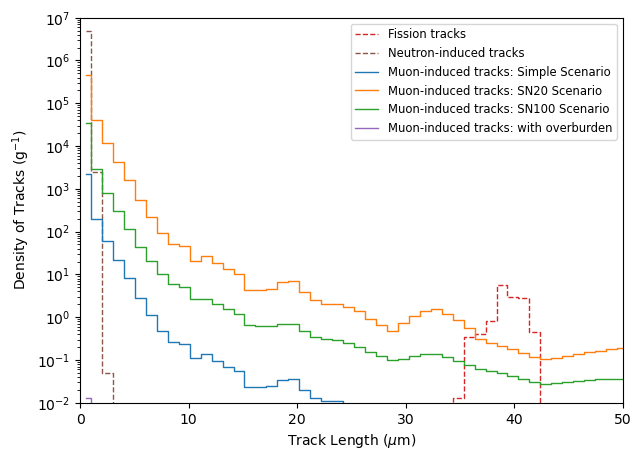

In [13]:
fig, ax = plt.subplots(figsize=[7, 5])

i = 1

ax.step(x_mids/1000, total_fission_tracks/(1e3*sample_mass_kg), color='C3', linestyle='dashed', linewidth=1., label="Fission tracks", where='mid')
ax.step(x_mids/1000, total_neutron_tracks/(1e3*sample_mass_kg), color='C5', linestyle='dashed', linewidth=1., label="Neutron-induced tracks", where='mid')
ax.step(x_mids/1000, total_mu_tracks_simple[i]/(1e3*sample_mass_kg), color='C0', label="Muon-induced tracks: Simple Scenario", linestyle='-', linewidth=1., where='mid')
ax.step(x_mids/1000, total_mu_tracks_SN20[i]/(1e3*sample_mass_kg), color='C1', label="Muon-induced tracks: SN20 Scenario", linestyle='-', linewidth=1., where='mid')
ax.step(x_mids/1000, total_mu_tracks_SN100[i]/(1e3*sample_mass_kg), color='C2', label="Muon-induced tracks: SN100 Scenario", linestyle='-', linewidth=1., where='mid')
ax.step(x_mids/1000, post_mu_tracks[i]/(1e3*sample_mass_kg), color='C4', label="Muon-induced tracks: with overburden", linestyle='-', linewidth=1., where='mid')

#ax.set_title(f"Track density distribution in {mineral_name} in the slow deposition scenario")
ax.set_xlabel(r"Track Length ($\mu$m)")
ax.set_ylabel(r"Density of Tracks (g$^{-1}$)")
ax.set_yscale("log")
ax.set_ylim(1e-2, 1e7)
ax.set_xlim(0, 50)
ax.legend(fontsize='small')
plt.savefig("Plots/MSC_track_number_per_gram.png", dpi=500)
plt.show()

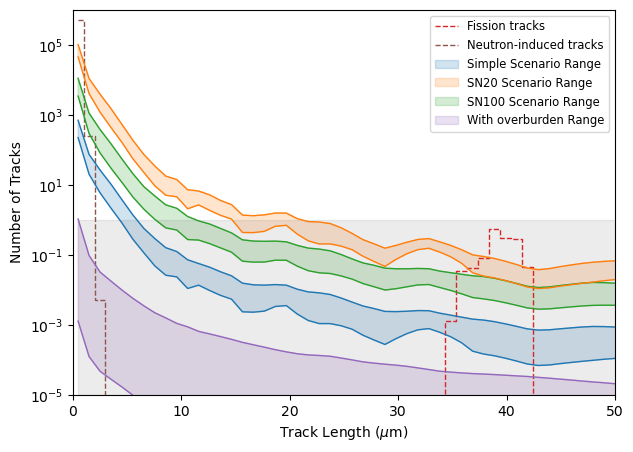

In [22]:
fig, ax = plt.subplots(figsize=[7, 5])

ax.step(x_mids/1000, total_fission_tracks, color='C3', linestyle='dashed', linewidth=1., label="Fission tracks", where='mid')
ax.step(x_mids/1000, total_neutron_tracks, color='C5', linestyle='dashed', linewidth=1., label="Neutron-induced tracks", where='mid')

for i in range(len(deposition_rate_m_kyr)):
    ax.plot(x_mids/1000, total_mu_tracks_simple[i], color='C0', linestyle='-', linewidth=1.)
    ax.plot(x_mids/1000, total_mu_tracks_SN20[i], color='C1', linestyle='-', linewidth=1.)
    ax.plot(x_mids/1000, total_mu_tracks_SN100[i], color='C2', linestyle='-', linewidth=1.)
    ax.plot(x_mids/1000, post_mu_tracks[i], color='C4', linestyle='-', linewidth=1.)

ax.fill_between(x_mids/1000, total_mu_tracks_simple[0], total_mu_tracks_simple[-1], color='C0', alpha=0.2, label='Simple Scenario Range')
ax.fill_between(x_mids/1000, total_mu_tracks_SN20[0], total_mu_tracks_SN20[-1], color='C1', alpha=0.2, label='SN20 Scenario Range')
ax.fill_between(x_mids/1000, total_mu_tracks_SN100[0], total_mu_tracks_SN100[-1], color='C2', alpha=0.2, label='SN100 Scenario Range')
ax.fill_between(x_mids/1000, post_mu_tracks[0], post_mu_tracks[-1], color='C4', alpha=0.2, label='With overburden Range')

ax.fill_between(x_mids/1000, 1e-5, 1, color='grey', alpha=0.15)


#ax.set_title(f"Track density distribution in {mineral_name} in the deposition rate range")
ax.set_xlabel(r"Track Length ($\mu$m)")
ax.set_ylabel(r"Number of Tracks")
ax.set_yscale("log")
ax.set_ylim(1e-5, 1e6)
ax.set_xlim(0, 50)
ax.legend(fontsize='small')
plt.savefig("Plots/MSC_track_number_depositions.png", dpi=500)
plt.show()

In [16]:
filepath = './Data/processed_recoils/Halite_mu-_recoil_simple_0.0kyr_0.0mwe.npz'
recoil_data = np.load(filepath)

drdx_mum = mineral._convert_recoil_to_track_spectrum(x_bins=x_bins, recoil_data=recoil_data, energy_bins_gev=CONFIG["geant4_energy_bins_gev"], species='mu-')
drdx_fission = mineral.calculate_fission_spectrum(x_bins)
drdx_neutron = mineral.calculate_neutron_spectrum(x_bins)

drdxm_org = np.zeros_like(drdx_mum['total'])
drdxm_result = np.zeros_like(drdx_mum['total'])
for name in recoil_data.files[1:]:
    if name != 'total' and name != 'Er_bins' and name != 'neutron':
        if name in ['Na23', 'Cl35', 'Cl37']:
            drdxm_org += drdx_mum[name]
        else: drdxm_result += drdx_mum[name]

filepath = './Data/processed_recoils/Halite_mu+_recoil_simple_0.0kyr_0.0mwe.npz'
recoil_data = np.load(filepath)

drdx_mup = mineral._convert_recoil_to_track_spectrum(x_bins=x_bins, recoil_data=recoil_data, energy_bins_gev=CONFIG["geant4_energy_bins_gev"], species='mu+')

drdxp_org = np.zeros_like(drdx_mup['total'])
drdxp_result = np.zeros_like(drdx_mup['total'])
for name in recoil_data.files[1:]:
    if name != 'total' and name != 'Er_bins' and name != 'neutron':
        if name in ['Na23', 'Cl35', 'Cl37']:
            drdxp_org += drdx_mup[name]
        else: drdxp_result += drdx_mup[name]

Calculating spontaneous fission background...
Calculating radiogenic neutron background...


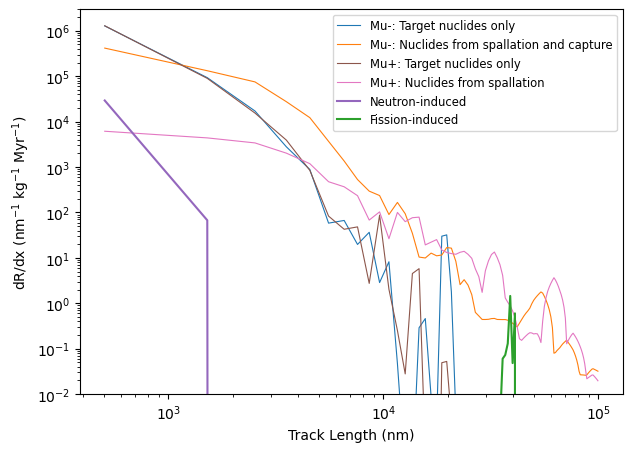

In [17]:
fig, ax = plt.subplots(figsize=[7, 5])

ax.plot(x_mids, drdxm_org, linestyle='-', linewidth=0.8, color='C0', label='Mu-: Target nuclides only')
ax.plot(x_mids, drdxm_result, linestyle='-', linewidth=0.8, color='C1', label='Mu-: Nuclides from spallation and capture')
ax.plot(x_mids, drdxp_org, linestyle='-', linewidth=0.8, color='C5', label='Mu+: Target nuclides only')
ax.plot(x_mids, drdxp_result, linestyle='-', linewidth=0.8, color='C6', label='Mu+: Nuclides from spallation')
ax.plot(x_mids, drdx_neutron, linestyle='-', color = 'C4',label='Neutron-induced')
ax.plot(x_mids, drdx_fission, linestyle='-', color = 'C2',label='Fission-induced')

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel(r"Track Length (nm)")
ax.set_ylabel(r"dR/dx (nm$^{-1}$ kg$^{-1}$ Myr$^{-1}$)")
#ax.set_title(f"Track rate spectrum in {mineral_name}")
ax.set_ylim(1e-2, 3e6)
ax.legend(fontsize='small', loc='upper right')
plt.savefig("Plots/MSC_drdx_pvsm.png", dpi=500)
plt.show()

In [18]:
filepath_SN20 = './Data/processed_recoils/Halite_mu-_recoil_SN20_0.0kyr_0.0mwe.npz'
recoil_data_SN20 = np.load(filepath_SN20)

drdx_muon_SN20 = mineral._convert_recoil_to_track_spectrum(x_bins=x_bins, recoil_data=recoil_data_SN20, energy_bins_gev=CONFIG["geant4_energy_bins_gev"], species='mu-')

filepath_SN100 = './Data/processed_recoils/Halite_mu-_recoil_SN100_0.0kyr_0.0mwe.npz'
recoil_data_SN100 = np.load(filepath_SN100)

drdx_muon_SN100 = mineral._convert_recoil_to_track_spectrum(x_bins=x_bins, recoil_data=recoil_data_SN100, energy_bins_gev=CONFIG["geant4_energy_bins_gev"], species='mu-')

filepath_over = './Data/processed_recoils/Halite_mu-_recoil_simple_0.0kyr_3120.0mwe.npz'
recoil_data_over = np.load(filepath_over)

drdx_muon_over = mineral._convert_recoil_to_track_spectrum(x_bins=x_bins, recoil_data=recoil_data_over, energy_bins_gev=CONFIG["geant4_energy_bins_gev"], species='mu-')


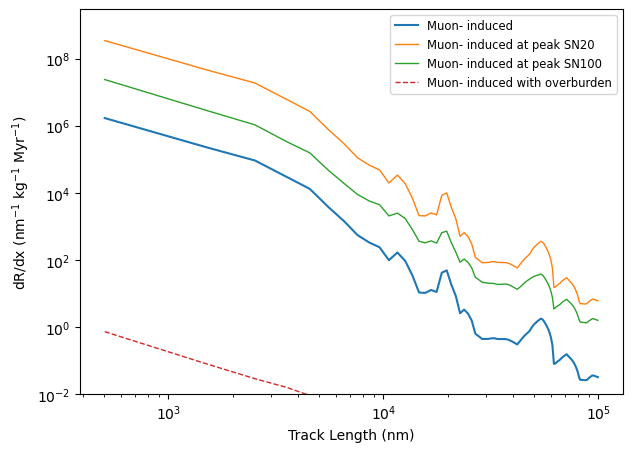

In [19]:
fig, ax = plt.subplots(figsize=[7, 5])

ax.plot(x_mids, drdx_mum['total'], label='Muon- induced')
ax.plot(x_mids, drdx_muon_SN20['total'], linestyle='-', linewidth=1., label='Muon- induced at peak SN20')
ax.plot(x_mids, drdx_muon_SN100['total'], linestyle='-', linewidth=1., label='Muon- induced at peak SN100')
ax.plot(x_mids, drdx_muon_over['total'], linestyle='--', linewidth=1., label='Muon- induced with overburden')


ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel(r"Track Length (nm)")
ax.set_ylabel(r"dR/dx (nm$^{-1}$ kg$^{-1}$ Myr$^{-1}$)")
#ax.set_title(f"Track rate spectrum in {mineral_name}")
ax.set_ylim(1e-2, 3e9)
ax.legend(fontsize='small', loc='upper right')
plt.savefig("Plots/MSC_drdx_scenarios.png", dpi=500)
plt.show()

In [20]:
filepath = 'Data/processed_recoils/Halite_mu-_recoil_simple_15.0kyr_81.0mwe.npz'
recoil_data = np.load(filepath)

drdx_mum_over_slow = mineral._convert_recoil_to_track_spectrum(x_bins=x_bins, recoil_data=recoil_data, energy_bins_gev=CONFIG["geant4_energy_bins_gev"], species='mu-')

filepath = 'Data/processed_recoils/Halite_mu-_recoil_simple_15.0kyr_972.0mwe.npz'
recoil_data = np.load(filepath)

drdx_mum_over_fast = mineral._convert_recoil_to_track_spectrum(x_bins=x_bins, recoil_data=recoil_data, energy_bins_gev=CONFIG["geant4_energy_bins_gev"], species='mu-')


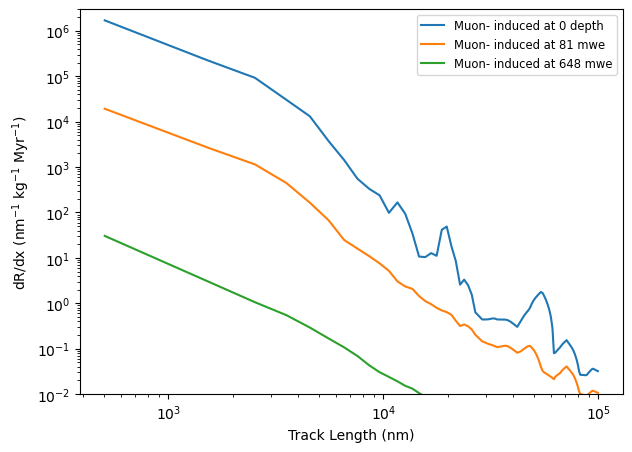

In [21]:
fig, ax = plt.subplots(figsize=[7, 5])

ax.plot(x_mids, drdx_mum['total'], label='Muon- induced at 0 depth')
ax.plot(x_mids, drdx_mum_over_slow['total'], label='Muon- induced at 81 mwe')
ax.plot(x_mids, drdx_mum_over_fast['total'], label='Muon- induced at 648 mwe')


ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel(r"Track Length (nm)")
ax.set_ylabel(r"dR/dx (nm$^{-1}$ kg$^{-1}$ Myr$^{-1}$)")
#ax.set_title(f"Track rate spectrum in {mineral_name}")
ax.set_ylim(1e-2, 3e6)
ax.legend(fontsize='small', loc='upper right')
plt.savefig("Plots/MSC_drdx_scenarios.png", dpi=500)
plt.show()